In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/PSIQUIATRIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 8 questions
Page 1, Q1 - A: Detected box: x0=82.5, y0=148.2, x1=127.1, y1=160.9
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 247
Page 1, Q1, A: Yellow percentage: 0.0%


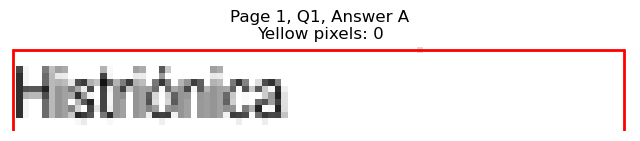

Page 1, Q1 - B: Detected box: x0=82.5, y0=160.8, x1=134.2, y1=173.5
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 254
Page 1, Q1, B: Yellow percentage: 0.0%


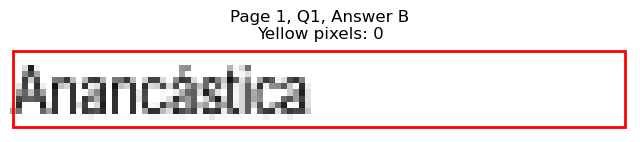

Page 1, Q1 - C: Detected box: x0=82.9, y0=173.4, x1=120.5, y1=186.1
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 187
Page 1, Q1, C: Yellow percentage: 0.0%


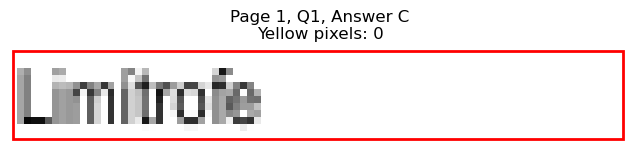

Page 1, Q1 - D: Detected box: x0=334.6, y0=148.2, x1=390.8, y1=160.9
Page 1, Q1, D: Yellow pixels: 1159
Page 1, Q1, D: Total non-white pixels: 1391
Page 1, Q1, D: Yellow percentage: 83.3%


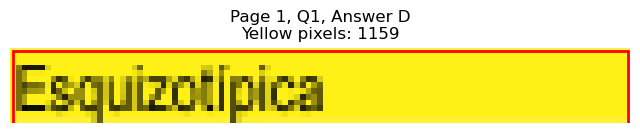

Page 1, Q1 - E: Detected box: x0=334.1, y0=160.8, x1=370.7, y1=173.5
Page 1, Q1, E: Yellow pixels: 85
Page 1, Q1, E: Total non-white pixels: 282
Page 1, Q1, E: Yellow percentage: 30.1%


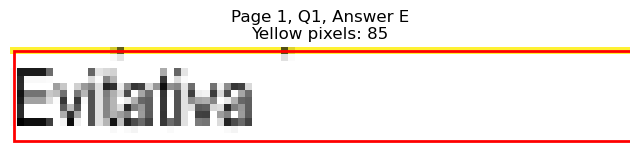


Page 1, Q1 - Selected Answer: D (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=157.2, y1=224.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 478
Page 1, Q2, A: Yellow percentage: 0.0%


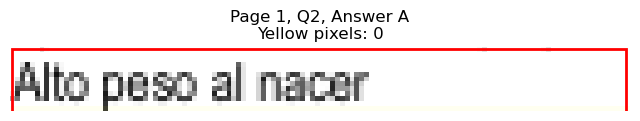

Page 1, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=142.1, y1=236.6
Page 1, Q2, B: Yellow pixels: 1186
Page 1, Q2, B: Total non-white pixels: 1554
Page 1, Q2, B: Yellow percentage: 76.3%


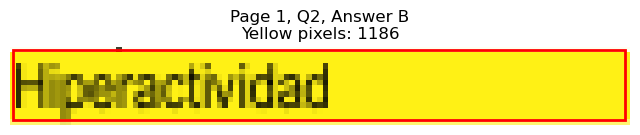

Page 1, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=137.7, y1=249.2
Page 1, Q2, C: Yellow pixels: 106
Page 1, Q2, C: Total non-white pixels: 368
Page 1, Q2, C: Yellow percentage: 28.8%


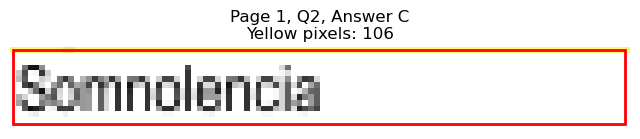

Page 1, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=384.8, y1=224.0
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 264
Page 1, Q2, D: Yellow percentage: 0.0%


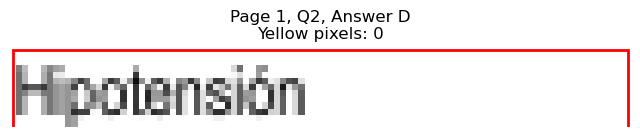

Page 1, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=417.4, y1=236.6
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 459
Page 1, Q2, E: Yellow percentage: 0.0%


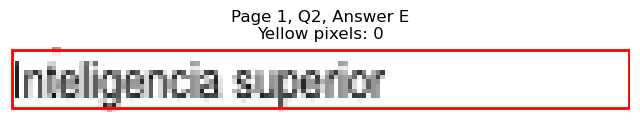


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=132.1, y1=287.1
Page 1, Q3, A: Yellow pixels: 1113
Page 1, Q3, A: Total non-white pixels: 1414
Page 1, Q3, A: Yellow percentage: 78.7%


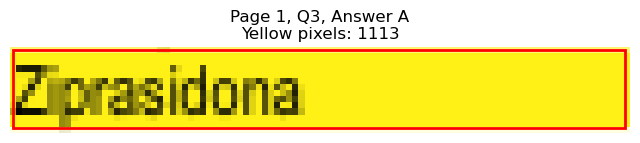

Page 1, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=132.1, y1=299.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 338
Page 1, Q3, B: Yellow percentage: 0.0%


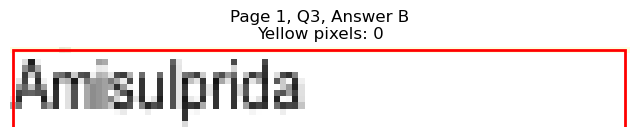

Page 1, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=128.1, y1=312.3
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 241
Page 1, Q3, C: Yellow percentage: 0.0%


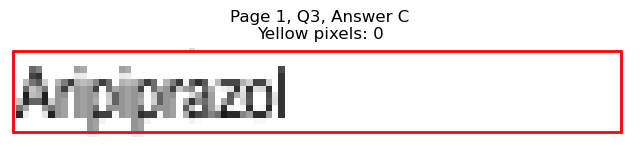

Page 1, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=380.8, y1=287.1
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 264
Page 1, Q3, D: Yellow percentage: 0.0%


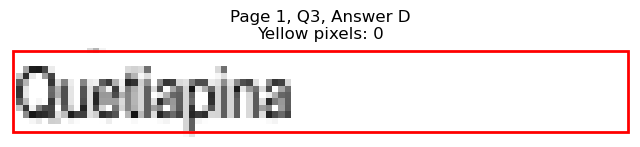

Page 1, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=384.8, y1=299.7
Page 1, Q3, E: Yellow pixels: 0
Page 1, Q3, E: Total non-white pixels: 280
Page 1, Q3, E: Yellow percentage: 0.0%


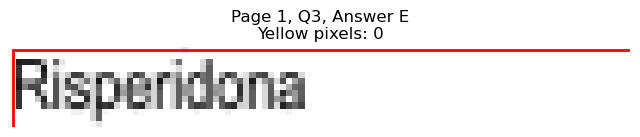


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.5, y0=375.4, x1=154.2, y1=388.1
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 336
Page 1, Q4, A: Yellow percentage: 0.0%


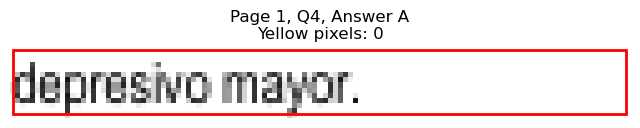

Page 1, Q4 - B: Detected box: x0=82.5, y0=388.0, x1=152.7, y1=400.7
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 348
Page 1, Q4, B: Yellow percentage: 0.0%


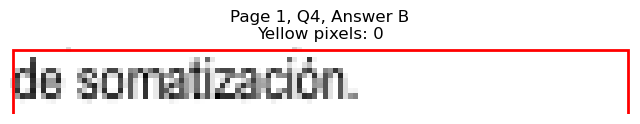

Page 1, Q4 - C: Detected box: x0=82.9, y0=400.6, x1=152.2, y1=413.3
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 347
Page 1, Q4, C: Yellow percentage: 0.0%


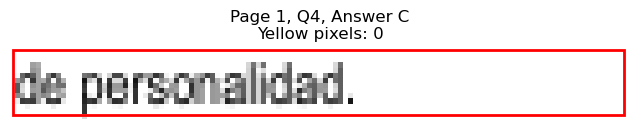

Page 1, Q4 - D: Detected box: x0=334.6, y0=375.4, x1=413.3, y1=388.1
Page 1, Q4, D: Yellow pixels: 130
Page 1, Q4, D: Total non-white pixels: 519
Page 1, Q4, D: Yellow percentage: 25.0%


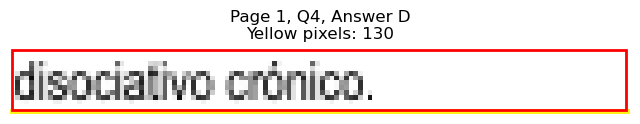

Page 1, Q4 - E: Detected box: x0=334.1, y0=388.0, x1=427.9, y1=400.7
Page 1, Q4, E: Yellow pixels: 1474
Page 1, Q4, E: Total non-white pixels: 1872
Page 1, Q4, E: Yellow percentage: 78.7%


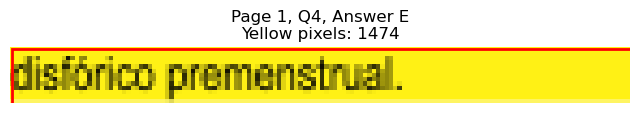


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.5, y0=438.5, x1=128.7, y1=451.2
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 247
Page 1, Q5, A: Yellow percentage: 0.0%


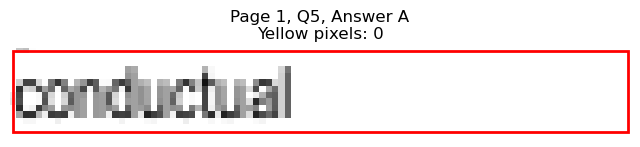

Page 1, Q5 - B: Detected box: x0=82.5, y0=451.1, x1=129.6, y1=463.8
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 354
Page 1, Q5, B: Yellow percentage: 0.0%


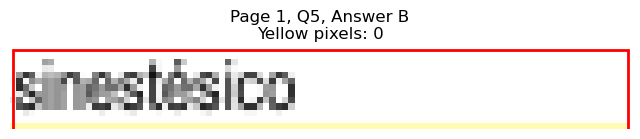

Page 1, Q5 - C: Detected box: x0=82.9, y0=463.7, x1=142.6, y1=476.4
Page 1, Q5, C: Yellow pixels: 1081
Page 1, Q5, C: Total non-white pixels: 1554
Page 1, Q5, C: Yellow percentage: 69.6%


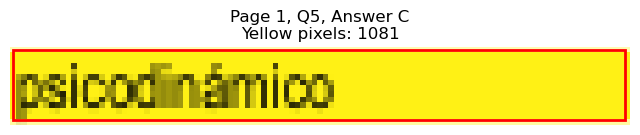

Page 1, Q5 - D: Detected box: x0=334.6, y0=438.5, x1=372.8, y1=451.2
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 197
Page 1, Q5, D: Yellow percentage: 0.0%


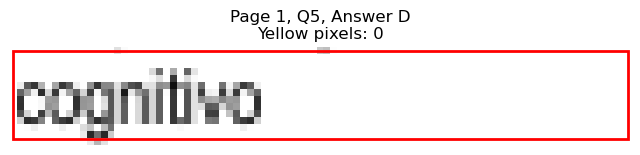

Page 1, Q5 - E: Detected box: x0=334.1, y0=451.1, x1=380.8, y1=463.8
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 246
Page 1, Q5, E: Yellow percentage: 0.0%


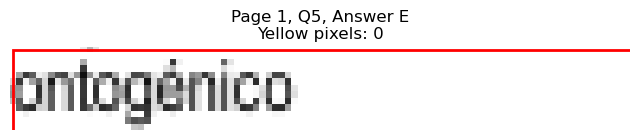


Page 1, Q5 - Selected Answer: C (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.5, y0=539.5, x1=175.2, y1=552.1
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 441
Page 1, Q6, A: Yellow percentage: 0.0%


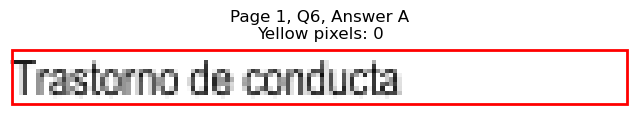

Page 1, Q6 - B: Detected box: x0=82.5, y0=552.2, x1=222.4, y1=564.8
Page 1, Q6, B: Yellow pixels: 1939
Page 1, Q6, B: Total non-white pixels: 2483
Page 1, Q6, B: Yellow percentage: 78.1%


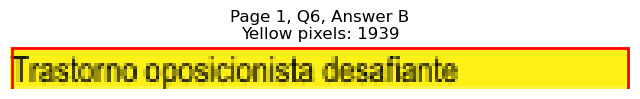

Page 1, Q6 - C: Detected box: x0=82.9, y0=564.8, x1=155.2, y1=577.4
Page 1, Q6, C: Yellow pixels: 123
Page 1, Q6, C: Total non-white pixels: 504
Page 1, Q6, C: Yellow percentage: 24.4%


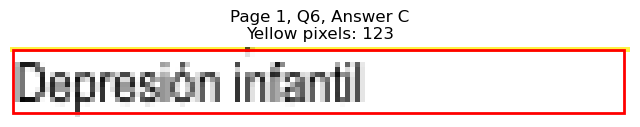

Page 1, Q6 - D: Detected box: x0=334.6, y0=539.5, x1=427.9, y1=552.1
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 463
Page 1, Q6, D: Yellow percentage: 0.0%


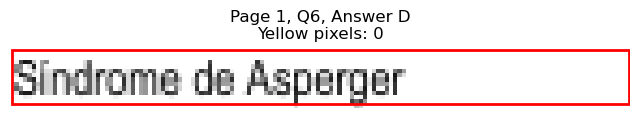

Page 1, Q6 - E: Detected box: x0=334.1, y0=552.2, x1=506.7, y1=564.8
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 846
Page 1, Q6, E: Yellow percentage: 0.0%


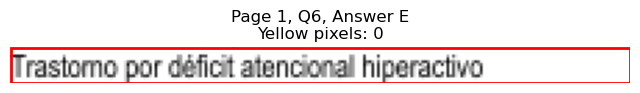


Page 1, Q6 - Selected Answer: B (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.5, y0=602.6, x1=145.1, y1=615.2
Page 1, Q7, A: Yellow pixels: 114
Page 1, Q7, A: Total non-white pixels: 456
Page 1, Q7, A: Yellow percentage: 25.0%


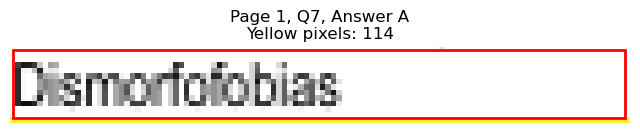

Page 1, Q7 - B: Detected box: x0=82.5, y0=615.2, x1=149.2, y1=627.8
Page 1, Q7, B: Yellow pixels: 1250
Page 1, Q7, B: Total non-white pixels: 1534
Page 1, Q7, B: Yellow percentage: 81.5%


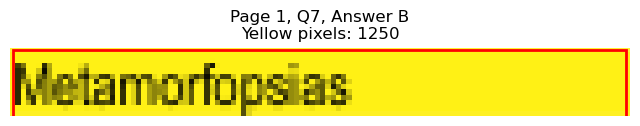

Page 1, Q7 - C: Detected box: x0=82.9, y0=627.9, x1=131.5, y1=640.6
Page 1, Q7, C: Yellow pixels: 99
Page 1, Q7, C: Total non-white pixels: 362
Page 1, Q7, C: Yellow percentage: 27.3%


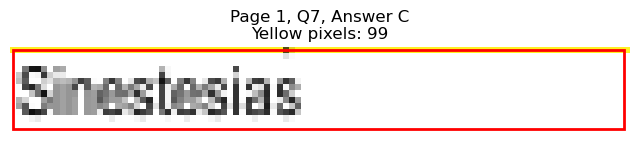

Page 1, Q7 - D: Detected box: x0=334.6, y0=602.6, x1=381.8, y1=615.2
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 258
Page 1, Q7, D: Yellow percentage: 0.0%


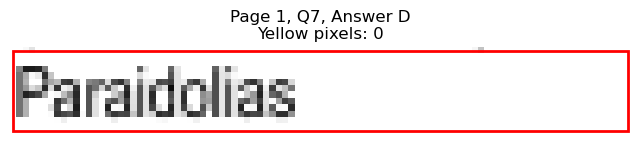

Page 1, Q7 - E: Detected box: x0=334.1, y0=615.2, x1=379.7, y1=627.8
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 240
Page 1, Q7, E: Yellow percentage: 0.0%


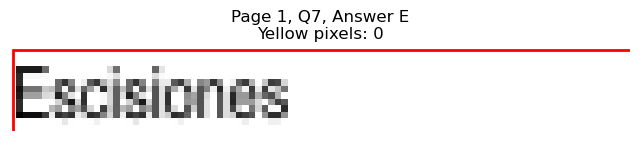


Page 1, Q7 - Selected Answer: B (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.5, y0=703.7, x1=135.6, y1=716.3
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 314
Page 1, Q8, A: Yellow percentage: 0.0%


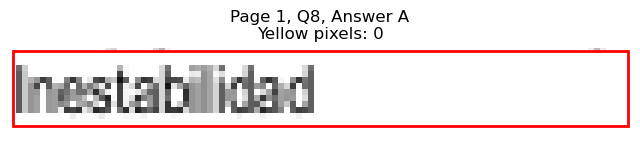

Page 1, Q8 - B: Detected box: x0=82.5, y0=716.3, x1=118.1, y1=728.9
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 276
Page 1, Q8, B: Yellow percentage: 0.0%


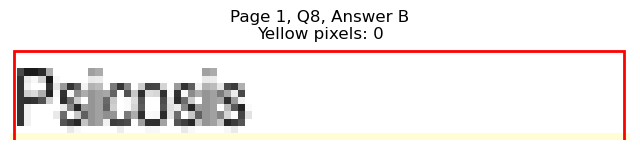

Page 1, Q8 - C: Detected box: x0=82.9, y0=728.9, x1=124.6, y1=741.5
Page 1, Q8, C: Yellow pixels: 1037
Page 1, Q8, C: Total non-white pixels: 1302
Page 1, Q8, C: Yellow percentage: 79.6%


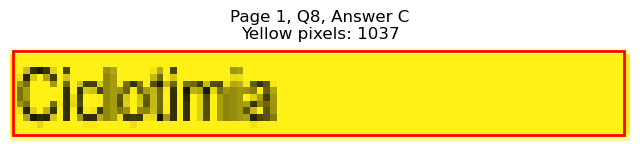

Page 1, Q8 - D: Detected box: x0=334.6, y0=703.7, x1=383.2, y1=716.3
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 258
Page 1, Q8, D: Yellow percentage: 0.0%


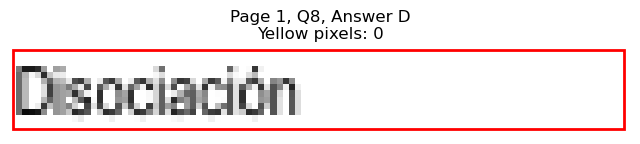

Page 1, Q8 - E: Detected box: x0=334.1, y0=716.3, x1=381.9, y1=728.9
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 257
Page 1, Q8, E: Yellow percentage: 0.0%


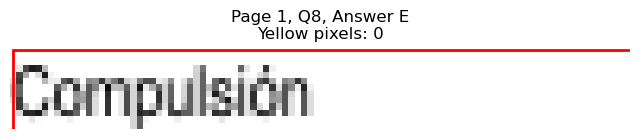


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=108.0, y1=123.0
Page 2, Q1, A: Yellow pixels: 920
Page 2, Q1, A: Total non-white pixels: 1001
Page 2, Q1, A: Yellow percentage: 91.9%


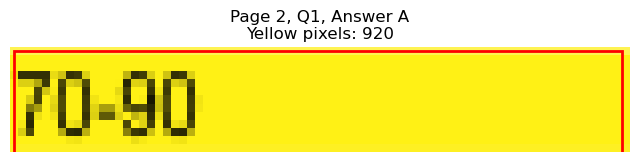

Page 2, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=108.0, y1=135.6
Page 2, Q1, B: Yellow pixels: 77
Page 2, Q1, B: Total non-white pixels: 191
Page 2, Q1, B: Yellow percentage: 40.3%


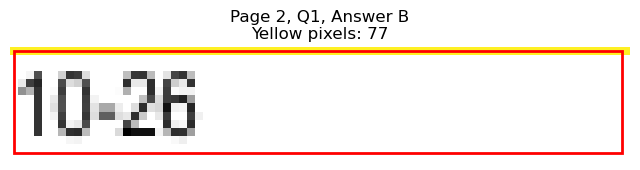

Page 2, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=108.5, y1=148.2
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 144
Page 2, Q1, C: Yellow percentage: 0.0%


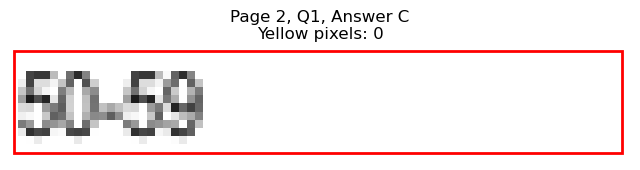

Page 2, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=360.2, y1=123.0
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 122
Page 2, Q1, D: Yellow percentage: 0.0%


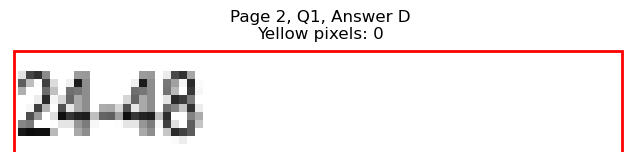

Page 2, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=359.7, y1=135.6
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 111
Page 2, Q1, E: Yellow percentage: 0.0%


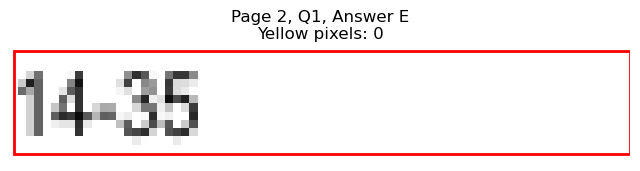


Page 2, Q1 - Selected Answer: A (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=112.6, y1=198.7
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 172
Page 2, Q2, A: Yellow percentage: 0.0%


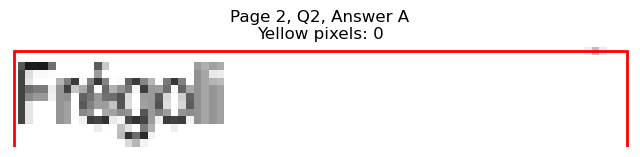

Page 2, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=123.1, y1=211.3
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 229
Page 2, Q2, B: Yellow percentage: 0.0%


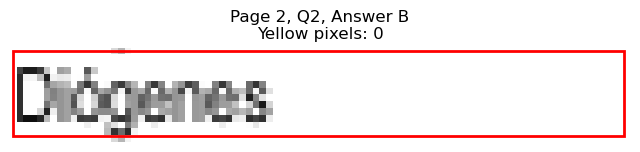

Page 2, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=115.1, y1=224.0
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 166
Page 2, Q2, C: Yellow percentage: 0.0%


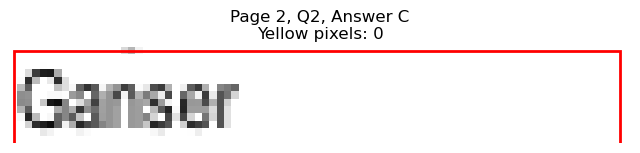

Page 2, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=375.3, y1=198.7
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 303
Page 2, Q2, D: Yellow percentage: 0.0%


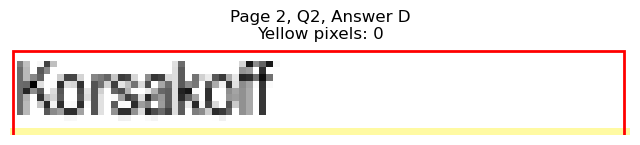

Page 2, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=363.8, y1=211.3
Page 2, Q2, E: Yellow pixels: 841
Page 2, Q2, E: Total non-white pixels: 1120
Page 2, Q2, E: Yellow percentage: 75.1%


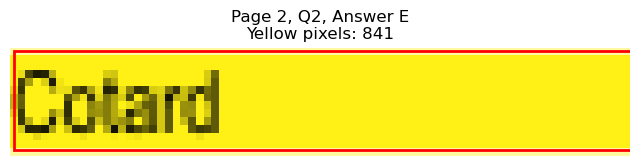


Page 2, Q2 - Selected Answer: E (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=131.7, y1=261.8
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 255
Page 2, Q3, A: Yellow percentage: 0.0%


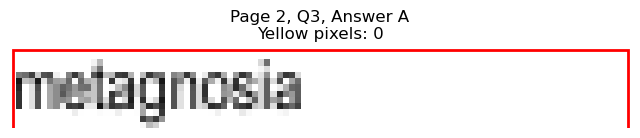

Page 2, Q3 - B: Detected box: x0=82.5, y0=261.7, x1=109.1, y1=274.4
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 116
Page 2, Q3, B: Yellow percentage: 0.0%


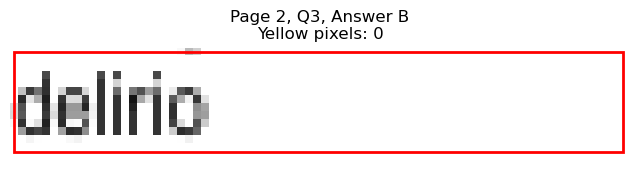

Page 2, Q3 - C: Detected box: x0=82.9, y0=274.5, x1=137.7, y1=287.1
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 292
Page 2, Q3, C: Yellow percentage: 0.0%


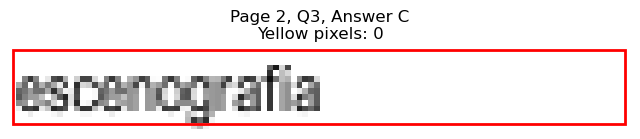

Page 2, Q3 - D: Detected box: x0=334.6, y0=249.1, x1=369.2, y1=261.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 253
Page 2, Q3, D: Yellow percentage: 0.0%


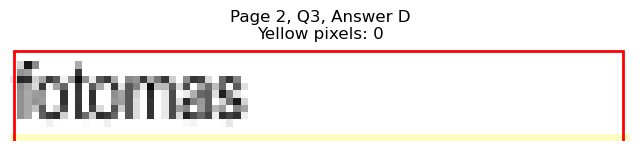

Page 2, Q3 - E: Detected box: x0=334.1, y0=261.7, x1=380.8, y1=274.4
Page 2, Q3, E: Yellow pixels: 1077
Page 2, Q3, E: Total non-white pixels: 1358
Page 2, Q3, E: Yellow percentage: 79.3%


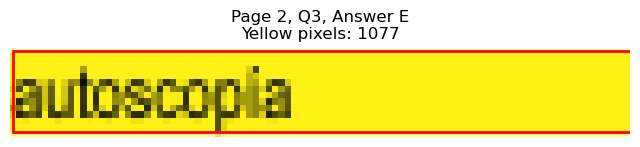


Page 2, Q3 - Selected Answer: E (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=82.5, y0=324.9, x1=110.1, y1=337.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 133
Page 2, Q4, A: Yellow percentage: 0.0%


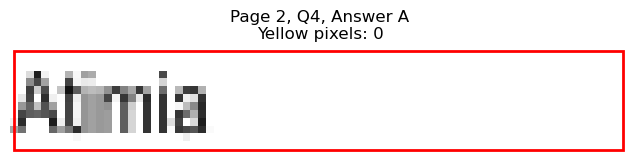

Page 2, Q4 - B: Detected box: x0=82.5, y0=337.5, x1=119.1, y1=350.1
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 195
Page 2, Q4, B: Yellow percentage: 0.0%


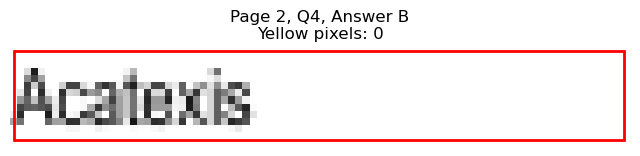

Page 2, Q4 - C: Detected box: x0=82.9, y0=350.2, x1=119.5, y1=362.9
Page 2, Q4, C: Yellow pixels: 0
Page 2, Q4, C: Total non-white pixels: 176
Page 2, Q4, C: Yellow percentage: 0.0%


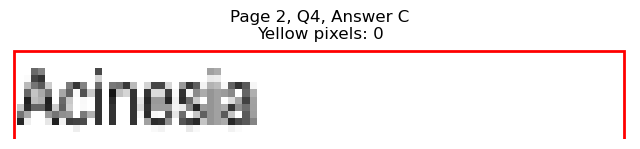

Page 2, Q4 - D: Detected box: x0=334.6, y0=324.9, x1=362.2, y1=337.5
Page 2, Q4, D: Yellow pixels: 79
Page 2, Q4, D: Total non-white pixels: 226
Page 2, Q4, D: Yellow percentage: 35.0%


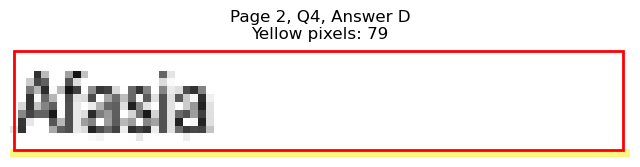

Page 2, Q4 - E: Detected box: x0=334.1, y0=337.5, x1=361.7, y1=350.1
Page 2, Q4, E: Yellow pixels: 895
Page 2, Q4, E: Total non-white pixels: 1092
Page 2, Q4, E: Yellow percentage: 82.0%


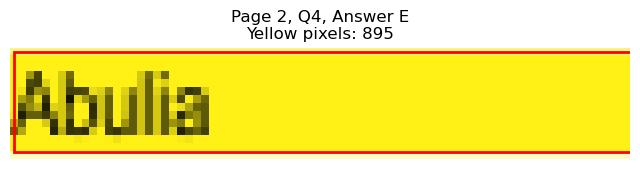


Page 2, Q4 - Selected Answer: E (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.5, y0=425.9, x1=136.1, y1=438.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 272
Page 2, Q5, A: Yellow percentage: 0.0%


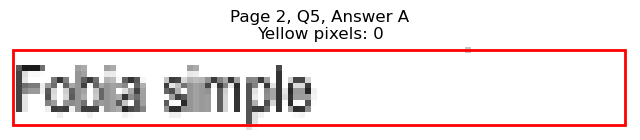

Page 2, Q5 - B: Detected box: x0=82.5, y0=438.5, x1=138.1, y1=451.2
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 300
Page 2, Q5, B: Yellow percentage: 0.0%


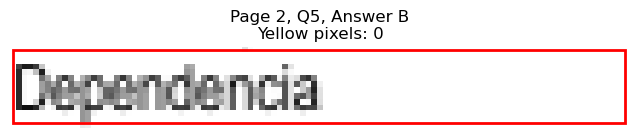

Page 2, Q5 - C: Detected box: x0=82.9, y0=451.1, x1=134.1, y1=463.8
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 258
Page 2, Q5, C: Yellow percentage: 0.0%


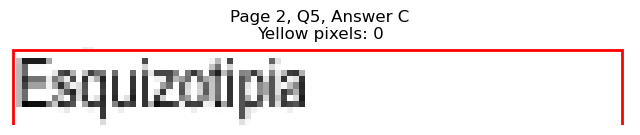

Page 2, Q5 - D: Detected box: x0=334.6, y0=425.9, x1=400.4, y1=438.6
Page 2, Q5, D: Yellow pixels: 1257
Page 2, Q5, D: Total non-white pixels: 1638
Page 2, Q5, D: Yellow percentage: 76.7%


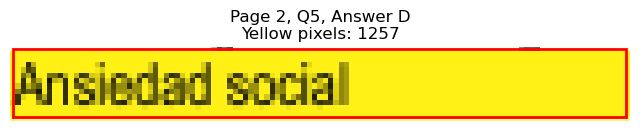

Page 2, Q5 - E: Detected box: x0=334.1, y0=438.5, x1=402.3, y1=451.2
Page 2, Q5, E: Yellow pixels: 119
Page 2, Q5, E: Total non-white pixels: 467
Page 2, Q5, E: Yellow percentage: 25.5%


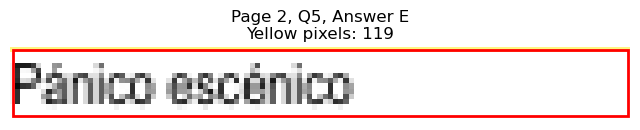


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.5, y0=489.1, x1=145.7, y1=501.7
Page 2, Q6, A: Yellow pixels: 1
Page 2, Q6, A: Total non-white pixels: 456
Page 2, Q6, A: Yellow percentage: 0.2%


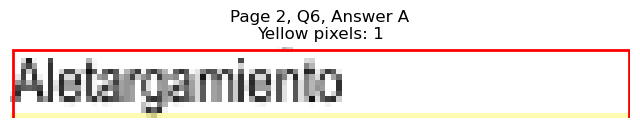

Page 2, Q6 - B: Detected box: x0=82.5, y0=501.7, x1=138.6, y1=514.3
Page 2, Q6, B: Yellow pixels: 1058
Page 2, Q6, B: Total non-white pixels: 1498
Page 2, Q6, B: Yellow percentage: 70.6%


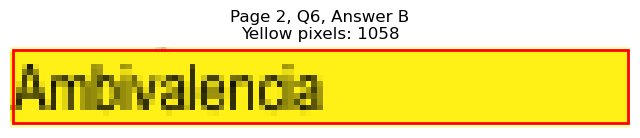

Page 2, Q6 - C: Detected box: x0=82.9, y0=514.3, x1=122.5, y1=526.9
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 286
Page 2, Q6, C: Yellow percentage: 0.0%


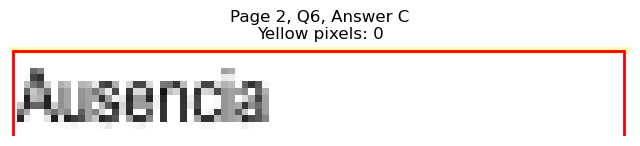

Page 2, Q6 - D: Detected box: x0=334.6, y0=489.1, x1=369.8, y1=501.7
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 179
Page 2, Q6, D: Yellow percentage: 0.0%


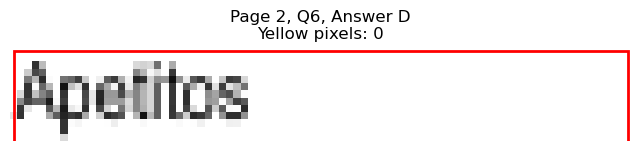

Page 2, Q6 - E: Detected box: x0=334.1, y0=501.7, x1=392.3, y1=514.3
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 305
Page 2, Q6, E: Yellow percentage: 0.0%


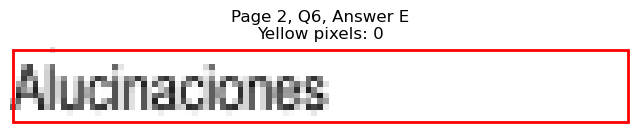


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.5, y0=577.4, x1=144.6, y1=590.0
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 305
Page 2, Q7, A: Yellow percentage: 0.0%


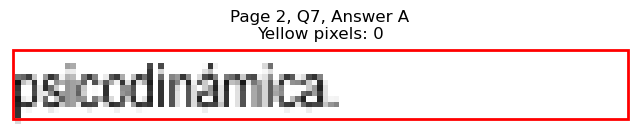

Page 2, Q7 - B: Detected box: x0=82.5, y0=590.0, x1=169.2, y1=602.6
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 436
Page 2, Q7, B: Yellow percentage: 0.0%


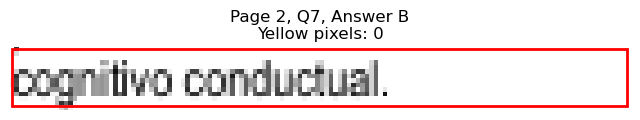

Page 2, Q7 - C: Detected box: x0=82.9, y0=602.6, x1=157.1, y1=615.2
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 382
Page 2, Q7, C: Yellow percentage: 0.0%


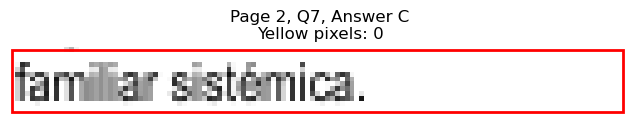

Page 2, Q7 - D: Detected box: x0=334.6, y0=577.4, x1=408.9, y1=590.0
Page 2, Q7, D: Yellow pixels: 1347
Page 2, Q7, D: Total non-white pixels: 1625
Page 2, Q7, D: Yellow percentage: 82.9%


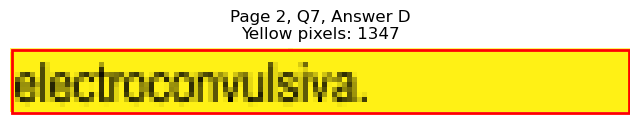

Page 2, Q7 - E: Detected box: x0=334.1, y0=590.0, x1=397.9, y1=602.6
Page 2, Q7, E: Yellow pixels: 114
Page 2, Q7, E: Total non-white pixels: 419
Page 2, Q7, E: Yellow percentage: 27.2%


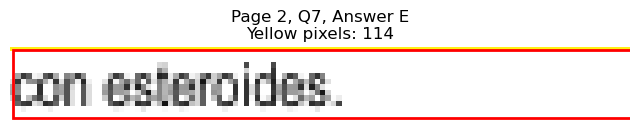


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.5, y0=653.1, x1=170.8, y1=665.8
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 573
Page 2, Q8, A: Yellow percentage: 0.0%


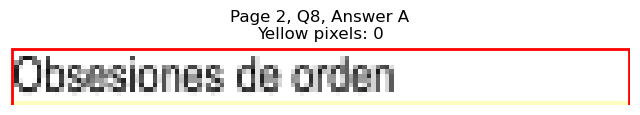

Page 2, Q8 - B: Detected box: x0=82.5, y0=665.7, x1=193.3, y1=678.4
Page 2, Q8, B: Yellow pixels: 1521
Page 2, Q8, B: Total non-white pixels: 2268
Page 2, Q8, B: Yellow percentage: 67.1%


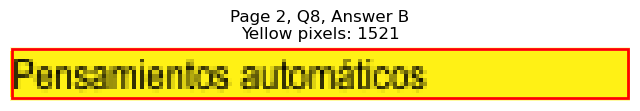

Page 2, Q8 - C: Detected box: x0=82.9, y0=678.3, x1=184.2, y1=691.0
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 658
Page 2, Q8, C: Yellow percentage: 0.0%


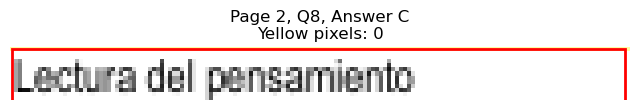

Page 2, Q8 - D: Detected box: x0=334.6, y0=653.1, x1=435.9, y1=665.8
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 533
Page 2, Q8, D: Yellow percentage: 0.0%


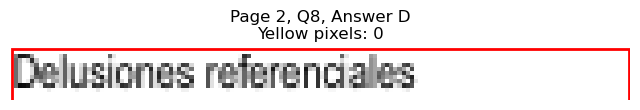

Page 2, Q8 - E: Detected box: x0=334.1, y0=665.7, x1=410.8, y1=678.4
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 410
Page 2, Q8, E: Yellow percentage: 0.0%


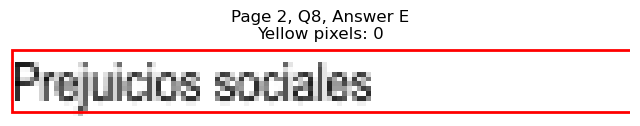


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=82.5, y0=741.4, x1=131.1, y1=754.1
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 241
Page 2, Q9, A: Yellow percentage: 0.0%


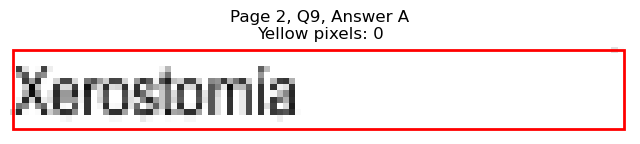

Page 2, Q9 - B: Detected box: x0=82.5, y0=754.0, x1=132.1, y1=766.7
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 245
Page 2, Q9, B: Yellow percentage: 0.0%


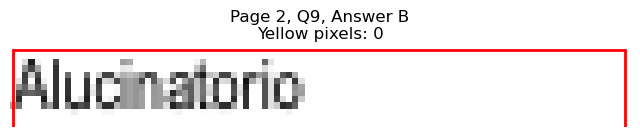

Page 2, Q9 - C: Detected box: x0=82.9, y0=766.8, x1=127.6, y1=779.4
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 223
Page 2, Q9, C: Yellow percentage: 0.0%


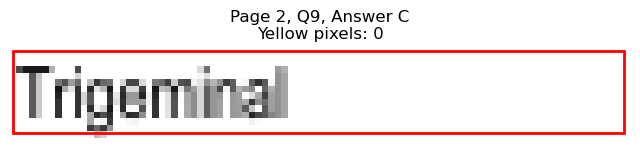

Page 2, Q9 - D: Detected box: x0=334.6, y0=741.4, x1=390.3, y1=754.1
Page 2, Q9, D: Yellow pixels: 107
Page 2, Q9, D: Total non-white pixels: 381
Page 2, Q9, D: Yellow percentage: 28.1%


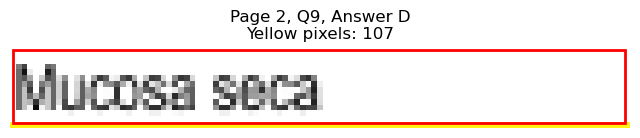

Page 2, Q9 - E: Detected box: x0=334.1, y0=754.0, x1=382.8, y1=766.7
Page 2, Q9, E: Yellow pixels: 1091
Page 2, Q9, E: Total non-white pixels: 1287
Page 2, Q9, E: Yellow percentage: 84.8%


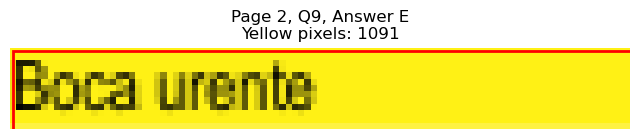


Page 2, Q9 - Selected Answer: E (based on yellow pixel count)





Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=82.5, y0=148.2, x1=209.9, y1=160.9
Page 3, Q1, A: Yellow pixels: 1778
Page 3, Q1, A: Total non-white pixels: 2314
Page 3, Q1, A: Yellow percentage: 76.8%


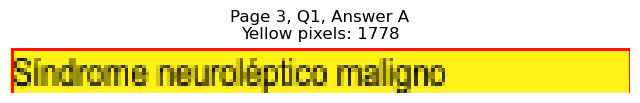

Page 3, Q1 - B: Detected box: x0=82.5, y0=160.8, x1=203.3, y1=173.5
Page 3, Q1, B: Yellow pixels: 167
Page 3, Q1, B: Total non-white pixels: 815
Page 3, Q1, B: Yellow percentage: 20.5%


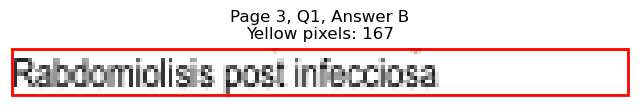

Page 3, Q1 - C: Detected box: x0=82.9, y0=173.4, x1=192.7, y1=186.1
Page 3, Q1, C: Yellow pixels: 0
Page 3, Q1, C: Total non-white pixels: 556
Page 3, Q1, C: Yellow percentage: 0.0%


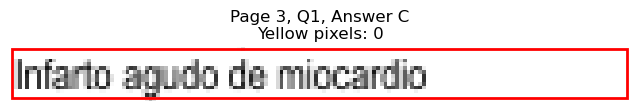

Page 3, Q1 - D: Detected box: x0=334.6, y0=148.2, x1=424.9, y1=160.9
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 447
Page 3, Q1, D: Yellow percentage: 0.0%


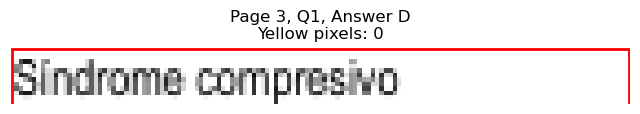

Page 3, Q1 - E: Detected box: x0=334.1, y0=160.8, x1=446.9, y1=173.5
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 538
Page 3, Q1, E: Yellow percentage: 0.0%


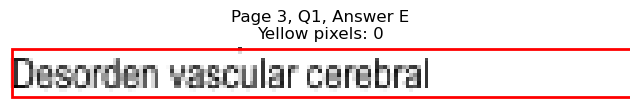


Page 3, Q1 - Selected Answer: A (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.5, y0=223.9, x1=139.6, y1=236.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 291
Page 3, Q2, A: Yellow percentage: 0.0%


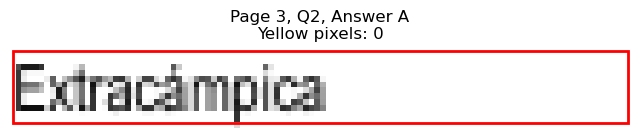

Page 3, Q2 - B: Detected box: x0=82.5, y0=236.5, x1=123.1, y1=249.2
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 195
Page 3, Q2, B: Yellow percentage: 0.0%


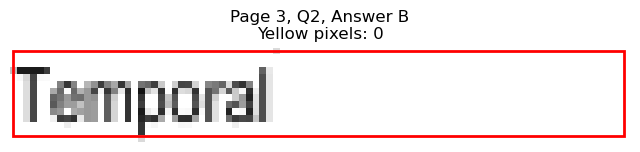

Page 3, Q2 - C: Detected box: x0=82.9, y0=249.1, x1=131.5, y1=261.8
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 265
Page 3, Q2, C: Yellow percentage: 0.0%


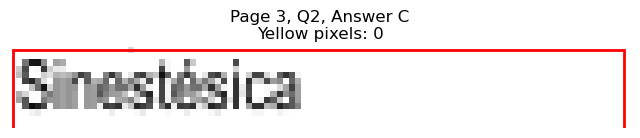

Page 3, Q2 - D: Detected box: x0=334.6, y0=223.9, x1=376.3, y1=236.6
Page 3, Q2, D: Yellow pixels: 1059
Page 3, Q2, D: Total non-white pixels: 1302
Page 3, Q2, D: Yellow percentage: 81.3%


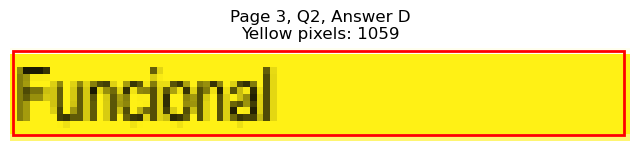

Page 3, Q2 - E: Detected box: x0=334.1, y0=236.5, x1=386.8, y1=249.2
Page 3, Q2, E: Yellow pixels: 103
Page 3, Q2, E: Total non-white pixels: 403
Page 3, Q2, E: Yellow percentage: 25.6%


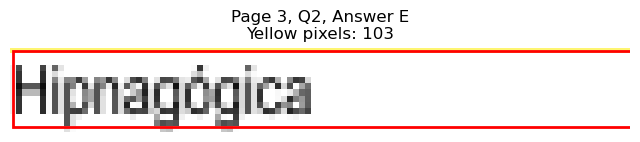


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=137.2, y1=312.3
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 295
Page 3, Q3, A: Yellow percentage: 0.0%


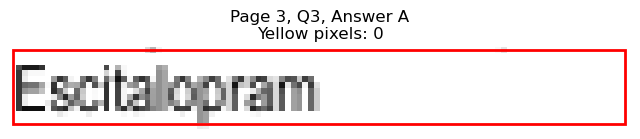

Page 3, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=126.6, y1=324.9
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 235
Page 3, Q3, B: Yellow percentage: 0.0%


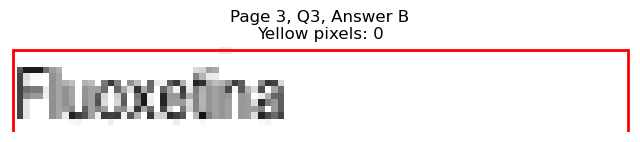

Page 3, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=132.6, y1=337.5
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 255
Page 3, Q3, C: Yellow percentage: 0.0%


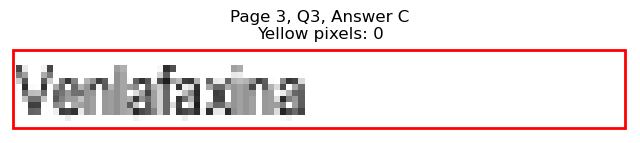

Page 3, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=383.7, y1=312.3
Page 3, Q3, D: Yellow pixels: 987
Page 3, Q3, D: Total non-white pixels: 1400
Page 3, Q3, D: Yellow percentage: 70.5%


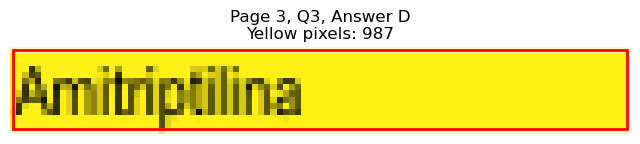

Page 3, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=383.3, y1=324.9
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 379
Page 3, Q3, E: Yellow percentage: 0.0%


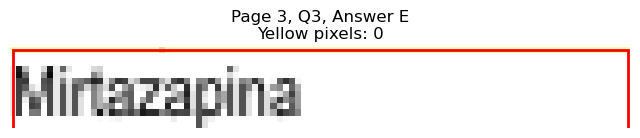


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.5, y0=400.6, x1=170.3, y1=413.3
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 438
Page 3, Q4, A: Yellow percentage: 0.0%


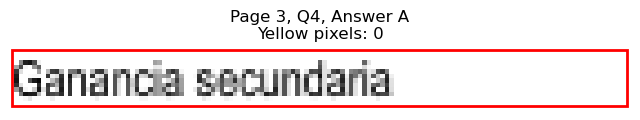

Page 3, Q4 - B: Detected box: x0=82.5, y0=413.3, x1=178.7, y1=426.0
Page 3, Q4, B: Yellow pixels: 1547
Page 3, Q4, B: Total non-white pixels: 1911
Page 3, Q4, B: Yellow percentage: 81.0%


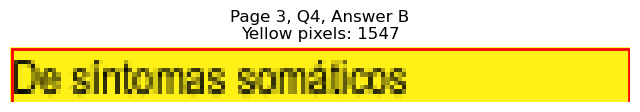

Page 3, Q4 - C: Detected box: x0=82.9, y0=425.9, x1=142.1, y1=438.6
Page 3, Q4, C: Yellow pixels: 111
Page 3, Q4, C: Total non-white pixels: 392
Page 3, Q4, C: Yellow percentage: 28.3%


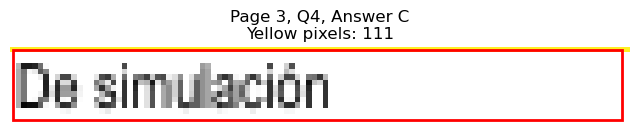

Page 3, Q4 - D: Detected box: x0=334.6, y0=400.6, x1=422.3, y1=413.3
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 439
Page 3, Q4, D: Yellow percentage: 0.0%


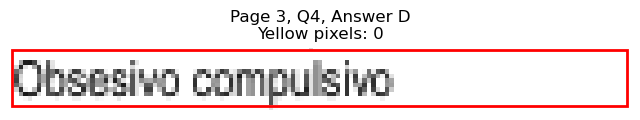

Page 3, Q4 - E: Detected box: x0=334.1, y0=413.3, x1=428.0, y1=426.0
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 512
Page 3, Q4, E: Yellow percentage: 0.0%


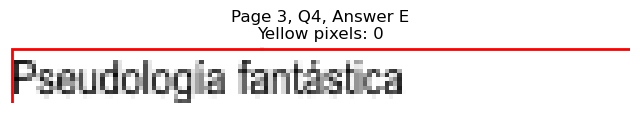


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.5, y0=501.7, x1=138.6, y1=514.3
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 283
Page 3, Q5, A: Yellow percentage: 0.0%


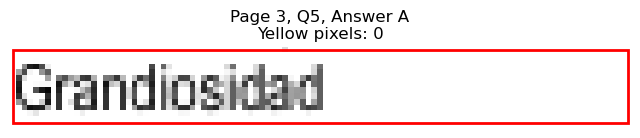

Page 3, Q5 - B: Detected box: x0=82.5, y0=514.3, x1=126.1, y1=526.9
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 203
Page 3, Q5, B: Yellow percentage: 0.0%


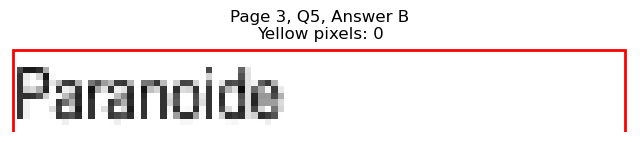

Page 3, Q5 - C: Detected box: x0=82.9, y0=526.9, x1=140.2, y1=539.5
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 285
Page 3, Q5, C: Yellow percentage: 0.0%


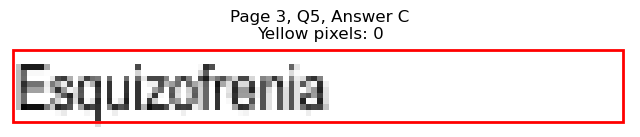

Page 3, Q5 - D: Detected box: x0=334.6, y0=501.7, x1=386.8, y1=514.3
Page 3, Q5, D: Yellow pixels: 103
Page 3, Q5, D: Total non-white pixels: 379
Page 3, Q5, D: Yellow percentage: 27.2%


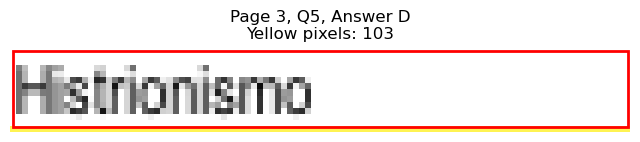

Page 3, Q5 - E: Detected box: x0=334.1, y0=514.3, x1=383.3, y1=526.9
Page 3, Q5, E: Yellow pixels: 1113
Page 3, Q5, E: Total non-white pixels: 1300
Page 3, Q5, E: Yellow percentage: 85.6%


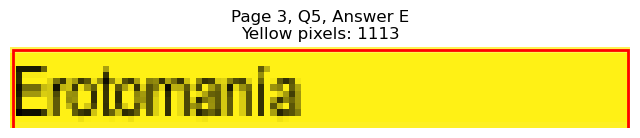


Page 3, Q5 - Selected Answer: E (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.5, y0=577.4, x1=125.1, y1=590.0
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 212
Page 3, Q6, A: Yellow percentage: 0.0%


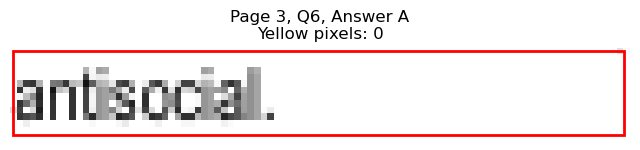

Page 3, Q6 - B: Detected box: x0=82.5, y0=590.0, x1=114.6, y1=602.6
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 139
Page 3, Q6, B: Yellow percentage: 0.0%


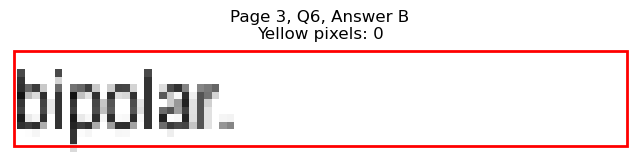

Page 3, Q6 - C: Detected box: x0=82.9, y0=602.6, x1=126.0, y1=615.2
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 217
Page 3, Q6, C: Yellow percentage: 0.0%


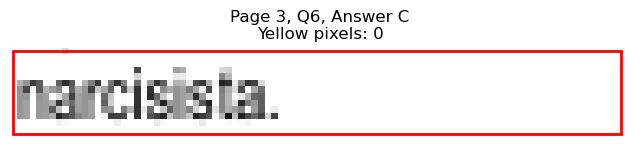

Page 3, Q6 - D: Detected box: x0=334.6, y0=577.4, x1=384.8, y1=590.0
Page 3, Q6, D: Yellow pixels: 101
Page 3, Q6, D: Total non-white pixels: 443
Page 3, Q6, D: Yellow percentage: 22.8%


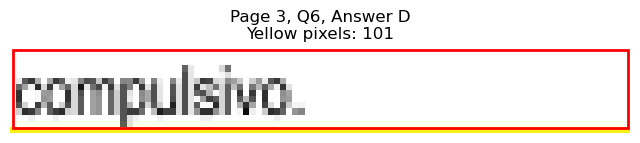

Page 3, Q6 - E: Detected box: x0=334.1, y0=590.0, x1=379.7, y1=602.6
Page 3, Q6, E: Yellow pixels: 1060
Page 3, Q6, E: Total non-white pixels: 1344
Page 3, Q6, E: Yellow percentage: 78.9%


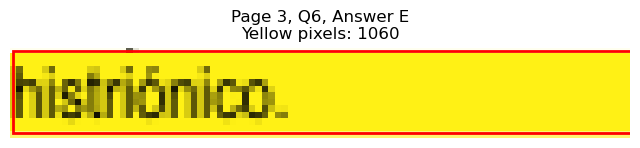


Page 3, Q6 - Selected Answer: E (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.5, y0=678.3, x1=142.1, y1=691.0
Page 3, Q7, A: Yellow pixels: 1199
Page 3, Q7, A: Total non-white pixels: 1443
Page 3, Q7, A: Yellow percentage: 83.1%


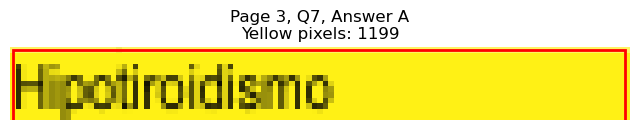

Page 3, Q7 - B: Detected box: x0=82.5, y0=691.1, x1=125.1, y1=703.7
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 300
Page 3, Q7, B: Yellow percentage: 0.0%


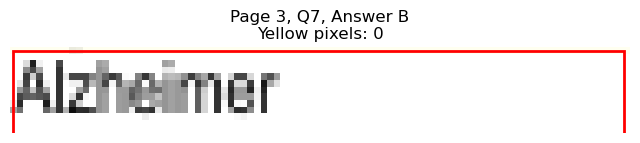

Page 3, Q7 - C: Detected box: x0=82.9, y0=703.7, x1=160.7, y1=716.3
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 404
Page 3, Q7, C: Yellow percentage: 0.0%


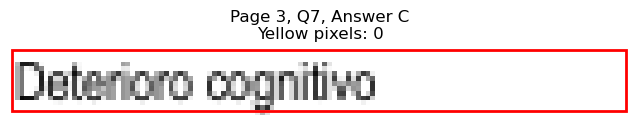

Page 3, Q7 - D: Detected box: x0=334.6, y0=678.3, x1=372.8, y1=691.0
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 204
Page 3, Q7, D: Yellow percentage: 0.0%


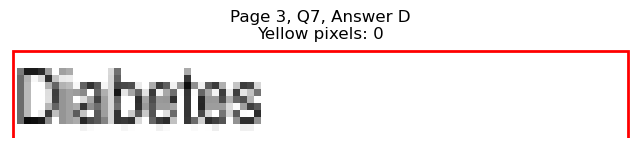

Page 3, Q7 - E: Detected box: x0=334.1, y0=691.1, x1=368.7, y1=703.7
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 184
Page 3, Q7, E: Yellow percentage: 0.0%


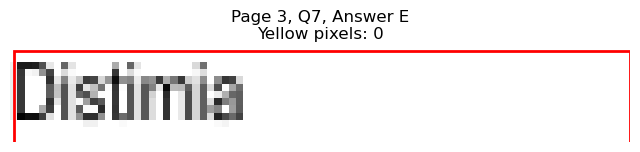


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=137.2, y1=754.1
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 288
Page 3, Q8, A: Yellow percentage: 0.0%


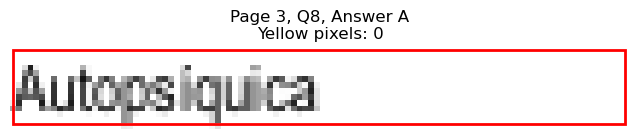

Page 3, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=122.1, y1=766.7
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 198
Page 3, Q8, B: Yellow percentage: 0.0%


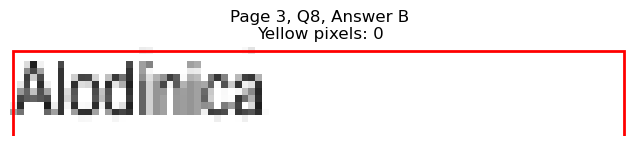

Page 3, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=132.1, y1=779.4
Page 3, Q8, C: Yellow pixels: 991
Page 3, Q8, C: Total non-white pixels: 1414
Page 3, Q8, C: Yellow percentage: 70.1%


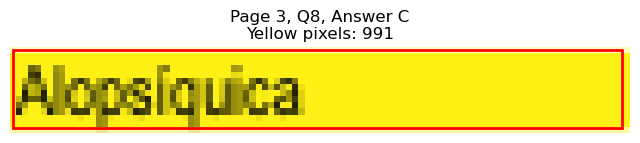

Page 3, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=372.8, y1=754.1
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 192
Page 3, Q8, D: Yellow percentage: 0.0%


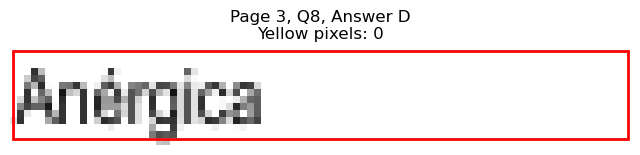

Page 3, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=378.4, y1=766.7
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 264
Page 3, Q8, E: Yellow percentage: 0.0%


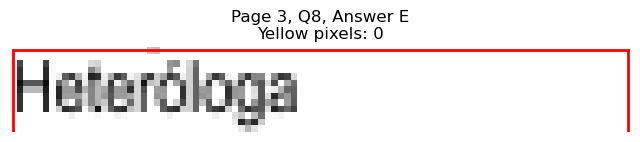


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)





Page 4: Found 8 questions
Page 4, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=132.1, y1=123.0
Page 4, Q1, A: Yellow pixels: 1130
Page 4, Q1, A: Total non-white pixels: 1313
Page 4, Q1, A: Yellow percentage: 86.1%


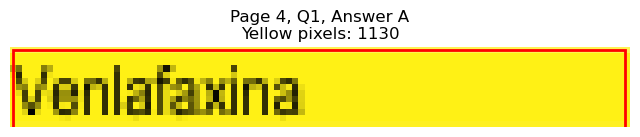

Page 4, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=126.6, y1=135.6
Page 4, Q1, B: Yellow pixels: 95
Page 4, Q1, B: Total non-white pixels: 328
Page 4, Q1, B: Yellow percentage: 29.0%


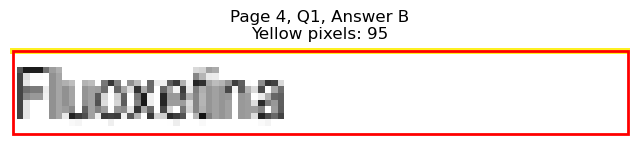

Page 4, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=136.1, y1=148.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 252
Page 4, Q1, C: Yellow percentage: 0.0%


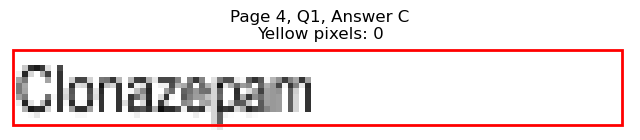

Page 4, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=389.3, y1=123.0
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 295
Page 4, Q1, D: Yellow percentage: 0.0%


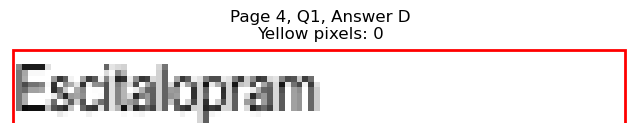

Page 4, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=375.3, y1=135.6
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 223
Page 4, Q1, E: Yellow percentage: 0.0%


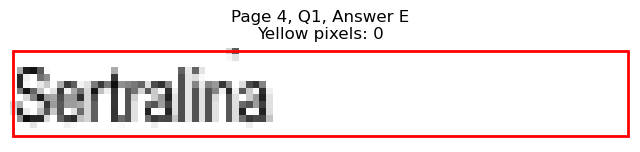


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=179.3, y1=198.7
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 497
Page 4, Q2, A: Yellow percentage: 0.0%


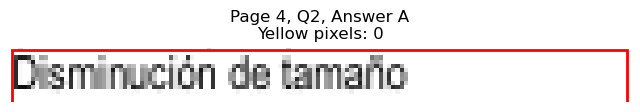

Page 4, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=167.7, y1=211.3
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 463
Page 4, Q2, B: Yellow percentage: 0.0%


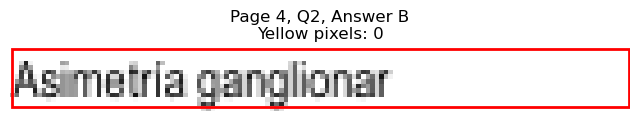

Page 4, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=169.7, y1=224.0
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 448
Page 4, Q2, C: Yellow percentage: 0.0%


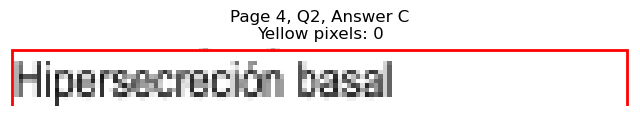

Page 4, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=440.5, y1=198.7
Page 4, Q2, D: Yellow pixels: 1625
Page 4, Q2, D: Total non-white pixels: 2041
Page 4, Q2, D: Yellow percentage: 79.6%


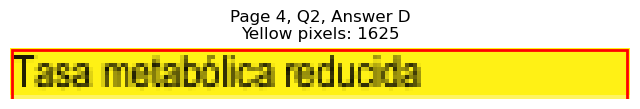

Page 4, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=432.4, y1=211.3
Page 4, Q2, E: Yellow pixels: 149
Page 4, Q2, E: Total non-white pixels: 645
Page 4, Q2, E: Yellow percentage: 23.1%


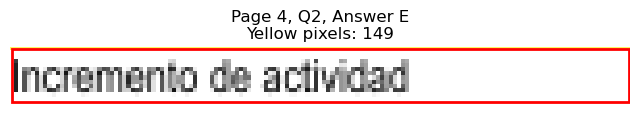


Page 4, Q2 - Selected Answer: D (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.5, y0=299.7, x1=134.7, y1=312.3
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 266
Page 4, Q3, A: Yellow percentage: 0.0%


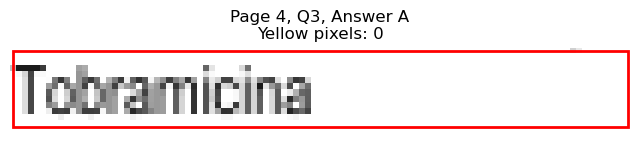

Page 4, Q3 - B: Detected box: x0=82.5, y0=312.3, x1=137.7, y1=324.9
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 293
Page 4, Q3, B: Yellow percentage: 0.0%


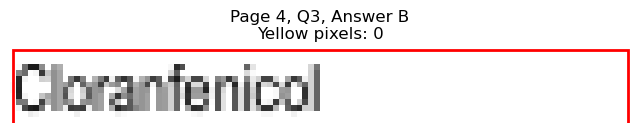

Page 4, Q3 - C: Detected box: x0=82.9, y0=324.9, x1=130.1, y1=337.5
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 230
Page 4, Q3, C: Yellow percentage: 0.0%


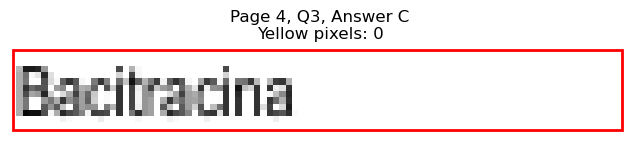

Page 4, Q3 - D: Detected box: x0=334.6, y0=299.7, x1=388.7, y1=312.3
Page 4, Q3, D: Yellow pixels: 105
Page 4, Q3, D: Total non-white pixels: 373
Page 4, Q3, D: Yellow percentage: 28.2%


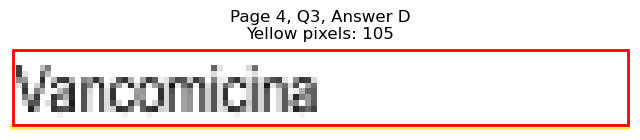

Page 4, Q3 - E: Detected box: x0=334.1, y0=312.3, x1=385.7, y1=324.9
Page 4, Q3, E: Yellow pixels: 1123
Page 4, Q3, E: Total non-white pixels: 1326
Page 4, Q3, E: Yellow percentage: 84.7%


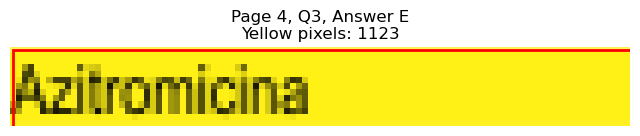


Page 4, Q3 - Selected Answer: E (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.5, y0=362.8, x1=122.1, y1=375.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 194
Page 4, Q4, A: Yellow percentage: 0.0%


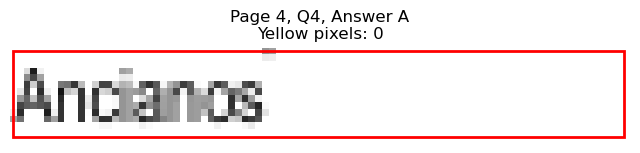

Page 4, Q4 - B: Detected box: x0=82.5, y0=375.4, x1=118.6, y1=388.1
Page 4, Q4, B: Yellow pixels: 87
Page 4, Q4, B: Total non-white pixels: 252
Page 4, Q4, B: Yellow percentage: 34.5%


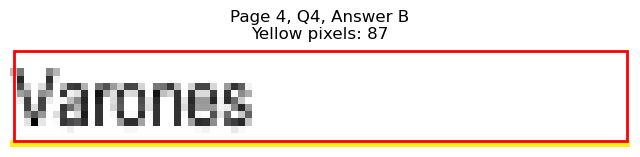

Page 4, Q4 - C: Detected box: x0=82.9, y0=388.0, x1=139.6, y1=400.7
Page 4, Q4, C: Yellow pixels: 1156
Page 4, Q4, C: Total non-white pixels: 1404
Page 4, Q4, C: Yellow percentage: 82.3%


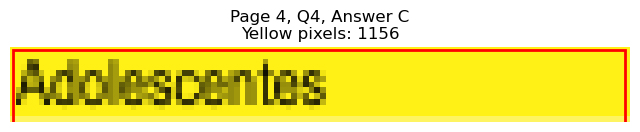

Page 4, Q4 - D: Detected box: x0=334.6, y0=362.8, x1=370.7, y1=375.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 202
Page 4, Q4, D: Yellow percentage: 0.0%


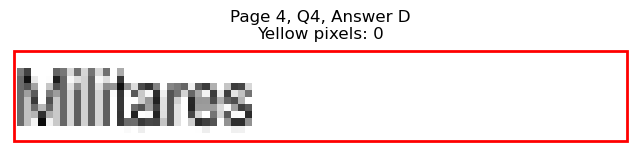

Page 4, Q4 - E: Detected box: x0=334.1, y0=375.4, x1=392.3, y1=388.1
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 322
Page 4, Q4, E: Yellow percentage: 0.0%


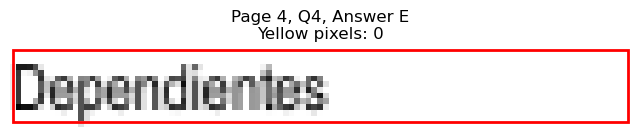


Page 4, Q4 - Selected Answer: C (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=138.1, y1=463.8
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 304
Page 4, Q5, A: Yellow percentage: 0.0%


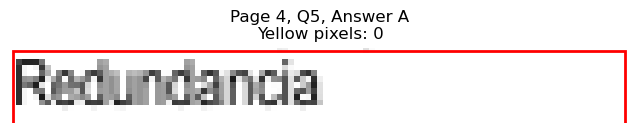

Page 4, Q5 - B: Detected box: x0=82.5, y0=463.7, x1=120.0, y1=476.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 189
Page 4, Q5, B: Yellow percentage: 0.0%


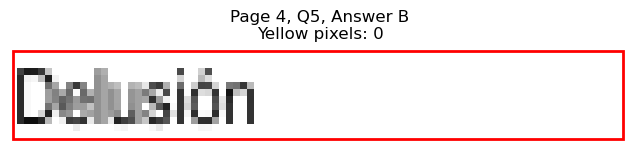

Page 4, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=118.6, y1=489.0
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 195
Page 4, Q5, C: Yellow percentage: 0.0%


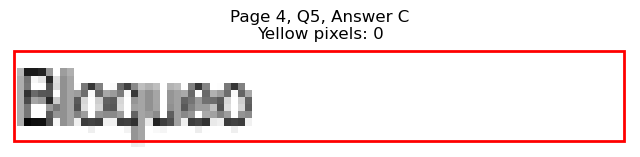

Page 4, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=375.3, y1=463.8
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 308
Page 4, Q5, D: Yellow percentage: 0.0%


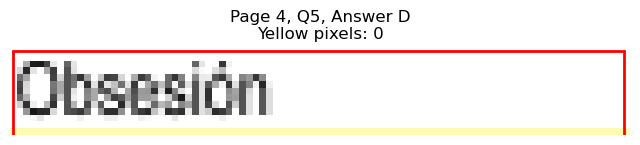

Page 4, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=374.8, y1=476.4
Page 4, Q5, E: Yellow pixels: 947
Page 4, Q5, E: Total non-white pixels: 1274
Page 4, Q5, E: Yellow percentage: 74.3%


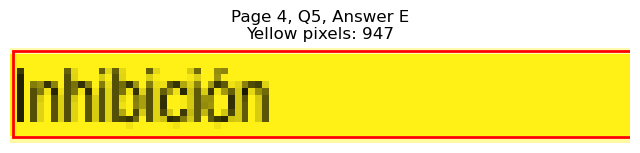


Page 4, Q5 - Selected Answer: E (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.5, y0=577.4, x1=123.6, y1=590.0
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 218
Page 4, Q6, A: Yellow percentage: 0.0%


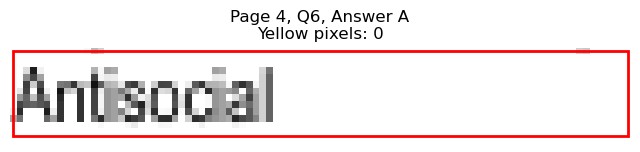

Page 4, Q6 - B: Detected box: x0=82.5, y0=590.0, x1=136.1, y1=602.6
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 291
Page 4, Q6, B: Yellow percentage: 0.0%


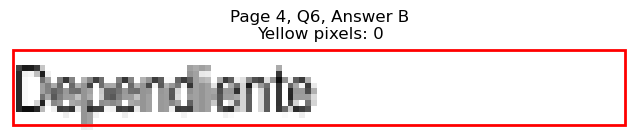

Page 4, Q6 - C: Detected box: x0=82.9, y0=602.6, x1=119.5, y1=615.2
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 185
Page 4, Q6, C: Yellow percentage: 0.0%


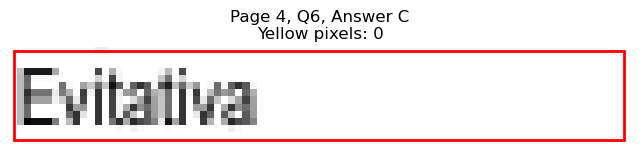

Page 4, Q6 - D: Detected box: x0=334.6, y0=577.4, x1=378.3, y1=590.0
Page 4, Q6, D: Yellow pixels: 95
Page 4, Q6, D: Total non-white pixels: 414
Page 4, Q6, D: Yellow percentage: 22.9%


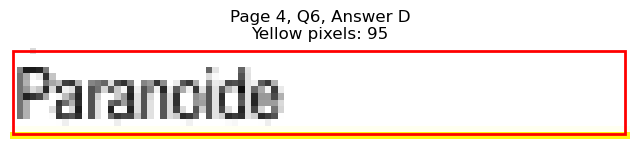

Page 4, Q6 - E: Detected box: x0=334.1, y0=590.0, x1=376.3, y1=602.6
Page 4, Q6, E: Yellow pixels: 1051
Page 4, Q6, E: Total non-white pixels: 1302
Page 4, Q6, E: Yellow percentage: 80.7%


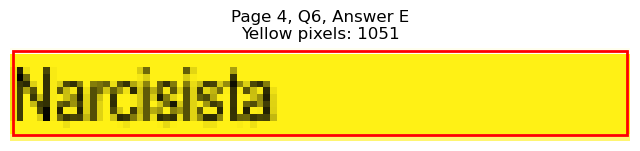


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.5, y0=653.1, x1=110.1, y1=665.8
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 219
Page 4, Q7, A: Yellow percentage: 0.0%


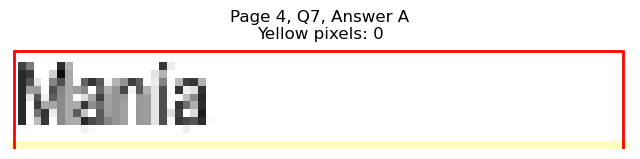

Page 4, Q7 - B: Detected box: x0=82.5, y0=665.7, x1=126.1, y1=678.4
Page 4, Q7, B: Yellow pixels: 961
Page 4, Q7, B: Total non-white pixels: 1330
Page 4, Q7, B: Yellow percentage: 72.3%


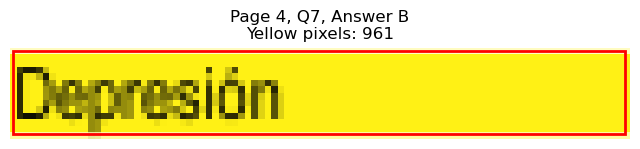

Page 4, Q7 - C: Detected box: x0=82.9, y0=678.3, x1=142.6, y1=691.0
Page 4, Q7, C: Yellow pixels: 1
Page 4, Q7, C: Total non-white pixels: 428
Page 4, Q7, C: Yellow percentage: 0.2%


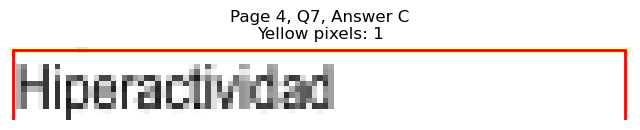

Page 4, Q7 - D: Detected box: x0=334.6, y0=653.1, x1=364.7, y1=665.8
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 147
Page 4, Q7, D: Yellow percentage: 0.0%


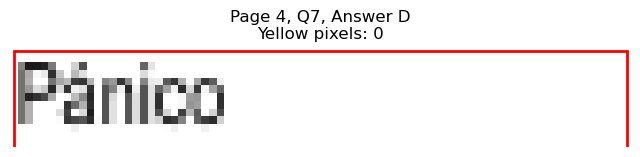

Page 4, Q7 - E: Detected box: x0=334.1, y0=665.7, x1=369.8, y1=678.4
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 186
Page 4, Q7, E: Yellow percentage: 0.0%


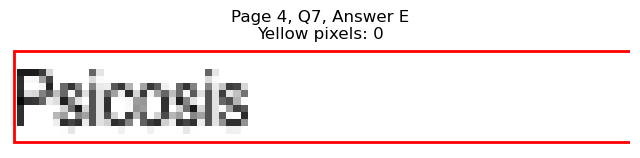


Page 4, Q7 - Selected Answer: B (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=116.5, y1=754.1
Page 4, Q8, A: Yellow pixels: 85
Page 4, Q8, A: Total non-white pixels: 258
Page 4, Q8, A: Yellow percentage: 32.9%


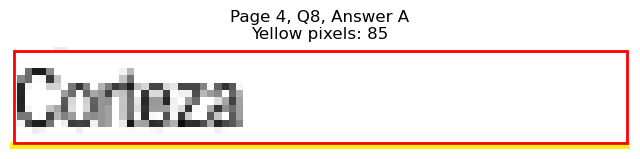

Page 4, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=130.6, y1=766.7
Page 4, Q8, B: Yellow pixels: 1085
Page 4, Q8, B: Total non-white pixels: 1287
Page 4, Q8, B: Yellow percentage: 84.3%


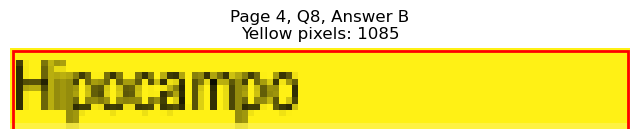

Page 4, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=108.6, y1=779.4
Page 4, Q8, C: Yellow pixels: 77
Page 4, Q8, C: Total non-white pixels: 217
Page 4, Q8, C: Yellow percentage: 35.5%


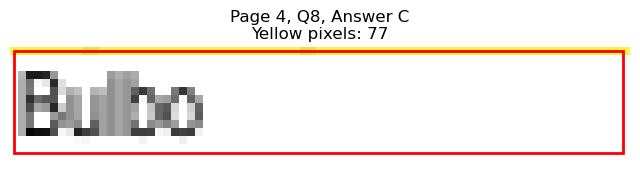

Page 4, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=373.7, y1=754.1
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 204
Page 4, Q8, D: Yellow percentage: 0.0%


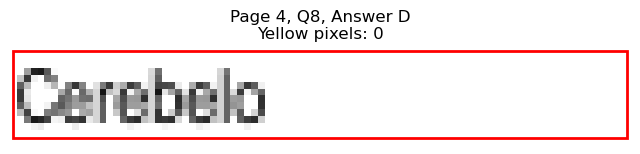

Page 4, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=367.7, y1=766.7
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 177
Page 4, Q8, E: Yellow percentage: 0.0%


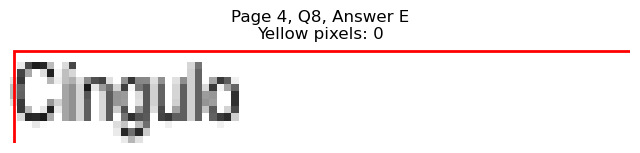


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=152.7, y1=123.0
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 380
Page 5, Q1, A: Yellow percentage: 0.0%


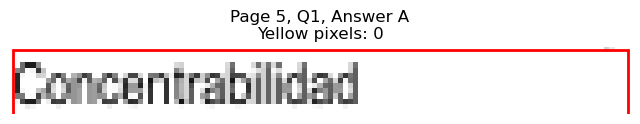

Page 5, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=137.2, y1=135.6
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 283
Page 5, Q1, B: Yellow percentage: 0.0%


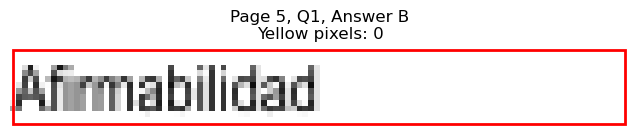

Page 5, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=130.6, y1=148.2
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 280
Page 5, Q1, C: Yellow percentage: 0.0%


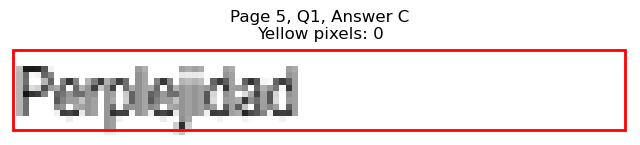

Page 5, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=393.3, y1=123.0
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 448
Page 5, Q1, D: Yellow percentage: 0.0%


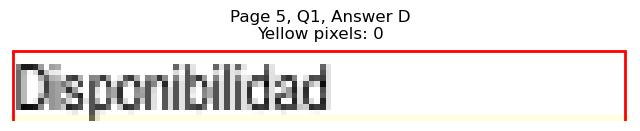

Page 5, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=387.9, y1=135.6
Page 5, Q1, E: Yellow pixels: 1100
Page 5, Q1, E: Total non-white pixels: 1456
Page 5, Q1, E: Yellow percentage: 75.5%


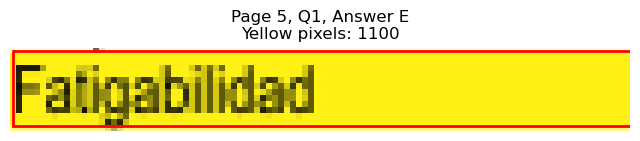


Page 5, Q1 - Selected Answer: E (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.5, y0=173.4, x1=137.7, y1=186.1
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 293
Page 5, Q2, A: Yellow percentage: 0.0%


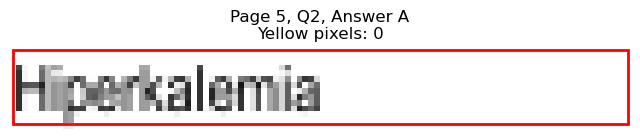

Page 5, Q2 - B: Detected box: x0=82.5, y0=186.0, x1=145.1, y1=198.7
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 353
Page 5, Q2, B: Yellow percentage: 0.0%


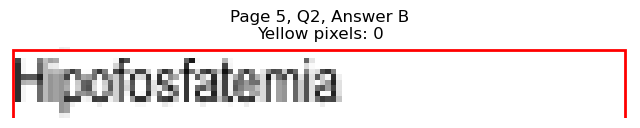

Page 5, Q2 - C: Detected box: x0=82.9, y0=198.6, x1=119.1, y1=211.3
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 182
Page 5, Q2, C: Yellow percentage: 0.0%


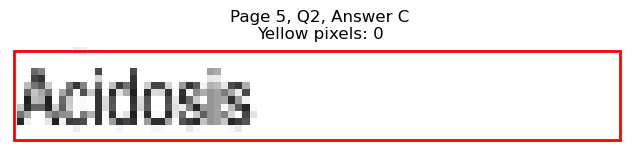

Page 5, Q2 - D: Detected box: x0=334.6, y0=173.4, x1=394.3, y1=186.1
Page 5, Q2, D: Yellow pixels: 111
Page 5, Q2, D: Total non-white pixels: 438
Page 5, Q2, D: Yellow percentage: 25.3%


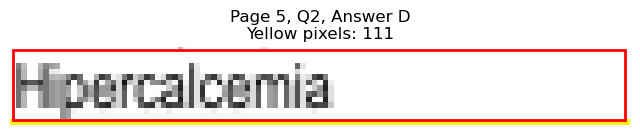

Page 5, Q2 - E: Detected box: x0=334.1, y0=186.0, x1=390.3, y1=198.7
Page 5, Q2, E: Yellow pixels: 1175
Page 5, Q2, E: Total non-white pixels: 1391
Page 5, Q2, E: Yellow percentage: 84.5%


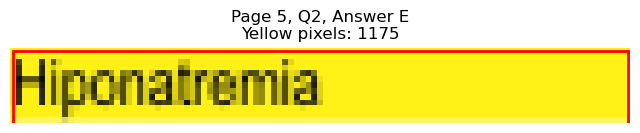


Page 5, Q2 - Selected Answer: E (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.5, y0=249.1, x1=152.7, y1=261.8
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 366
Page 5, Q3, A: Yellow percentage: 0.0%


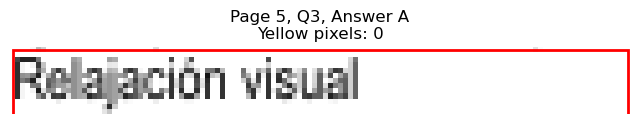

Page 5, Q3 - B: Detected box: x0=82.5, y0=261.7, x1=183.7, y1=274.4
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 530
Page 5, Q3, B: Yellow percentage: 0.0%


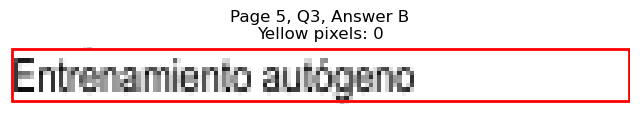

Page 5, Q3 - C: Detected box: x0=82.9, y0=274.5, x1=189.7, y1=287.1
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 571
Page 5, Q3, C: Yellow percentage: 0.0%


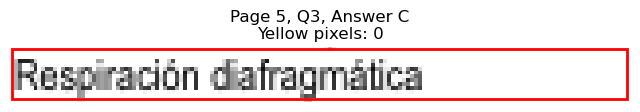

Page 5, Q3 - D: Detected box: x0=334.6, y0=249.1, x1=432.4, y1=261.8
Page 5, Q3, D: Yellow pixels: 1
Page 5, Q3, D: Total non-white pixels: 667
Page 5, Q3, D: Yellow percentage: 0.1%


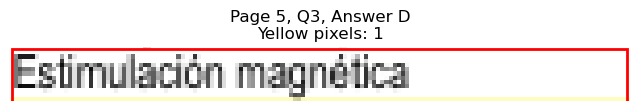

Page 5, Q3 - E: Detected box: x0=334.1, y0=261.7, x1=398.8, y1=274.4
Page 5, Q3, E: Yellow pixels: 1247
Page 5, Q3, E: Total non-white pixels: 1610
Page 5, Q3, E: Yellow percentage: 77.5%


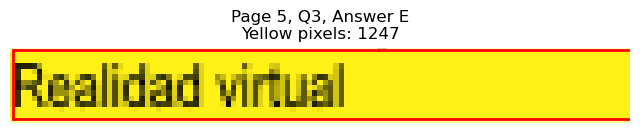


Page 5, Q3 - Selected Answer: E (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=82.5, y0=362.8, x1=173.8, y1=375.5
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 487
Page 5, Q4, A: Yellow percentage: 0.0%


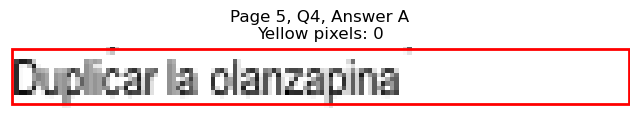

Page 5, Q4 - B: Detected box: x0=82.5, y0=375.4, x1=180.7, y1=388.1
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 497
Page 5, Q4, B: Yellow percentage: 0.0%


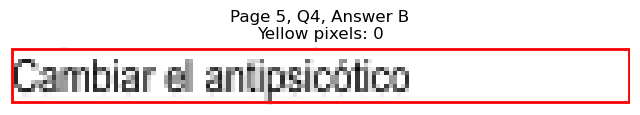

Page 5, Q4 - C: Detected box: x0=82.9, y0=388.0, x1=181.7, y1=400.7
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 537
Page 5, Q4, C: Yellow percentage: 0.0%


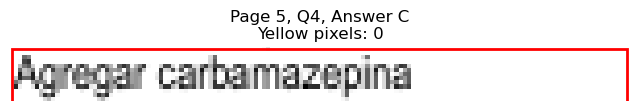

Page 5, Q4 - D: Detected box: x0=334.6, y0=362.8, x1=407.3, y1=375.5
Page 5, Q4, D: Yellow pixels: 124
Page 5, Q4, D: Total non-white pixels: 481
Page 5, Q4, D: Yellow percentage: 25.8%


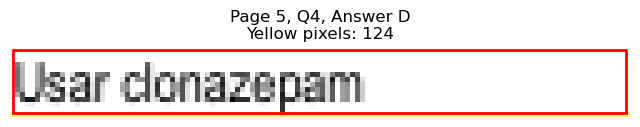

Page 5, Q4 - E: Detected box: x0=334.1, y0=375.4, x1=427.4, y1=388.1
Page 5, Q4, E: Yellow pixels: 1493
Page 5, Q4, E: Total non-white pixels: 2016
Page 5, Q4, E: Yellow percentage: 74.1%


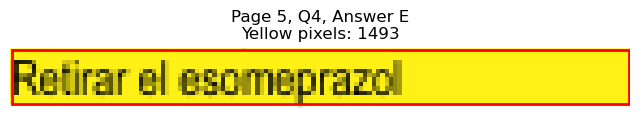


Page 5, Q4 - Selected Answer: E (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.5, y0=438.5, x1=95.1, y1=451.2
Page 5, Q5, A: Yellow pixels: 64
Page 5, Q5, A: Total non-white pixels: 127
Page 5, Q5, A: Yellow percentage: 50.4%


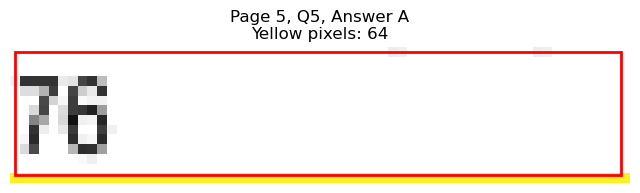

Page 5, Q5 - B: Detected box: x0=82.5, y0=451.1, x1=100.1, y1=463.8
Page 5, Q5, B: Yellow pixels: 843
Page 5, Q5, B: Total non-white pixels: 897
Page 5, Q5, B: Yellow percentage: 94.0%


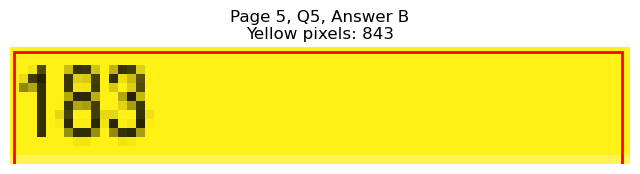

Page 5, Q5 - C: Detected box: x0=82.9, y0=463.7, x1=100.5, y1=476.4
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 81
Page 5, Q5, C: Yellow percentage: 0.0%


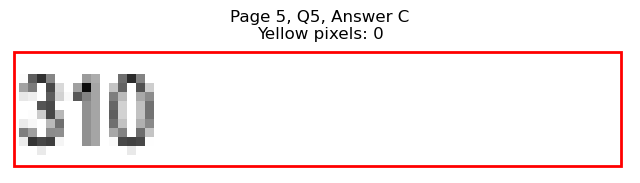

Page 5, Q5 - D: Detected box: x0=334.6, y0=438.5, x1=352.1, y1=451.2
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 91
Page 5, Q5, D: Yellow percentage: 0.0%


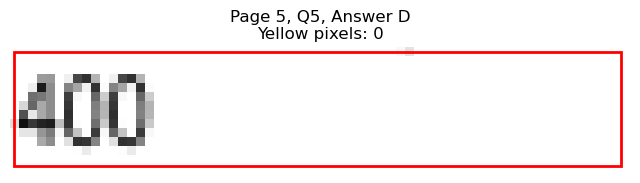

Page 5, Q5 - E: Detected box: x0=334.1, y0=451.1, x1=351.7, y1=463.8
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 97
Page 5, Q5, E: Yellow percentage: 0.0%


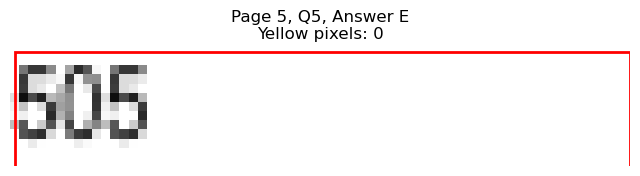


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.5, y0=501.7, x1=123.6, y1=514.3
Page 5, Q6, A: Yellow pixels: 934
Page 5, Q6, A: Total non-white pixels: 1288
Page 5, Q6, A: Yellow percentage: 72.5%


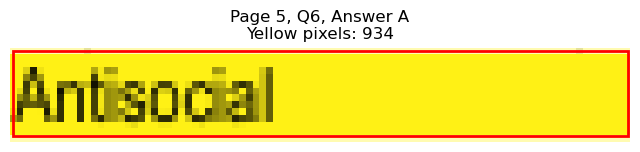

Page 5, Q6 - B: Detected box: x0=82.5, y0=514.3, x1=127.1, y1=526.9
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 338
Page 5, Q6, B: Yellow percentage: 0.0%


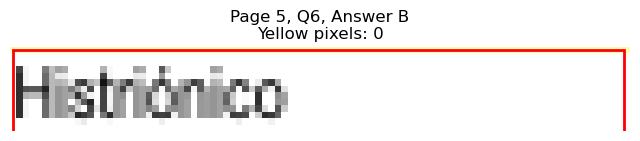

Page 5, Q6 - C: Detected box: x0=82.9, y0=526.9, x1=126.6, y1=539.5
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 229
Page 5, Q6, C: Yellow percentage: 0.0%


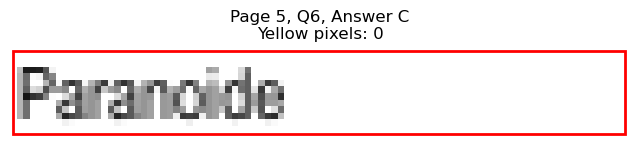

Page 5, Q6 - D: Detected box: x0=334.6, y0=501.7, x1=386.3, y1=514.3
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 261
Page 5, Q6, D: Yellow percentage: 0.0%


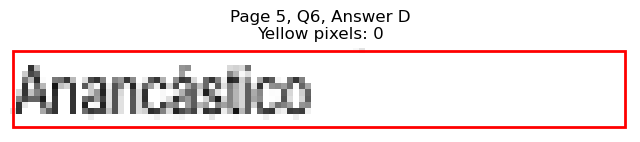

Page 5, Q6 - E: Detected box: x0=334.1, y0=514.3, x1=370.7, y1=526.9
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 188
Page 5, Q6, E: Yellow percentage: 0.0%


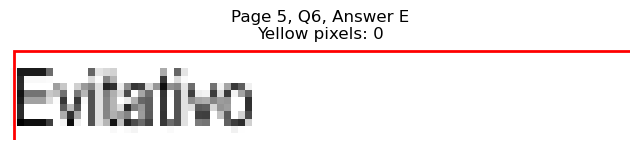


Page 5, Q6 - Selected Answer: A (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.5, y0=564.8, x1=135.1, y1=577.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 266
Page 5, Q7, A: Yellow percentage: 0.0%


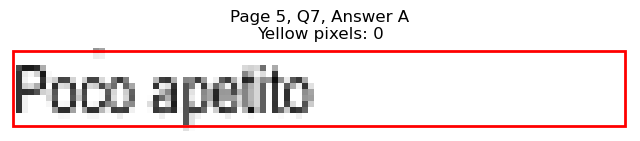

Page 5, Q7 - B: Detected box: x0=82.5, y0=577.4, x1=129.1, y1=590.0
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 225
Page 5, Q7, B: Yellow percentage: 0.0%


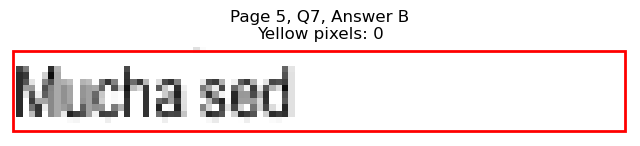

Page 5, Q7 - C: Detected box: x0=82.9, y0=590.0, x1=168.3, y1=602.6
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 424
Page 5, Q7, C: Yellow percentage: 0.0%


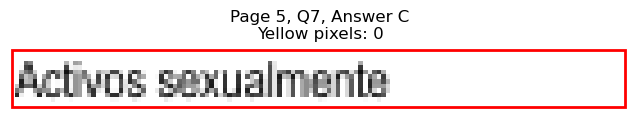

Page 5, Q7 - D: Detected box: x0=334.6, y0=564.8, x1=425.9, y1=577.4
Page 5, Q7, D: Yellow pixels: 1348
Page 5, Q7, D: Total non-white pixels: 1988
Page 5, Q7, D: Yellow percentage: 67.8%


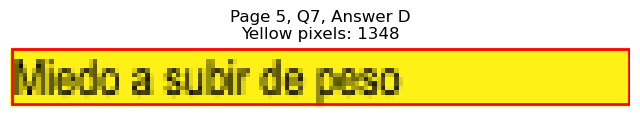

Page 5, Q7 - E: Detected box: x0=334.1, y0=577.4, x1=414.4, y1=590.0
Page 5, Q7, E: Yellow pixels: 1
Page 5, Q7, E: Total non-white pixels: 533
Page 5, Q7, E: Yellow percentage: 0.2%


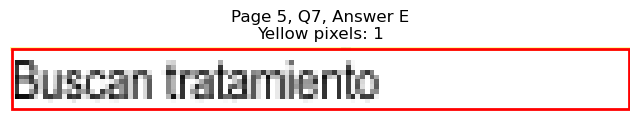


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.5, y0=627.9, x1=164.2, y1=640.6
Page 5, Q8, A: Yellow pixels: 1387
Page 5, Q8, A: Total non-white pixels: 1862
Page 5, Q8, A: Yellow percentage: 74.5%


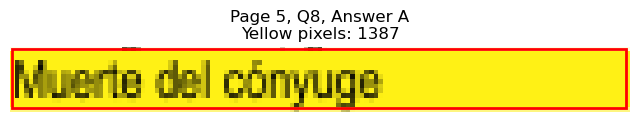

Page 5, Q8 - B: Detected box: x0=82.5, y0=640.5, x1=150.6, y1=653.2
Page 5, Q8, B: Yellow pixels: 116
Page 5, Q8, B: Total non-white pixels: 459
Page 5, Q8, B: Yellow percentage: 25.3%


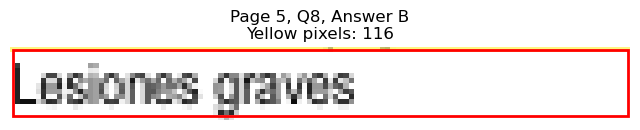

Page 5, Q8 - C: Detected box: x0=82.9, y0=653.1, x1=166.7, y1=665.8
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 434
Page 5, Q8, C: Yellow percentage: 0.0%


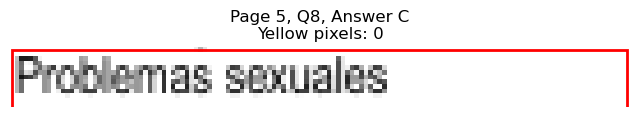

Page 5, Q8 - D: Detected box: x0=334.6, y0=627.9, x1=399.8, y1=640.6
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 340
Page 5, Q8, D: Yellow percentage: 0.0%


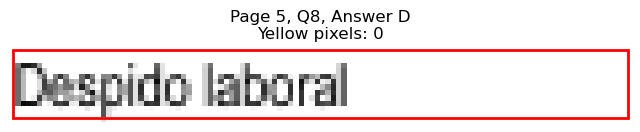

Page 5, Q8 - E: Detected box: x0=334.1, y0=640.5, x1=417.9, y1=653.2
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 417
Page 5, Q8, E: Yellow percentage: 0.0%


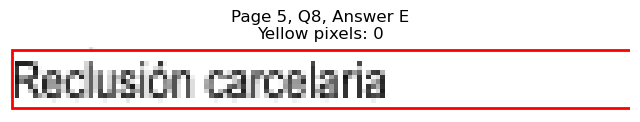


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=82.5, y0=716.3, x1=135.6, y1=728.9
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 268
Page 5, Q9, A: Yellow percentage: 0.0%


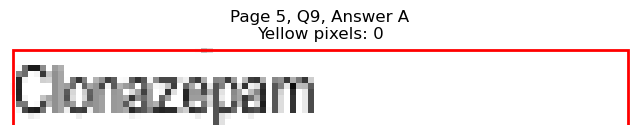

Page 5, Q9 - B: Detected box: x0=82.5, y0=728.9, x1=130.1, y1=741.5
Page 5, Q9, B: Yellow pixels: 99
Page 5, Q9, B: Total non-white pixels: 326
Page 5, Q9, B: Yellow percentage: 30.4%


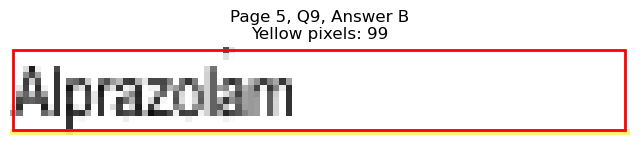

Page 5, Q9 - C: Detected box: x0=82.9, y0=741.4, x1=122.5, y1=754.1
Page 5, Q9, C: Yellow pixels: 1037
Page 5, Q9, C: Total non-white pixels: 1274
Page 5, Q9, C: Yellow percentage: 81.4%


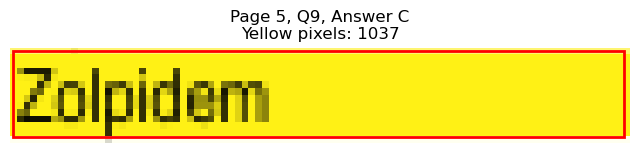

Page 5, Q9 - D: Detected box: x0=334.6, y0=716.3, x1=382.3, y1=728.9
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 231
Page 5, Q9, D: Yellow percentage: 0.0%


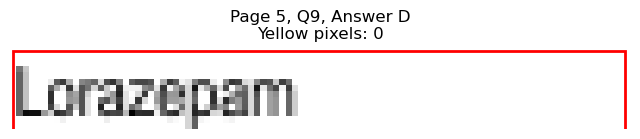

Page 5, Q9 - E: Detected box: x0=334.1, y0=728.9, x1=380.2, y1=741.5
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 259
Page 5, Q9, E: Yellow percentage: 0.0%


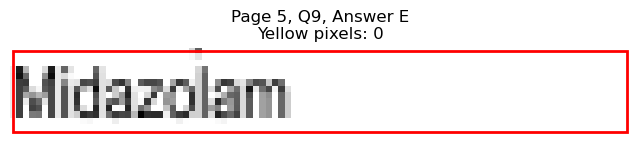


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=233.4, y1=110.4
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 793
Page 6, Q1, A: Yellow percentage: 0.0%


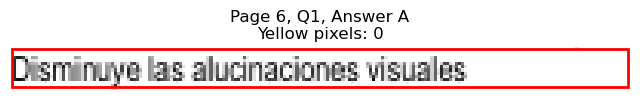

Page 6, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=215.3, y1=123.0
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 716
Page 6, Q1, B: Yellow percentage: 0.0%


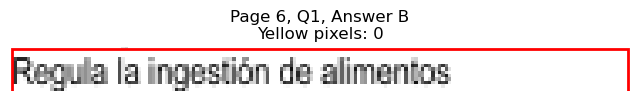

Page 6, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=197.8, y1=135.6
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 582
Page 6, Q1, C: Yellow percentage: 0.0%


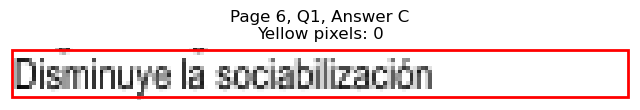

Page 6, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=505.7, y1=110.4
Page 6, Q1, D: Yellow pixels: 192
Page 6, Q1, D: Total non-white pixels: 1043
Page 6, Q1, D: Yellow percentage: 18.4%


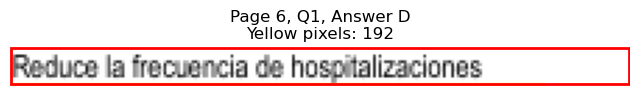

Page 6, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=498.6, y1=123.0
Page 6, Q1, E: Yellow pixels: 1868
Page 6, Q1, E: Total non-white pixels: 2496
Page 6, Q1, E: Yellow percentage: 74.8%


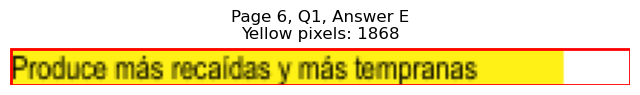


Page 6, Q1 - Selected Answer: E (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=138.6, y1=198.7
Page 6, Q2, A: Yellow pixels: 1167
Page 6, Q2, A: Total non-white pixels: 1391
Page 6, Q2, A: Yellow percentage: 83.9%


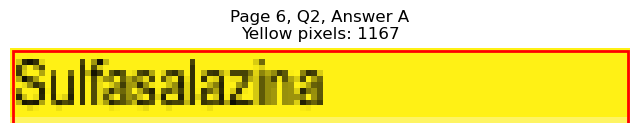

Page 6, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=117.6, y1=211.3
Page 6, Q2, B: Yellow pixels: 86
Page 6, Q2, B: Total non-white pixels: 273
Page 6, Q2, B: Yellow percentage: 31.5%


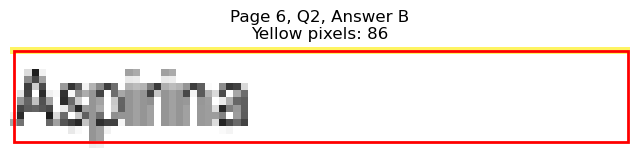

Page 6, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=129.6, y1=224.0
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 223
Page 6, Q2, C: Yellow percentage: 0.0%


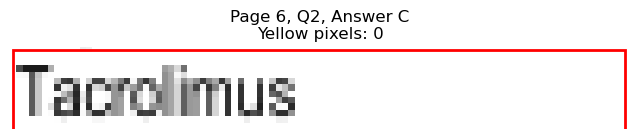

Page 6, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=387.8, y1=198.7
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 263
Page 6, Q2, D: Yellow percentage: 0.0%


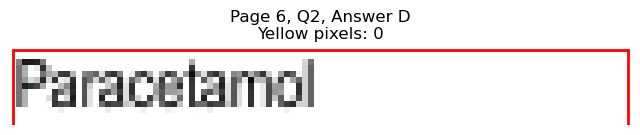

Page 6, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=382.3, y1=211.3
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 253
Page 6, Q2, E: Yellow percentage: 0.0%


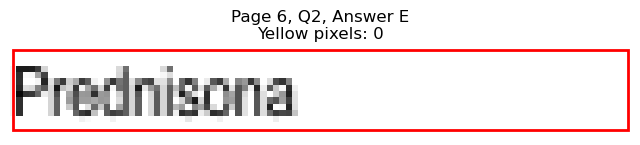


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=121.6, y1=287.1
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 223
Page 6, Q3, A: Yellow percentage: 0.0%


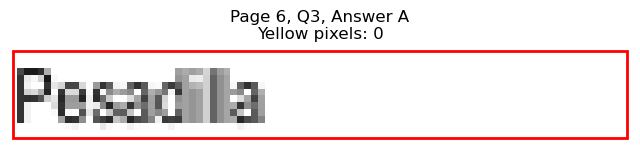

Page 6, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=154.2, y1=299.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 368
Page 6, Q3, B: Yellow percentage: 0.0%


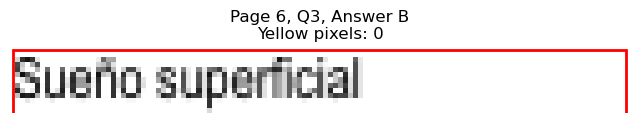

Page 6, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=125.1, y1=312.3
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 224
Page 6, Q3, C: Yellow percentage: 0.0%


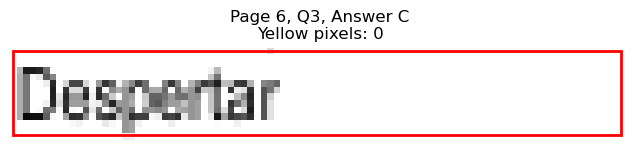

Page 6, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=385.7, y1=287.1
Page 6, Q3, D: Yellow pixels: 1121
Page 6, Q3, D: Total non-white pixels: 1428
Page 6, Q3, D: Yellow percentage: 78.5%


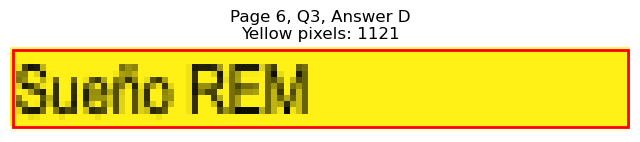

Page 6, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=359.7, y1=299.7
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 205
Page 6, Q3, E: Yellow percentage: 0.0%


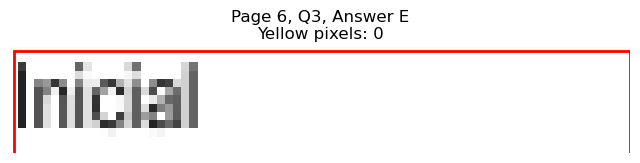


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.5, y0=337.5, x1=221.9, y1=350.1
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 692
Page 6, Q4, A: Yellow percentage: 0.0%


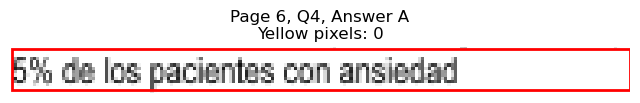

Page 6, Q4 - B: Detected box: x0=82.5, y0=350.2, x1=202.4, y1=362.9
Page 6, Q4, B: Yellow pixels: 1764
Page 6, Q4, B: Total non-white pixels: 2223
Page 6, Q4, B: Yellow percentage: 79.4%


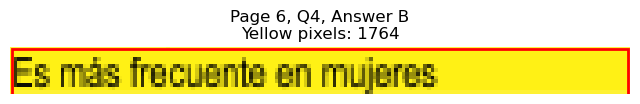

Page 6, Q4 - C: Detected box: x0=82.9, y0=362.8, x1=211.4, y1=375.5
Page 6, Q4, C: Yellow pixels: 178
Page 6, Q4, C: Total non-white pixels: 782
Page 6, Q4, C: Yellow percentage: 22.8%


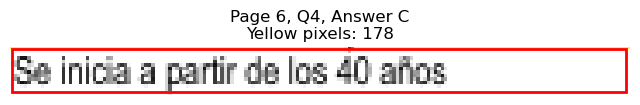

Page 6, Q4 - D: Detected box: x0=334.6, y0=337.5, x1=457.0, y1=350.1
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 578
Page 6, Q4, D: Yellow percentage: 0.0%


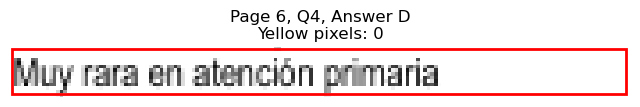

Page 6, Q4 - E: Detected box: x0=334.1, y0=350.2, x1=453.7, y1=362.9
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 560
Page 6, Q4, E: Yellow percentage: 0.0%


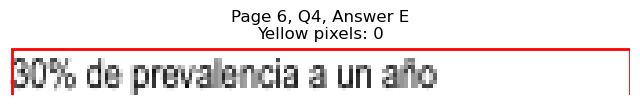


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.5, y0=413.3, x1=95.1, y1=426.0
Page 6, Q5, A: Yellow pixels: 793
Page 6, Q5, A: Total non-white pixels: 832
Page 6, Q5, A: Yellow percentage: 95.3%


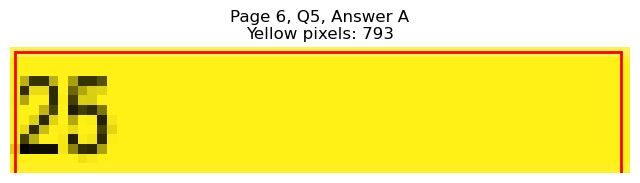

Page 6, Q5 - B: Detected box: x0=70.8, y0=425.9, x1=79.3, y1=438.6
Page 6, Q5, B: Yellow pixels: 60
Page 6, Q5, B: Total non-white pixels: 132
Page 6, Q5, B: Yellow percentage: 45.5%


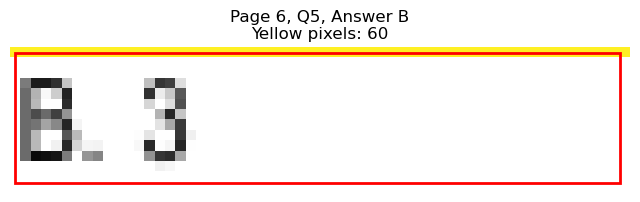

Page 6, Q5 - C: Detected box: x0=82.9, y0=438.5, x1=95.5, y1=451.2
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 57
Page 6, Q5, C: Yellow percentage: 0.0%


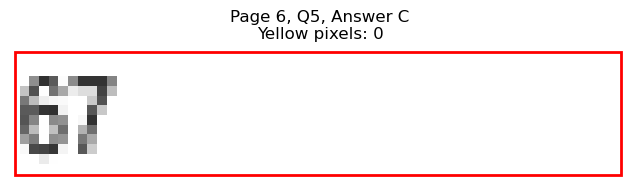

Page 6, Q5 - D: Detected box: x0=334.6, y0=413.3, x1=347.2, y1=426.0
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 38
Page 6, Q5, D: Yellow percentage: 0.0%


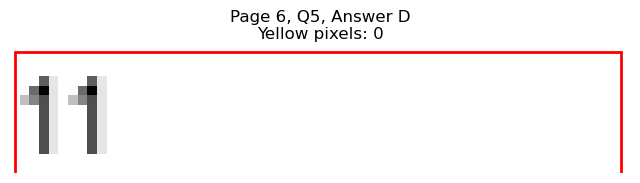

Page 6, Q5 - E: Detected box: x0=334.1, y0=425.9, x1=346.7, y1=438.6
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 51
Page 6, Q5, E: Yellow percentage: 0.0%


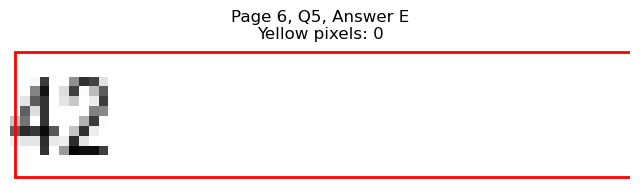


Page 6, Q5 - Selected Answer: A (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.5, y0=489.1, x1=122.5, y1=501.7
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 302
Page 6, Q6, A: Yellow percentage: 0.0%


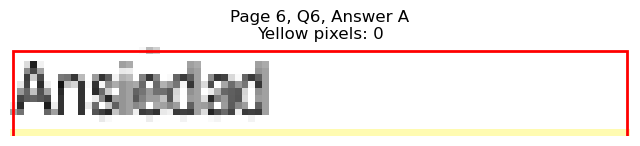

Page 6, Q6 - B: Detected box: x0=82.5, y0=501.7, x1=126.1, y1=514.3
Page 6, Q6, B: Yellow pixels: 960
Page 6, Q6, B: Total non-white pixels: 1330
Page 6, Q6, B: Yellow percentage: 72.2%


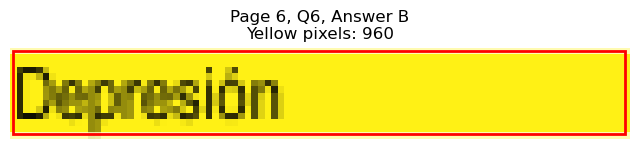

Page 6, Q6 - C: Detected box: x0=82.9, y0=514.3, x1=129.1, y1=526.9
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 348
Page 6, Q6, C: Yellow percentage: 0.0%


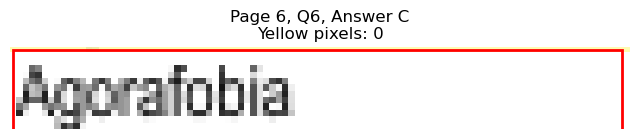

Page 6, Q6 - D: Detected box: x0=334.6, y0=489.1, x1=364.7, y1=501.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 150
Page 6, Q6, D: Yellow percentage: 0.0%


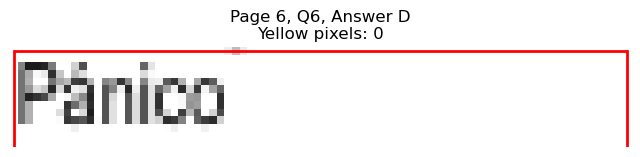

Page 6, Q6 - E: Detected box: x0=334.1, y0=501.7, x1=369.8, y1=514.3
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 186
Page 6, Q6, E: Yellow percentage: 0.0%


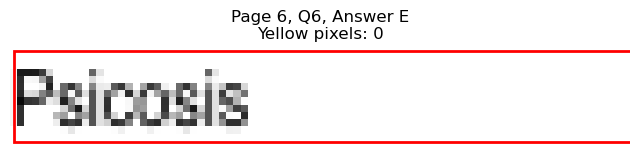


Page 6, Q6 - Selected Answer: B (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.5, y0=552.2, x1=119.5, y1=564.8
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 269
Page 6, Q7, A: Yellow percentage: 0.0%


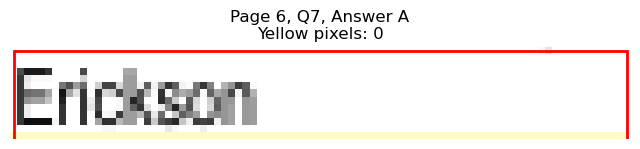

Page 6, Q7 - B: Detected box: x0=82.5, y0=564.8, x1=125.1, y1=577.4
Page 6, Q7, B: Yellow pixels: 968
Page 6, Q7, B: Total non-white pixels: 1316
Page 6, Q7, B: Yellow percentage: 73.6%


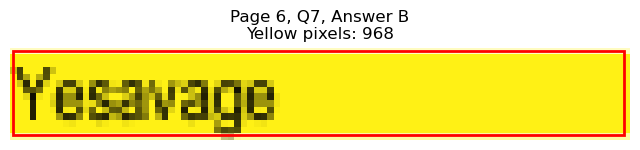

Page 6, Q7 - C: Detected box: x0=82.9, y0=577.4, x1=118.0, y1=590.0
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 263
Page 6, Q7, C: Yellow percentage: 0.0%


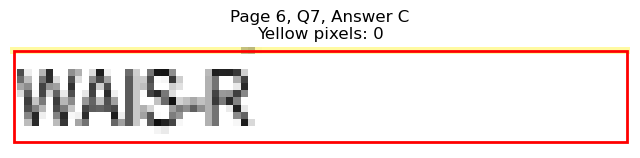

Page 6, Q7 - D: Detected box: x0=334.6, y0=552.2, x1=372.8, y1=564.8
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 206
Page 6, Q7, D: Yellow percentage: 0.0%


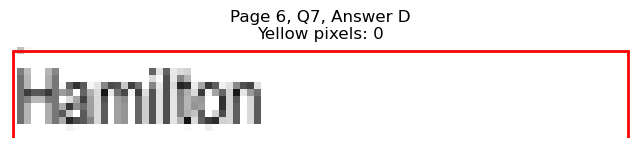

Page 6, Q7 - E: Detected box: x0=334.1, y0=564.8, x1=371.7, y1=577.4
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 209
Page 6, Q7, E: Yellow percentage: 0.0%


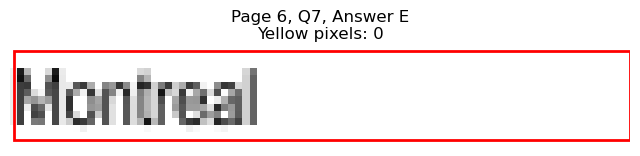


Page 6, Q7 - Selected Answer: B (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.5, y0=615.2, x1=163.7, y1=627.8
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 404
Page 6, Q8, A: Yellow percentage: 0.0%


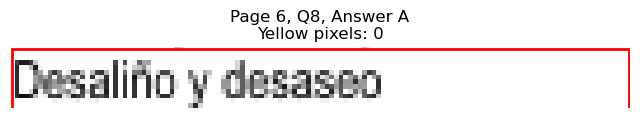

Page 6, Q8 - B: Detected box: x0=82.5, y0=627.9, x1=175.7, y1=640.6
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 457
Page 6, Q8, B: Yellow percentage: 0.0%


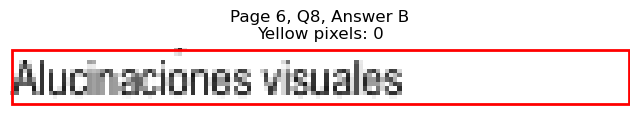

Page 6, Q8 - C: Detected box: x0=82.9, y0=640.5, x1=156.6, y1=653.2
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 372
Page 6, Q8, C: Yellow percentage: 0.0%


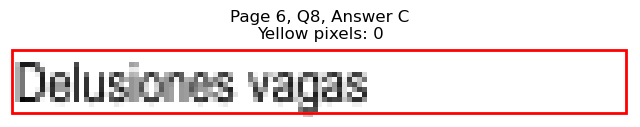

Page 6, Q8 - D: Detected box: x0=334.6, y0=615.2, x1=410.3, y1=627.8
Page 6, Q8, D: Yellow pixels: 1361
Page 6, Q8, D: Total non-white pixels: 1651
Page 6, Q8, D: Yellow percentage: 82.4%


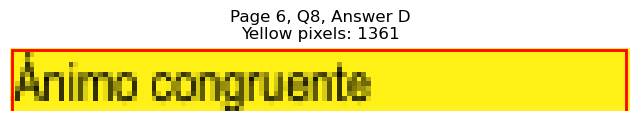

Page 6, Q8 - E: Detected box: x0=334.1, y0=627.9, x1=427.4, y1=640.6
Page 6, Q8, E: Yellow pixels: 140
Page 6, Q8, E: Total non-white pixels: 630
Page 6, Q8, E: Yellow percentage: 22.2%


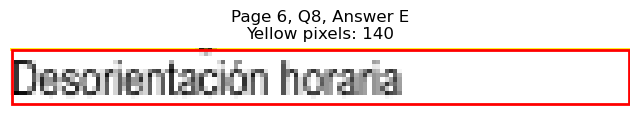


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.5, y0=691.1, x1=126.1, y1=703.7
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 230
Page 6, Q9, A: Yellow percentage: 0.0%


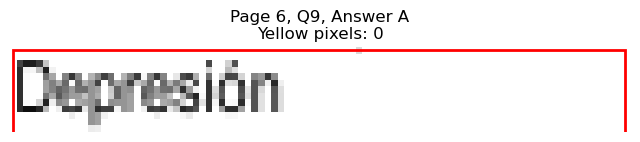

Page 6, Q9 - B: Detected box: x0=82.5, y0=703.7, x1=136.6, y1=716.3
Page 6, Q9, B: Yellow pixels: 105
Page 6, Q9, B: Total non-white pixels: 373
Page 6, Q9, B: Yellow percentage: 28.2%


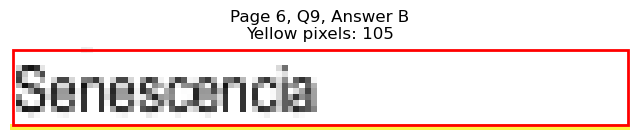

Page 6, Q9 - C: Detected box: x0=82.9, y0=716.3, x1=126.0, y1=728.9
Page 6, Q9, C: Yellow pixels: 1065
Page 6, Q9, C: Total non-white pixels: 1235
Page 6, Q9, C: Yellow percentage: 86.2%


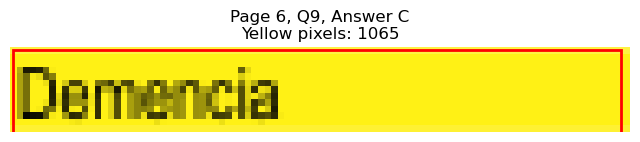

Page 6, Q9 - D: Detected box: x0=334.6, y0=691.1, x1=397.4, y1=703.7
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 327
Page 6, Q9, D: Yellow percentage: 0.0%


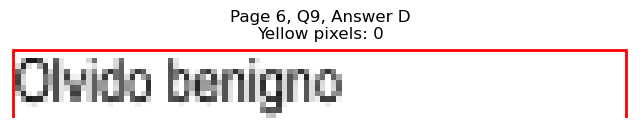

Page 6, Q9 - E: Detected box: x0=334.1, y0=703.7, x1=392.8, y1=716.3
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 304
Page 6, Q9, E: Yellow percentage: 0.0%


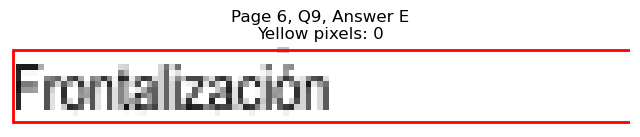


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=82.5, y0=122.9, x1=122.5, y1=135.6
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 201
Page 7, Q1, A: Yellow percentage: 0.0%


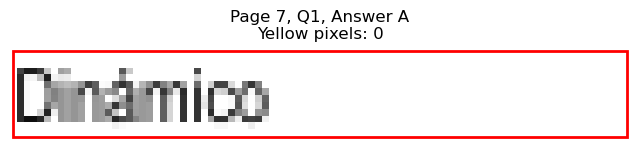

Page 7, Q1 - B: Detected box: x0=82.5, y0=135.5, x1=124.1, y1=148.2
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 217
Page 7, Q1, B: Yellow percentage: 0.0%


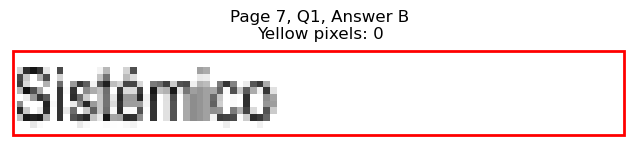

Page 7, Q1 - C: Detected box: x0=82.9, y0=148.2, x1=126.6, y1=160.9
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 211
Page 7, Q1, C: Yellow percentage: 0.0%


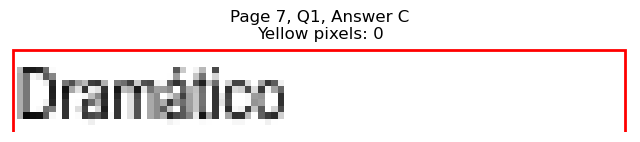

Page 7, Q1 - D: Detected box: x0=334.6, y0=122.9, x1=380.2, y1=135.6
Page 7, Q1, D: Yellow pixels: 1096
Page 7, Q1, D: Total non-white pixels: 1358
Page 7, Q1, D: Yellow percentage: 80.7%


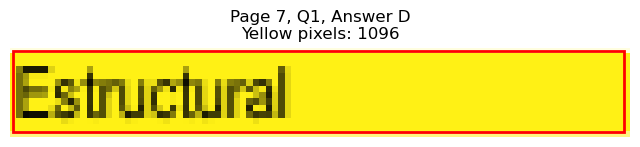

Page 7, Q1 - E: Detected box: x0=334.1, y0=135.5, x1=372.8, y1=148.2
Page 7, Q1, E: Yellow pixels: 89
Page 7, Q1, E: Total non-white pixels: 300
Page 7, Q1, E: Yellow percentage: 29.7%


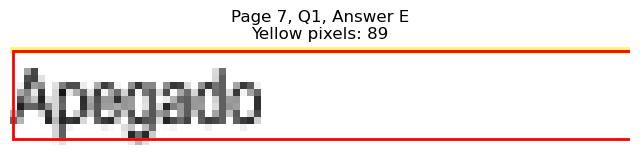


Page 7, Q1 - Selected Answer: D (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.5, y0=211.3, x1=118.6, y1=224.0
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 190
Page 7, Q2, A: Yellow percentage: 0.0%


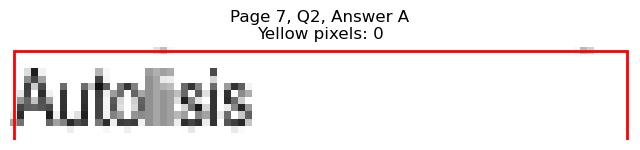

Page 7, Q2 - B: Detected box: x0=82.5, y0=223.9, x1=129.1, y1=236.6
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 244
Page 7, Q2, B: Yellow percentage: 0.0%


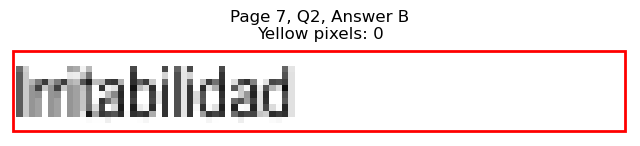

Page 7, Q2 - C: Detected box: x0=82.9, y0=236.5, x1=131.5, y1=249.2
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 244
Page 7, Q2, C: Yellow percentage: 0.0%


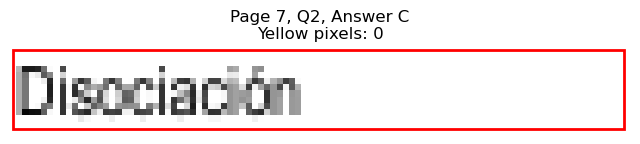

Page 7, Q2 - D: Detected box: x0=334.6, y0=211.3, x1=386.2, y1=224.0
Page 7, Q2, D: Yellow pixels: 1142
Page 7, Q2, D: Total non-white pixels: 1339
Page 7, Q2, D: Yellow percentage: 85.3%


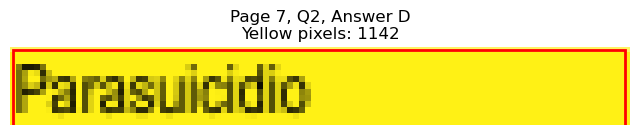

Page 7, Q2 - E: Detected box: x0=334.1, y0=223.9, x1=367.3, y1=236.6
Page 7, Q2, E: Yellow pixels: 84
Page 7, Q2, E: Total non-white pixels: 260
Page 7, Q2, E: Yellow percentage: 32.3%


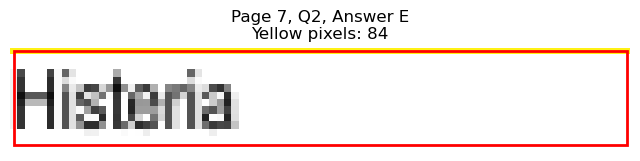


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=122.5, y1=287.1
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 209
Page 7, Q3, A: Yellow percentage: 0.0%


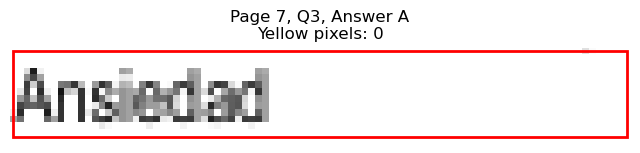

Page 7, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=123.1, y1=299.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 203
Page 7, Q3, B: Yellow percentage: 0.0%


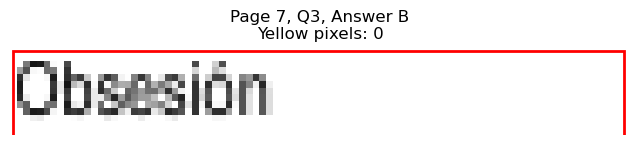

Page 7, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=111.5, y1=312.3
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 125
Page 7, Q3, C: Yellow percentage: 0.0%


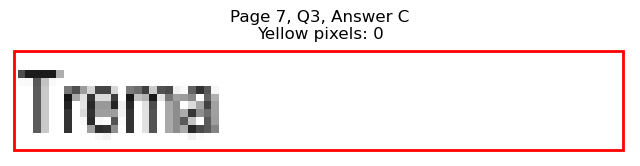

Page 7, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=364.7, y1=287.1
Page 7, Q3, D: Yellow pixels: 81
Page 7, Q3, D: Total non-white pixels: 231
Page 7, Q3, D: Yellow percentage: 35.1%


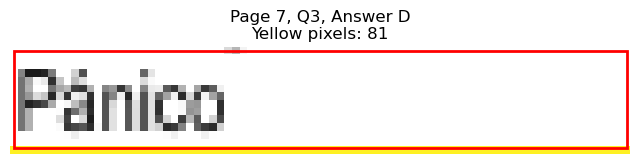

Page 7, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=380.3, y1=299.7
Page 7, Q3, E: Yellow pixels: 1067
Page 7, Q3, E: Total non-white pixels: 1261
Page 7, Q3, E: Yellow percentage: 84.6%


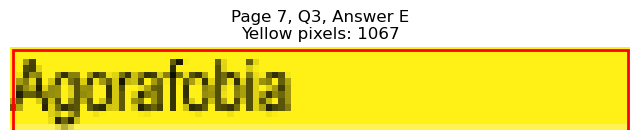


Page 7, Q3 - Selected Answer: E (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.5, y0=350.2, x1=120.1, y1=362.9
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 157
Page 7, Q4, A: Yellow percentage: 0.0%


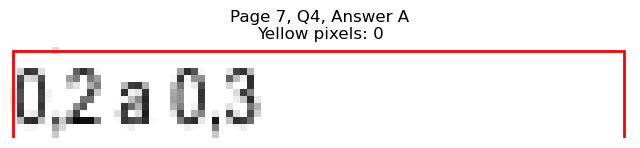

Page 7, Q4 - B: Detected box: x0=82.5, y0=362.8, x1=125.1, y1=375.5
Page 7, Q4, B: Yellow pixels: 94
Page 7, Q4, B: Total non-white pixels: 277
Page 7, Q4, B: Yellow percentage: 33.9%


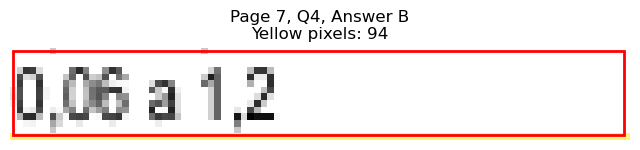

Page 7, Q4 - C: Detected box: x0=82.9, y0=375.4, x1=120.6, y1=388.1
Page 7, Q4, C: Yellow pixels: 1057
Page 7, Q4, C: Total non-white pixels: 1246
Page 7, Q4, C: Yellow percentage: 84.8%


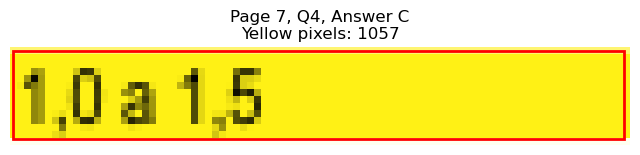

Page 7, Q4 - D: Detected box: x0=334.6, y0=350.2, x1=372.3, y1=362.9
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 140
Page 7, Q4, D: Yellow percentage: 0.0%


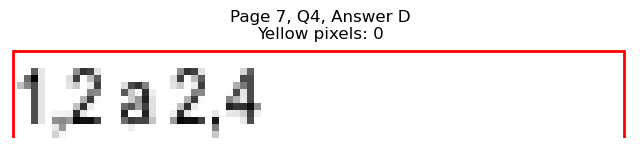

Page 7, Q4 - E: Detected box: x0=334.1, y0=362.8, x1=371.8, y1=375.5
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 143
Page 7, Q4, E: Yellow percentage: 0.0%


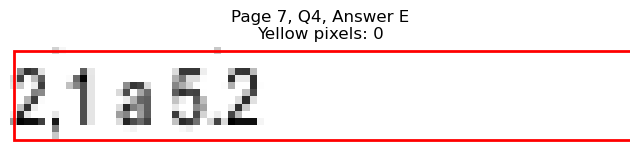


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.5, y0=413.3, x1=144.1, y1=426.0
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 327
Page 7, Q5, A: Yellow percentage: 0.0%


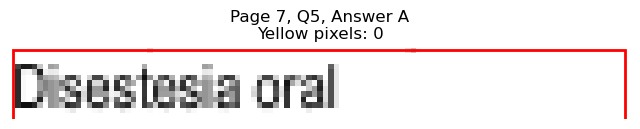

Page 7, Q5 - B: Detected box: x0=82.5, y0=425.9, x1=144.6, y1=438.6
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 329
Page 7, Q5, B: Yellow percentage: 0.0%


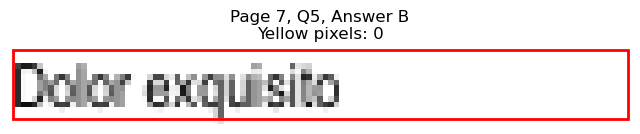

Page 7, Q5 - C: Detected box: x0=82.9, y0=438.5, x1=157.7, y1=451.2
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 382
Page 7, Q5, C: Yellow percentage: 0.0%


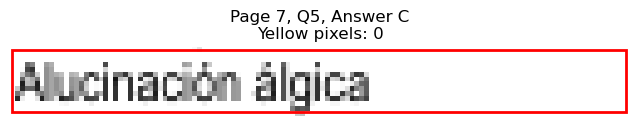

Page 7, Q5 - D: Detected box: x0=334.6, y0=413.3, x1=410.8, y1=426.0
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 538
Page 7, Q5, D: Yellow percentage: 0.0%


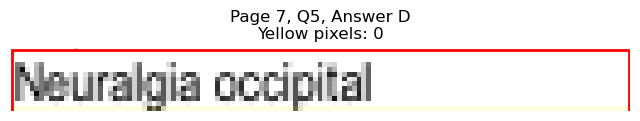

Page 7, Q5 - E: Detected box: x0=334.1, y0=425.9, x1=426.4, y1=438.6
Page 7, Q5, E: Yellow pixels: 1498
Page 7, Q5, E: Total non-white pixels: 2002
Page 7, Q5, E: Yellow percentage: 74.8%


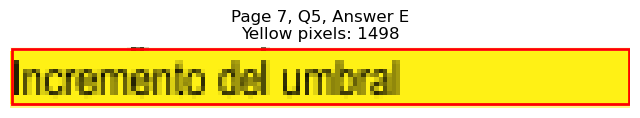


Page 7, Q5 - Selected Answer: E (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.5, y0=501.7, x1=113.5, y1=514.3
Page 7, Q6, A: Yellow pixels: 860
Page 7, Q6, A: Total non-white pixels: 1148
Page 7, Q6, A: Yellow percentage: 74.9%


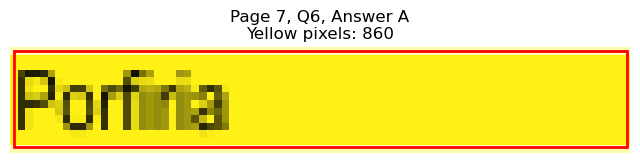

Page 7, Q6 - B: Detected box: x0=82.5, y0=514.3, x1=128.7, y1=526.9
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 327
Page 7, Q6, B: Yellow percentage: 0.0%


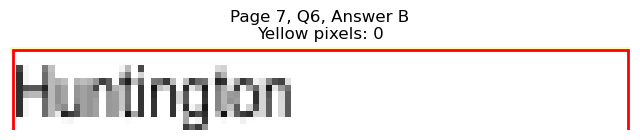

Page 7, Q6 - C: Detected box: x0=82.9, y0=526.9, x1=136.6, y1=539.5
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 269
Page 7, Q6, C: Yellow percentage: 0.0%


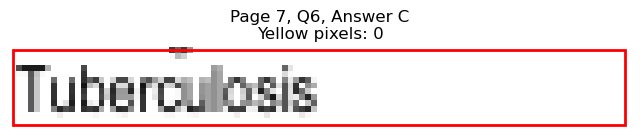

Page 7, Q6 - D: Detected box: x0=334.6, y0=501.7, x1=378.3, y1=514.3
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 231
Page 7, Q6, D: Yellow percentage: 0.0%


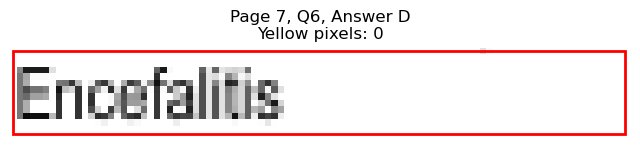

Page 7, Q6 - E: Detected box: x0=334.1, y0=514.3, x1=367.7, y1=526.9
Page 7, Q6, E: Yellow pixels: 0
Page 7, Q6, E: Total non-white pixels: 184
Page 7, Q6, E: Yellow percentage: 0.0%


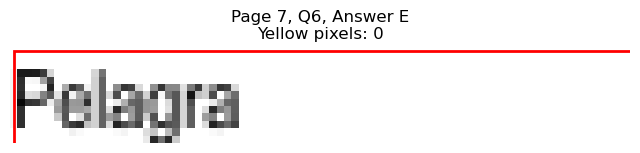


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.5, y0=564.8, x1=148.7, y1=577.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 352
Page 7, Q7, A: Yellow percentage: 0.0%


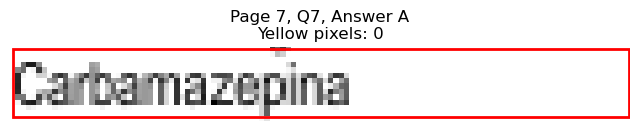

Page 7, Q7 - B: Detected box: x0=82.5, y0=577.4, x1=122.5, y1=590.0
Page 7, Q7, B: Yellow pixels: 91
Page 7, Q7, B: Total non-white pixels: 395
Page 7, Q7, B: Yellow percentage: 23.0%


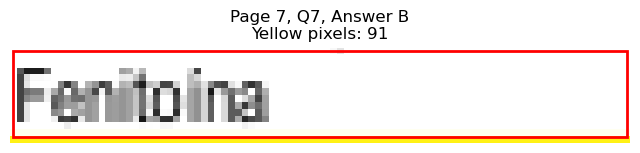

Page 7, Q7 - C: Detected box: x0=82.9, y0=590.0, x1=128.1, y1=602.6
Page 7, Q7, C: Yellow pixels: 1090
Page 7, Q7, C: Total non-white pixels: 1358
Page 7, Q7, C: Yellow percentage: 80.3%


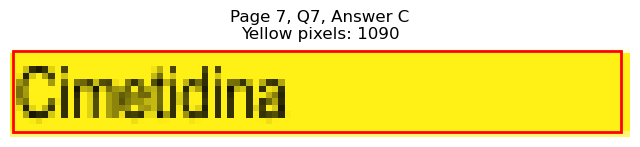

Page 7, Q7 - D: Detected box: x0=334.6, y0=564.8, x1=384.3, y1=577.4
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 255
Page 7, Q7, D: Yellow percentage: 0.0%


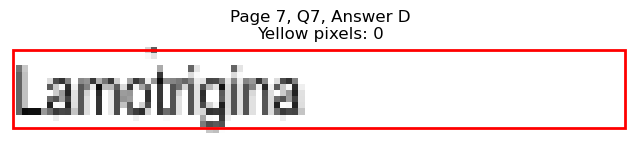

Page 7, Q7 - E: Detected box: x0=334.1, y0=577.4, x1=399.9, y1=590.0
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 336
Page 7, Q7, E: Yellow percentage: 0.0%


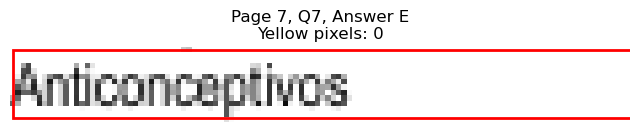


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.5, y0=653.1, x1=131.1, y1=665.8
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 327
Page 7, Q8, A: Yellow percentage: 0.0%


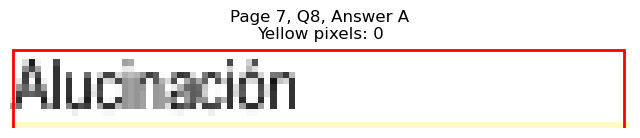

Page 7, Q8 - B: Detected box: x0=82.5, y0=665.7, x1=124.1, y1=678.4
Page 7, Q8, B: Yellow pixels: 948
Page 7, Q8, B: Total non-white pixels: 1302
Page 7, Q8, B: Yellow percentage: 72.8%


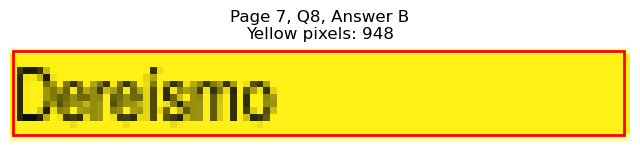

Page 7, Q8 - C: Detected box: x0=82.9, y0=678.3, x1=136.1, y1=691.0
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 355
Page 7, Q8, C: Yellow percentage: 0.0%


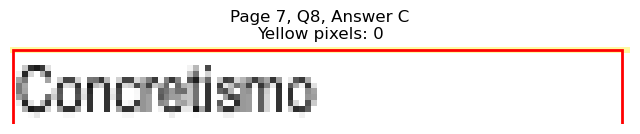

Page 7, Q8 - D: Detected box: x0=334.6, y0=653.1, x1=381.3, y1=665.8
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 233
Page 7, Q8, D: Yellow percentage: 0.0%


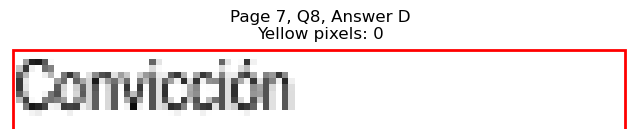

Page 7, Q8 - E: Detected box: x0=334.1, y0=665.7, x1=380.3, y1=678.4
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 239
Page 7, Q8, E: Yellow percentage: 0.0%


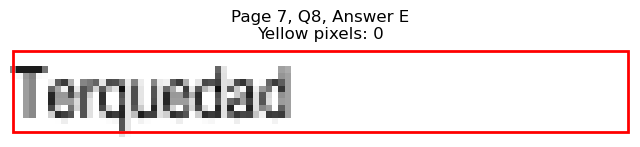


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.5, y0=741.4, x1=130.6, y1=754.1
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 237
Page 7, Q9, A: Yellow percentage: 0.0%


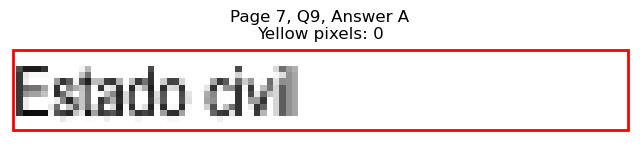

Page 7, Q9 - B: Detected box: x0=82.5, y0=754.0, x1=147.1, y1=766.7
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 339
Page 7, Q9, B: Yellow percentage: 0.0%


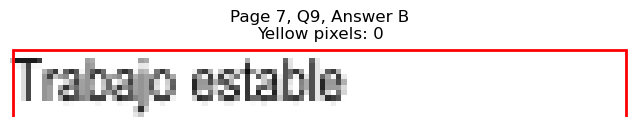

Page 7, Q9 - C: Detected box: x0=82.9, y0=766.8, x1=134.5, y1=779.4
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 289
Page 7, Q9, C: Yellow percentage: 0.0%


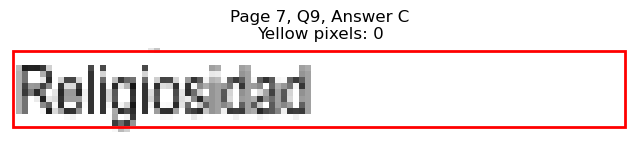

Page 7, Q9 - D: Detected box: x0=334.6, y0=741.4, x1=367.3, y1=754.1
Page 7, Q9, D: Yellow pixels: 84
Page 7, Q9, D: Total non-white pixels: 250
Page 7, Q9, D: Yellow percentage: 33.6%


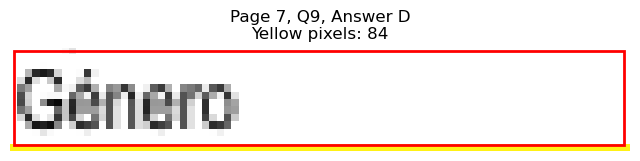

Page 7, Q9 - E: Detected box: x0=334.1, y0=754.0, x1=417.4, y1=766.7
Page 7, Q9, E: Yellow pixels: 1428
Page 7, Q9, E: Total non-white pixels: 1742
Page 7, Q9, E: Yellow percentage: 82.0%


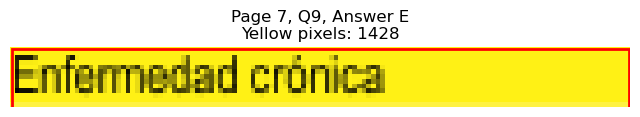


Page 7, Q9 - Selected Answer: E (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=82.5, y0=110.3, x1=128.1, y1=123.0
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 230
Page 8, Q1, A: Yellow percentage: 0.0%


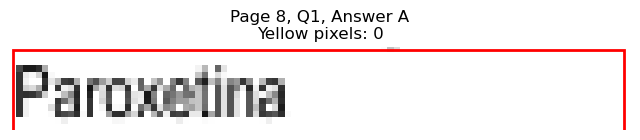

Page 8, Q1 - B: Detected box: x0=82.5, y0=122.9, x1=132.1, y1=135.6
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 227
Page 8, Q1, B: Yellow percentage: 0.0%


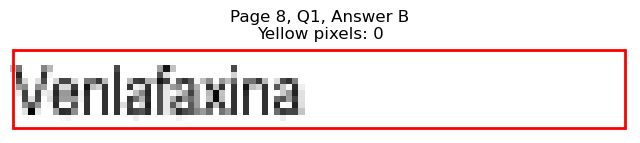

Page 8, Q1 - C: Detected box: x0=82.9, y0=135.5, x1=132.0, y1=148.2
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 236
Page 8, Q1, C: Yellow percentage: 0.0%


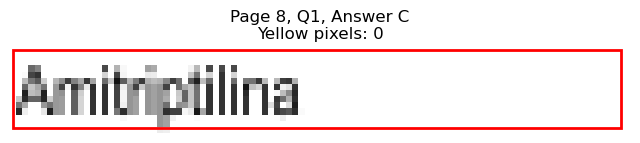

Page 8, Q1 - D: Detected box: x0=334.6, y0=110.3, x1=387.3, y1=123.0
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 372
Page 8, Q1, D: Yellow percentage: 0.0%


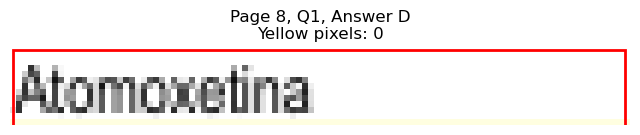

Page 8, Q1 - E: Detected box: x0=334.1, y0=122.9, x1=375.3, y1=135.6
Page 8, Q1, E: Yellow pixels: 1043
Page 8, Q1, E: Total non-white pixels: 1288
Page 8, Q1, E: Yellow percentage: 81.0%


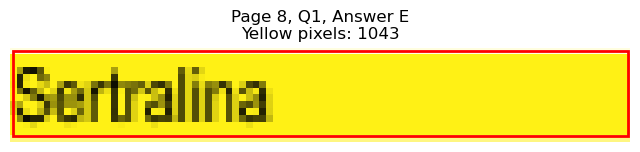


Page 8, Q1 - Selected Answer: E (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.5, y0=186.0, x1=177.3, y1=198.7
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 460
Page 8, Q2, A: Yellow percentage: 0.0%


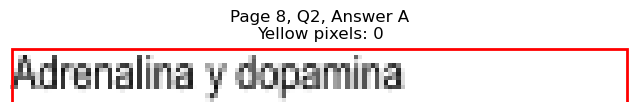

Page 8, Q2 - B: Detected box: x0=82.5, y0=198.6, x1=177.7, y1=211.3
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 504
Page 8, Q2, B: Yellow percentage: 0.0%


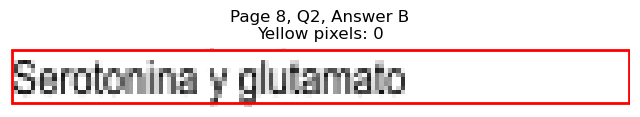

Page 8, Q2 - C: Detected box: x0=82.9, y0=211.3, x1=175.7, y1=224.0
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 477
Page 8, Q2, C: Yellow percentage: 0.0%


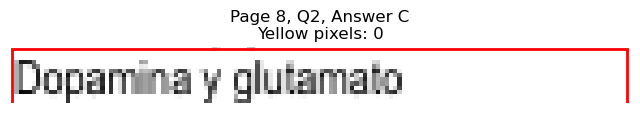

Page 8, Q2 - D: Detected box: x0=334.6, y0=186.0, x1=429.4, y1=198.7
Page 8, Q2, D: Yellow pixels: 2
Page 8, Q2, D: Total non-white pixels: 633
Page 8, Q2, D: Yellow percentage: 0.3%


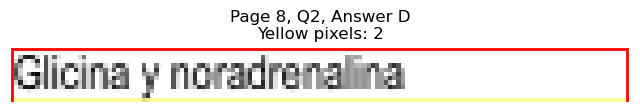

Page 8, Q2 - E: Detected box: x0=334.1, y0=198.6, x1=445.0, y1=211.3
Page 8, Q2, E: Yellow pixels: 1540
Page 8, Q2, E: Total non-white pixels: 2268
Page 8, Q2, E: Yellow percentage: 67.9%


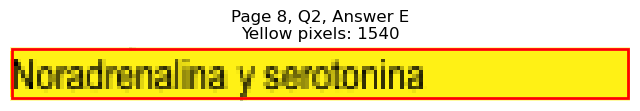


Page 8, Q2 - Selected Answer: E (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.5, y0=287.1, x1=116.5, y1=299.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 204
Page 8, Q3, A: Yellow percentage: 0.0%


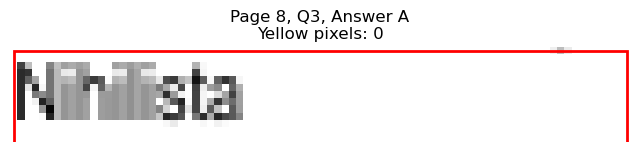

Page 8, Q3 - B: Detected box: x0=82.5, y0=299.7, x1=123.6, y1=312.3
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 205
Page 8, Q3, B: Yellow percentage: 0.0%


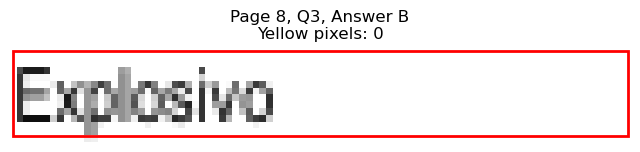

Page 8, Q3 - C: Detected box: x0=82.9, y0=312.3, x1=124.1, y1=324.9
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 207
Page 8, Q3, C: Yellow percentage: 0.0%


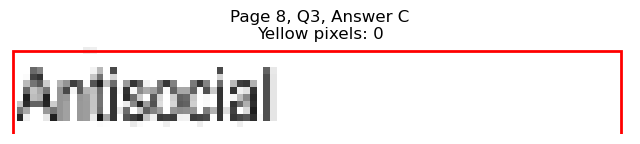

Page 8, Q3 - D: Detected box: x0=334.6, y0=287.1, x1=372.2, y1=299.7
Page 8, Q3, D: Yellow pixels: 1006
Page 8, Q3, D: Total non-white pixels: 1157
Page 8, Q3, D: Yellow percentage: 86.9%


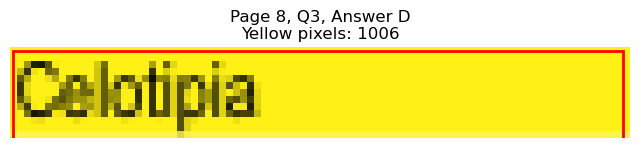

Page 8, Q3 - E: Detected box: x0=334.1, y0=299.7, x1=364.7, y1=312.3
Page 8, Q3, E: Yellow pixels: 81
Page 8, Q3, E: Total non-white pixels: 254
Page 8, Q3, E: Yellow percentage: 31.9%


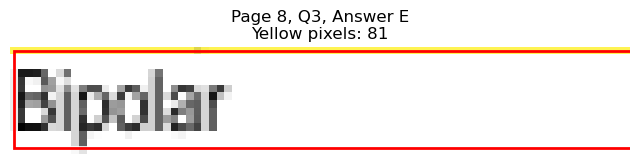


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.5, y0=400.6, x1=122.5, y1=413.3
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 211
Page 8, Q4, A: Yellow percentage: 0.0%


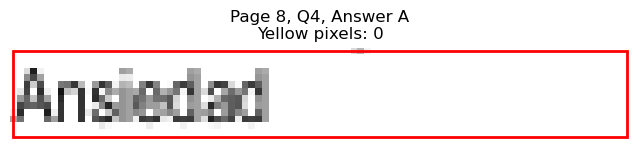

Page 8, Q4 - B: Detected box: x0=82.5, y0=413.3, x1=126.1, y1=426.0
Page 8, Q4, B: Yellow pixels: 1055
Page 8, Q4, B: Total non-white pixels: 1235
Page 8, Q4, B: Yellow percentage: 85.4%


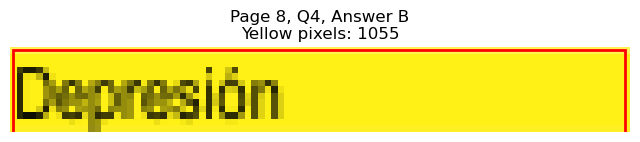

Page 8, Q4 - C: Detected box: x0=82.9, y0=425.9, x1=120.5, y1=438.6
Page 8, Q4, C: Yellow pixels: 87
Page 8, Q4, C: Total non-white pixels: 278
Page 8, Q4, C: Yellow percentage: 31.3%


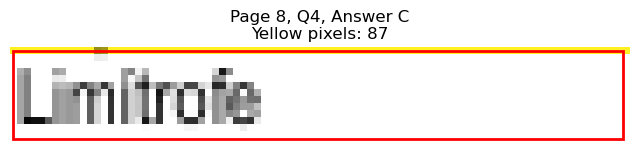

Page 8, Q4 - D: Detected box: x0=334.6, y0=400.6, x1=380.2, y1=413.3
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 227
Page 8, Q4, D: Yellow percentage: 0.0%


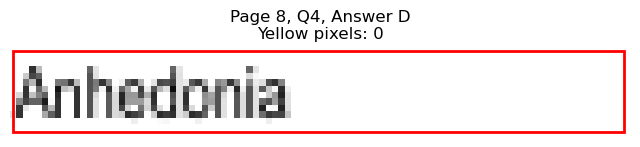

Page 8, Q4 - E: Detected box: x0=334.1, y0=413.3, x1=368.7, y1=426.0
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 184
Page 8, Q4, E: Yellow percentage: 0.0%


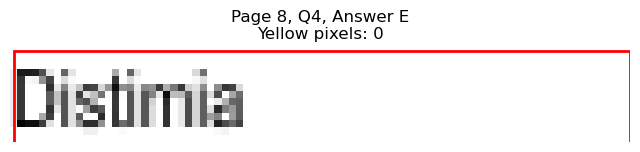


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.5, y0=476.3, x1=154.2, y1=489.0
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 364
Page 8, Q5, A: Yellow percentage: 0.0%


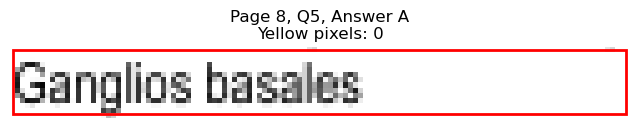

Page 8, Q5 - B: Detected box: x0=82.5, y0=489.1, x1=157.2, y1=501.7
Page 8, Q5, B: Yellow pixels: 1338
Page 8, Q5, B: Total non-white pixels: 1638
Page 8, Q5, B: Yellow percentage: 81.7%


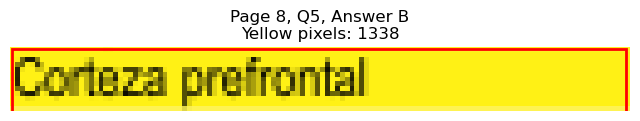

Page 8, Q5 - C: Detected box: x0=82.9, y0=501.7, x1=154.7, y1=514.3
Page 8, Q5, C: Yellow pixels: 123
Page 8, Q5, C: Total non-white pixels: 479
Page 8, Q5, C: Yellow percentage: 25.7%


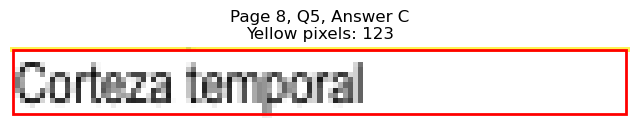

Page 8, Q5 - D: Detected box: x0=334.6, y0=476.3, x1=428.5, y1=489.0
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 483
Page 8, Q5, D: Yellow percentage: 0.0%


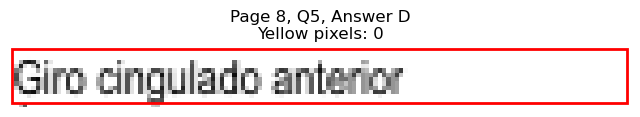

Page 8, Q5 - E: Detected box: x0=334.1, y0=489.1, x1=394.4, y1=501.7
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 299
Page 8, Q5, E: Yellow percentage: 0.0%


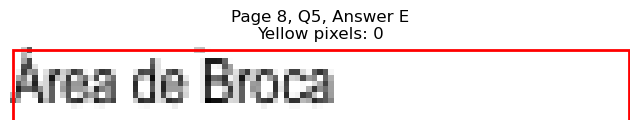


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.5, y0=577.4, x1=157.7, y1=590.0
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 405
Page 8, Q6, A: Yellow percentage: 0.0%


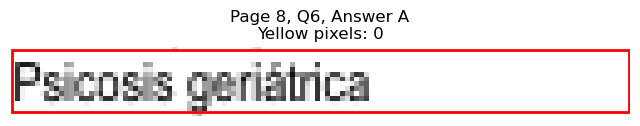

Page 8, Q6 - B: Detected box: x0=82.5, y0=590.0, x1=144.6, y1=602.6
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 336
Page 8, Q6, B: Yellow percentage: 0.0%


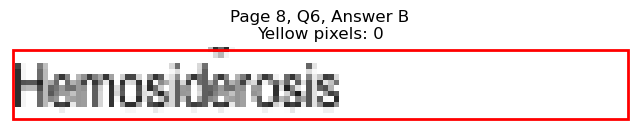

Page 8, Q6 - C: Detected box: x0=82.9, y0=602.6, x1=142.6, y1=615.2
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 270
Page 8, Q6, C: Yellow percentage: 0.0%


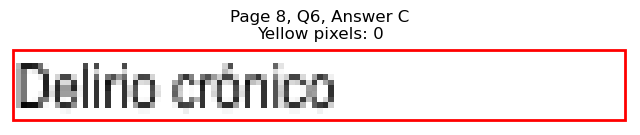

Page 8, Q6 - D: Detected box: x0=334.6, y0=577.4, x1=430.4, y1=590.0
Page 8, Q6, D: Yellow pixels: 1521
Page 8, Q6, D: Total non-white pixels: 1914
Page 8, Q6, D: Yellow percentage: 79.5%


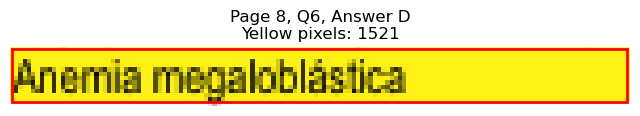

Page 8, Q6 - E: Detected box: x0=334.1, y0=590.0, x1=408.9, y1=602.6
Page 8, Q6, E: Yellow pixels: 121
Page 8, Q6, E: Total non-white pixels: 547
Page 8, Q6, E: Yellow percentage: 22.1%


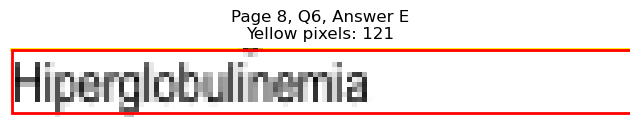


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.5, y0=653.1, x1=126.1, y1=665.8
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 207
Page 8, Q7, A: Yellow percentage: 0.0%


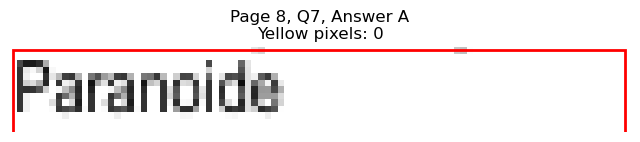

Page 8, Q7 - B: Detected box: x0=82.5, y0=665.7, x1=128.1, y1=678.4
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 241
Page 8, Q7, B: Yellow percentage: 0.0%


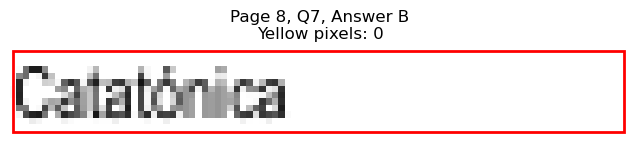

Page 8, Q7 - C: Detected box: x0=82.9, y0=678.3, x1=120.5, y1=691.0
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 214
Page 8, Q7, C: Yellow percentage: 0.0%


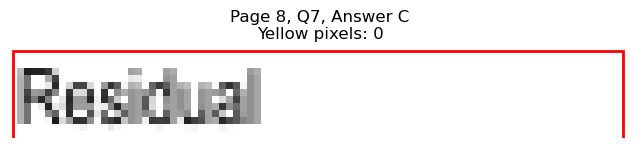

Page 8, Q7 - D: Detected box: x0=334.6, y0=653.1, x1=375.3, y1=665.8
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 310
Page 8, Q7, D: Yellow percentage: 0.0%


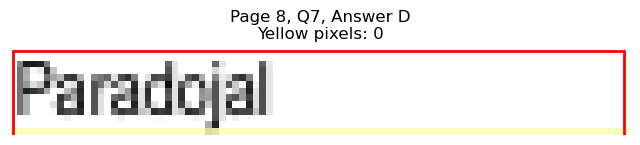

Page 8, Q7 - E: Detected box: x0=334.1, y0=665.7, x1=397.4, y1=678.4
Page 8, Q7, E: Yellow pixels: 1107
Page 8, Q7, E: Total non-white pixels: 1596
Page 8, Q7, E: Yellow percentage: 69.4%


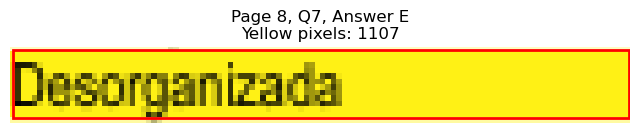


Page 8, Q7 - Selected Answer: E (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=117.6, y1=754.1
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 163
Page 8, Q8, A: Yellow percentage: 0.0%


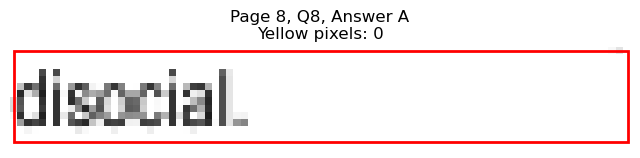

Page 8, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=130.6, y1=766.7
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 258
Page 8, Q8, B: Yellow percentage: 0.0%


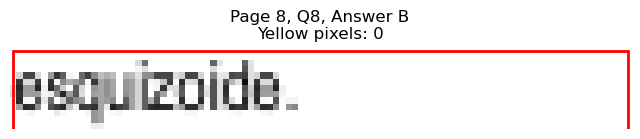

Page 8, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=133.1, y1=779.4
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 248
Page 8, Q8, C: Yellow percentage: 0.0%


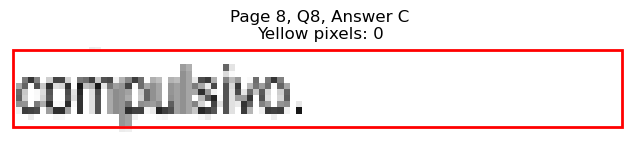

Page 8, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=361.3, y1=754.1
Page 8, Q8, D: Yellow pixels: 916
Page 8, Q8, D: Total non-white pixels: 1092
Page 8, Q8, D: Yellow percentage: 83.9%


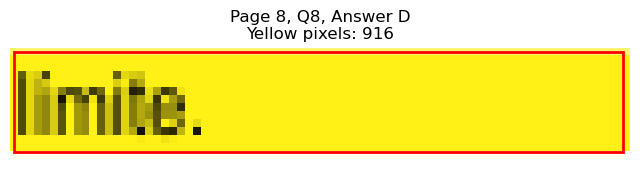

Page 8, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=379.7, y1=766.7
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 335
Page 8, Q8, E: Yellow percentage: 0.0%


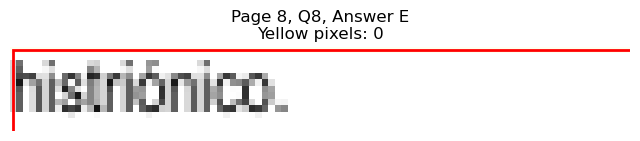


Page 8, Q8 - Selected Answer: D (based on yellow pixel count)





Page 9: Found 8 questions
Page 9, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=114.0, y1=110.4
Page 9, Q1, A: Yellow pixels: 83
Page 9, Q1, A: Total non-white pixels: 233
Page 9, Q1, A: Yellow percentage: 35.6%


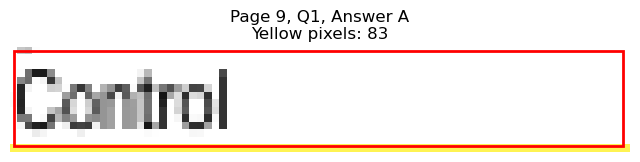

Page 9, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=112.1, y1=123.0
Page 9, Q1, B: Yellow pixels: 941
Page 9, Q1, B: Total non-white pixels: 1053
Page 9, Q1, B: Yellow percentage: 89.4%


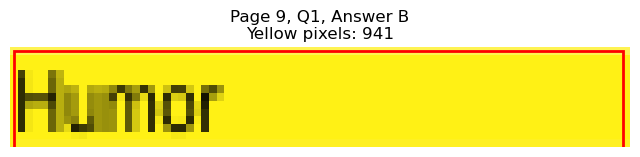

Page 9, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=123.6, y1=135.6
Page 9, Q1, C: Yellow pixels: 92
Page 9, Q1, C: Total non-white pixels: 278
Page 9, Q1, C: Yellow percentage: 33.1%


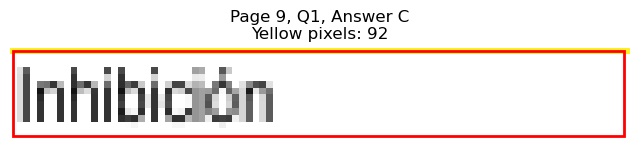

Page 9, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=378.3, y1=110.4
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 240
Page 9, Q1, D: Yellow percentage: 0.0%


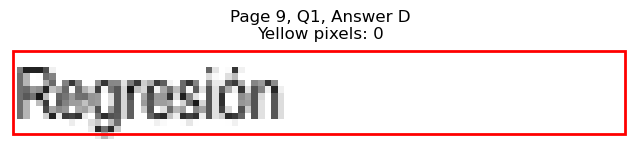

Page 9, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=369.8, y1=123.0
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 191
Page 9, Q1, E: Yellow percentage: 0.0%


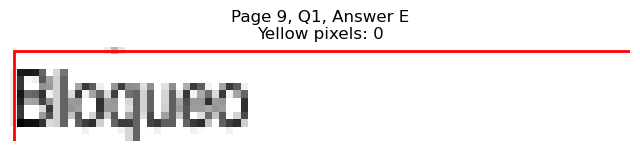


Page 9, Q1 - Selected Answer: B (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=82.5, y0=160.8, x1=134.7, y1=173.5
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 241
Page 9, Q2, A: Yellow percentage: 0.0%


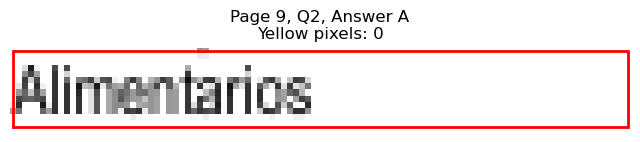

Page 9, Q2 - B: Detected box: x0=82.5, y0=173.4, x1=127.1, y1=186.1
Page 9, Q2, B: Yellow pixels: 96
Page 9, Q2, B: Total non-white pixels: 314
Page 9, Q2, B: Yellow percentage: 30.6%


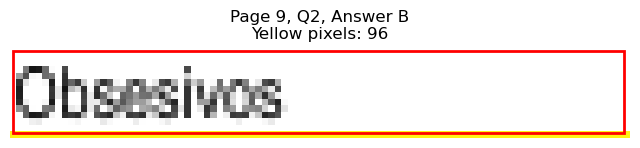

Page 9, Q2 - C: Detected box: x0=82.9, y0=186.0, x1=117.0, y1=198.7
Page 9, Q2, C: Yellow pixels: 993
Page 9, Q2, C: Total non-white pixels: 1118
Page 9, Q2, C: Yellow percentage: 88.8%


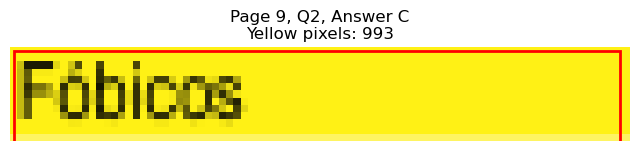

Page 9, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=382.3, y1=173.5
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 262
Page 9, Q2, D: Yellow percentage: 0.0%


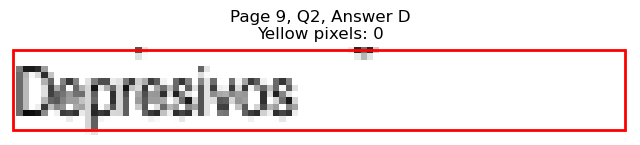

Page 9, Q2 - E: Detected box: x0=334.1, y0=173.4, x1=372.8, y1=186.1
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 203
Page 9, Q2, E: Yellow percentage: 0.0%


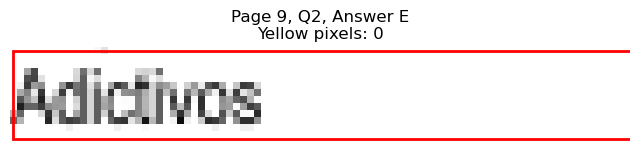


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=82.5, y0=287.1, x1=154.2, y1=299.7
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 356
Page 9, Q3, A: Yellow percentage: 0.0%


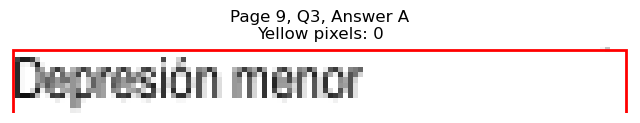

Page 9, Q3 - B: Detected box: x0=82.5, y0=299.7, x1=164.8, y1=312.3
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 406
Page 9, Q3, B: Yellow percentage: 0.0%


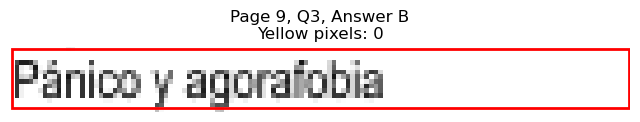

Page 9, Q3 - C: Detected box: x0=82.9, y0=312.3, x1=159.1, y1=324.9
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 383
Page 9, Q3, C: Yellow percentage: 0.0%


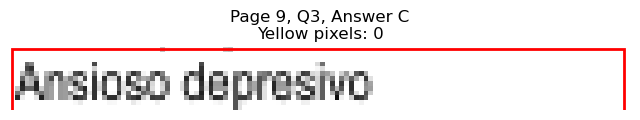

Page 9, Q3 - D: Detected box: x0=334.6, y0=287.1, x1=421.9, y1=299.7
Page 9, Q3, D: Yellow pixels: 1444
Page 9, Q3, D: Total non-white pixels: 1794
Page 9, Q3, D: Yellow percentage: 80.5%


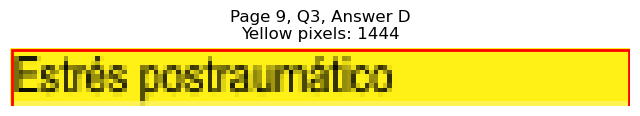

Page 9, Q3 - E: Detected box: x0=334.1, y0=299.7, x1=400.4, y1=312.3
Page 9, Q3, E: Yellow pixels: 117
Page 9, Q3, E: Total non-white pixels: 445
Page 9, Q3, E: Yellow percentage: 26.3%


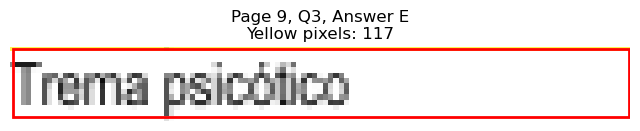


Page 9, Q3 - Selected Answer: D (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.5, y0=362.8, x1=147.1, y1=375.5
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 286
Page 9, Q4, A: Yellow percentage: 0.0%


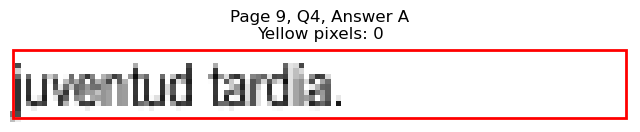

Page 9, Q4 - B: Detected box: x0=82.5, y0=375.4, x1=147.1, y1=388.1
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 315
Page 9, Q4, B: Yellow percentage: 0.0%


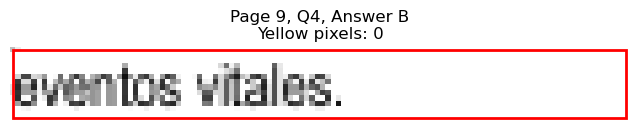

Page 9, Q4 - C: Detected box: x0=82.9, y0=388.0, x1=162.7, y1=400.7
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 398
Page 9, Q4, C: Yellow percentage: 0.0%


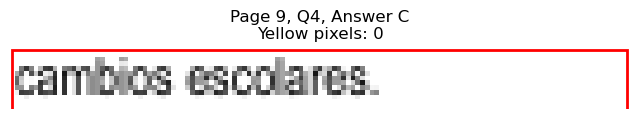

Page 9, Q4 - D: Detected box: x0=334.6, y0=362.8, x1=403.9, y1=375.5
Page 9, Q4, D: Yellow pixels: 1308
Page 9, Q4, D: Total non-white pixels: 1680
Page 9, Q4, D: Yellow percentage: 77.9%


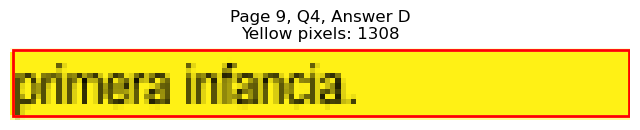

Page 9, Q4 - E: Detected box: x0=334.1, y0=375.4, x1=413.3, y1=388.1
Page 9, Q4, E: Yellow pixels: 130
Page 9, Q4, E: Total non-white pixels: 527
Page 9, Q4, E: Yellow percentage: 24.7%


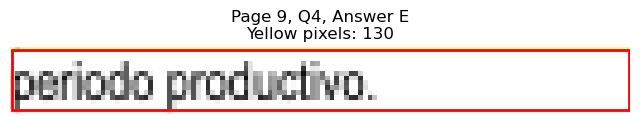


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.5, y0=425.9, x1=153.7, y1=438.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 380
Page 9, Q5, A: Yellow percentage: 0.0%


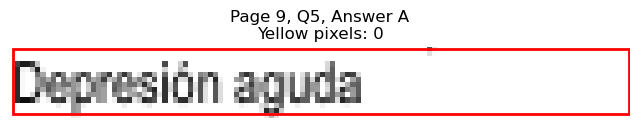

Page 9, Q5 - B: Detected box: x0=82.5, y0=438.5, x1=169.7, y1=451.2
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 447
Page 9, Q5, B: Yellow percentage: 0.0%


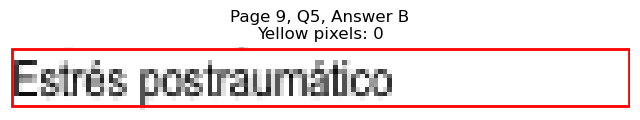

Page 9, Q5 - C: Detected box: x0=82.9, y0=451.1, x1=171.7, y1=463.8
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 463
Page 9, Q5, C: Yellow percentage: 0.0%


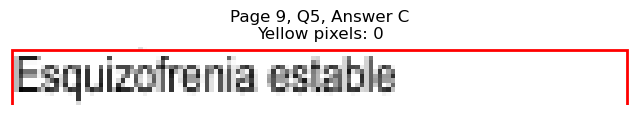

Page 9, Q5 - D: Detected box: x0=334.6, y0=425.9, x1=400.9, y1=438.6
Page 9, Q5, D: Yellow pixels: 117
Page 9, Q5, D: Total non-white pixels: 438
Page 9, Q5, D: Yellow percentage: 26.7%


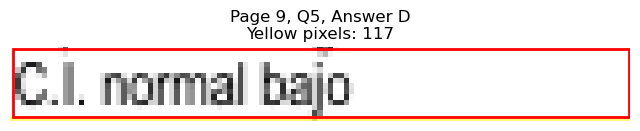

Page 9, Q5 - E: Detected box: x0=334.1, y0=438.5, x1=419.9, y1=451.2
Page 9, Q5, E: Yellow pixels: 1429
Page 9, Q5, E: Total non-white pixels: 1904
Page 9, Q5, E: Yellow percentage: 75.1%


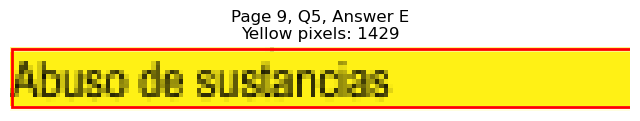


Page 9, Q5 - Selected Answer: E (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.5, y0=514.3, x1=110.1, y1=526.9
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 140
Page 9, Q6, A: Yellow percentage: 0.0%


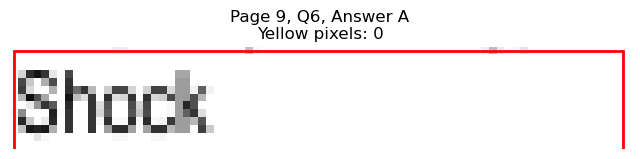

Page 9, Q6 - B: Detected box: x0=82.5, y0=526.9, x1=134.7, y1=539.5
Page 9, Q6, B: Yellow pixels: 103
Page 9, Q6, B: Total non-white pixels: 377
Page 9, Q6, B: Yellow percentage: 27.3%


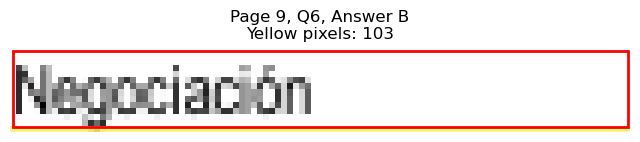

Page 9, Q6 - C: Detected box: x0=82.9, y0=539.5, x1=108.5, y1=552.1
Page 9, Q6, C: Yellow pixels: 890
Page 9, Q6, C: Total non-white pixels: 1078
Page 9, Q6, C: Yellow percentage: 82.6%


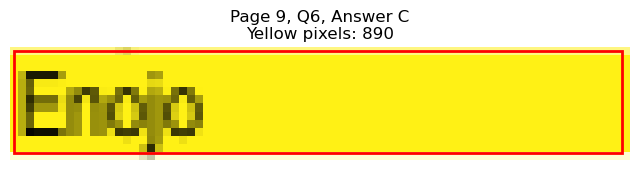

Page 9, Q6 - D: Detected box: x0=334.6, y0=514.3, x1=378.3, y1=526.9
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 233
Page 9, Q6, D: Yellow percentage: 0.0%


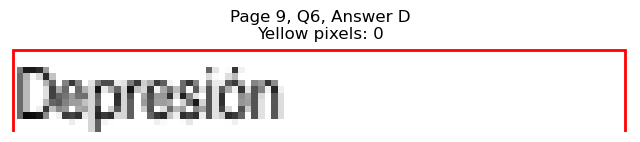

Page 9, Q6 - E: Detected box: x0=334.1, y0=526.9, x1=381.3, y1=539.5
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 255
Page 9, Q6, E: Yellow percentage: 0.0%


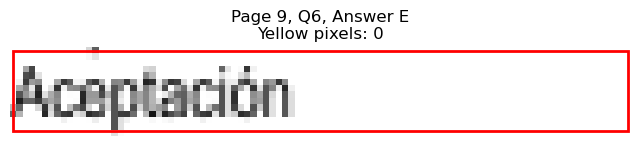


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.5, y0=577.4, x1=123.6, y1=590.0
Page 9, Q7, A: Yellow pixels: 92
Page 9, Q7, A: Total non-white pixels: 367
Page 9, Q7, A: Yellow percentage: 25.1%


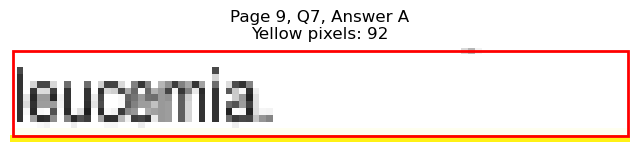

Page 9, Q7 - B: Detected box: x0=82.5, y0=590.0, x1=147.6, y1=602.6
Page 9, Q7, B: Yellow pixels: 1270
Page 9, Q7, B: Total non-white pixels: 1624
Page 9, Q7, B: Yellow percentage: 78.2%


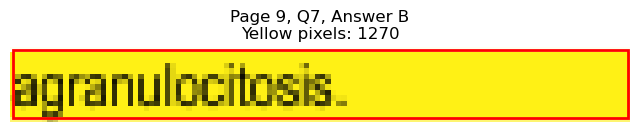

Page 9, Q7 - C: Detected box: x0=82.9, y0=602.6, x1=139.6, y1=615.2
Page 9, Q7, C: Yellow pixels: 106
Page 9, Q7, C: Total non-white pixels: 388
Page 9, Q7, C: Yellow percentage: 27.3%


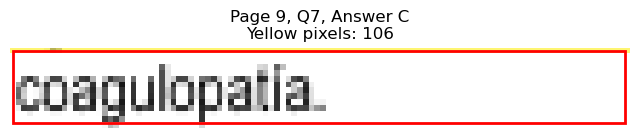

Page 9, Q7 - D: Detected box: x0=334.6, y0=577.4, x1=382.3, y1=590.0
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 246
Page 9, Q7, D: Yellow percentage: 0.0%


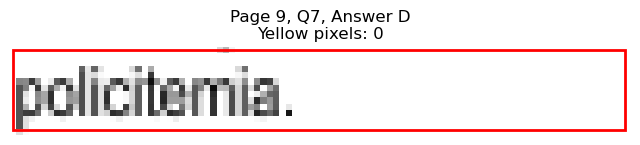

Page 9, Q7 - E: Detected box: x0=334.1, y0=590.0, x1=392.3, y1=602.6
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 283
Page 9, Q7, E: Yellow percentage: 0.0%


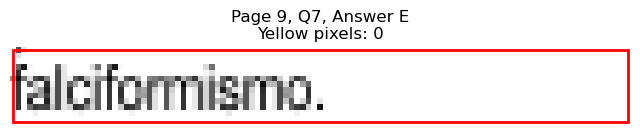


Page 9, Q7 - Selected Answer: B (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=82.5, y0=665.7, x1=149.7, y1=678.4
Page 9, Q8, A: Yellow pixels: 1149
Page 9, Q8, A: Total non-white pixels: 1652
Page 9, Q8, A: Yellow percentage: 69.6%


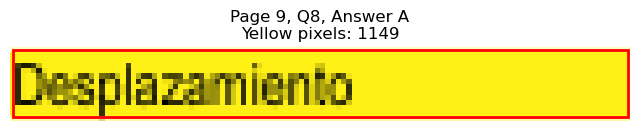

Page 9, Q8 - B: Detected box: x0=82.5, y0=678.3, x1=148.1, y1=691.0
Page 9, Q8, B: Yellow pixels: 1
Page 9, Q8, B: Total non-white pixels: 431
Page 9, Q8, B: Yellow percentage: 0.2%


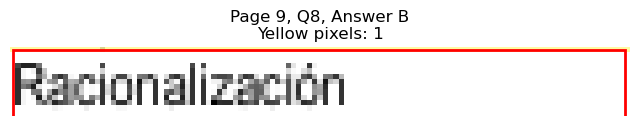

Page 9, Q8 - C: Detected box: x0=82.9, y0=691.1, x1=138.1, y1=703.7
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 299
Page 9, Q8, C: Yellow percentage: 0.0%


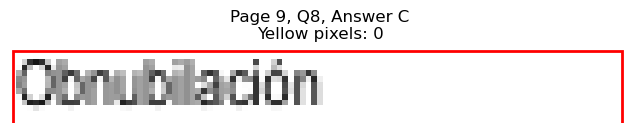

Page 9, Q8 - D: Detected box: x0=334.6, y0=665.7, x1=394.9, y1=678.4
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 304
Page 9, Q8, D: Yellow percentage: 0.0%


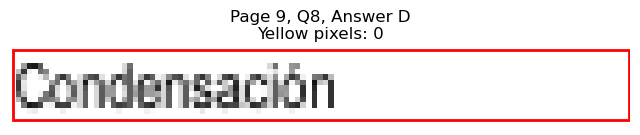

Page 9, Q8 - E: Detected box: x0=334.1, y0=678.3, x1=378.9, y1=691.0
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 237
Page 9, Q8, E: Yellow percentage: 0.0%


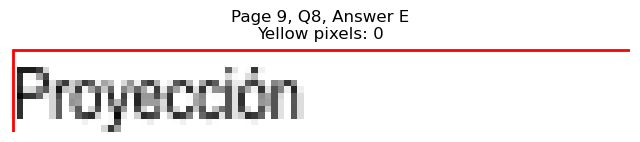


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 8 questions
Page 10, Q1 - A: Detected box: x0=82.5, y0=160.8, x1=156.1, y1=173.5
Page 10, Q1, A: Yellow pixels: 1341
Page 10, Q1, A: Total non-white pixels: 1750
Page 10, Q1, A: Yellow percentage: 76.6%


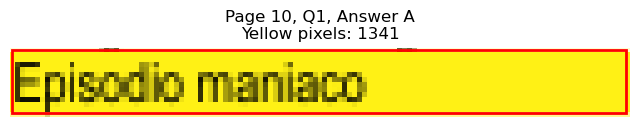

Page 10, Q1 - B: Detected box: x0=82.5, y0=173.4, x1=169.7, y1=186.1
Page 10, Q1, B: Yellow pixels: 138
Page 10, Q1, B: Total non-white pixels: 575
Page 10, Q1, B: Yellow percentage: 24.0%


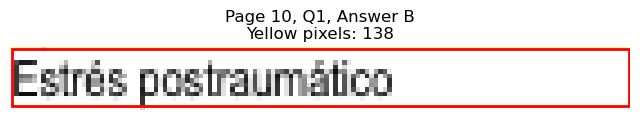

Page 10, Q1 - C: Detected box: x0=82.9, y0=186.0, x1=161.2, y1=198.7
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 384
Page 10, Q1, C: Yellow percentage: 0.0%


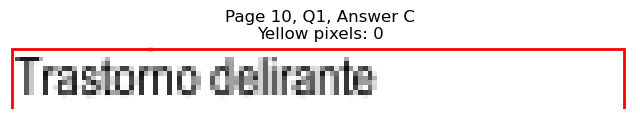

Page 10, Q1 - D: Detected box: x0=334.6, y0=160.8, x1=395.3, y1=173.5
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 307
Page 10, Q1, D: Yellow percentage: 0.0%


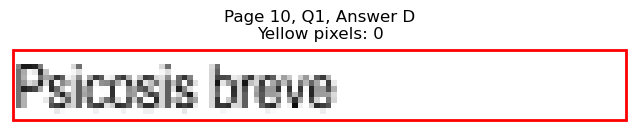

Page 10, Q1 - E: Detected box: x0=334.1, y0=173.4, x1=380.8, y1=186.1
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 250
Page 10, Q1, E: Yellow percentage: 0.0%


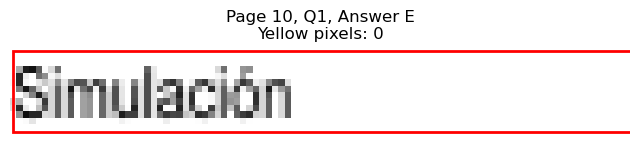


Page 10, Q1 - Selected Answer: A (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.5, y0=261.7, x1=178.8, y1=274.4
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 467
Page 10, Q2, A: Yellow percentage: 0.0%


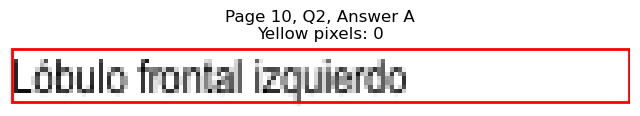

Page 10, Q2 - B: Detected box: x0=82.5, y0=274.5, x1=179.3, y1=287.1
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 473
Page 10, Q2, B: Yellow percentage: 0.0%


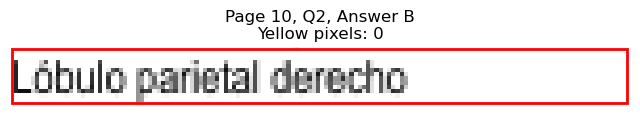

Page 10, Q2 - C: Detected box: x0=82.9, y0=287.1, x1=157.7, y1=299.7
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 401
Page 10, Q2, C: Yellow percentage: 0.0%


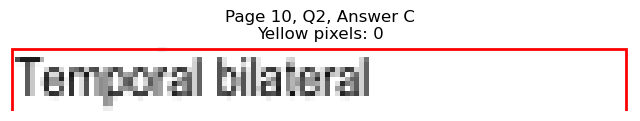

Page 10, Q2 - D: Detected box: x0=334.6, y0=261.7, x1=415.4, y1=274.4
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 432
Page 10, Q2, D: Yellow percentage: 0.0%


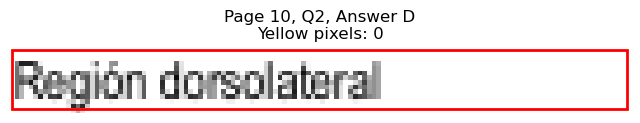

Page 10, Q2 - E: Detected box: x0=334.1, y0=274.5, x1=415.4, y1=287.1
Page 10, Q2, E: Yellow pixels: 1393
Page 10, Q2, E: Total non-white pixels: 1848
Page 10, Q2, E: Yellow percentage: 75.4%


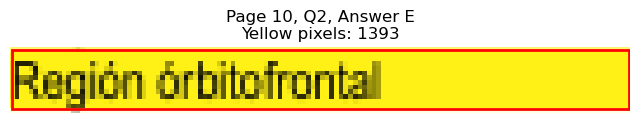


Page 10, Q2 - Selected Answer: E (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.5, y0=324.9, x1=132.6, y1=337.5
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 243
Page 10, Q3, A: Yellow percentage: 0.0%


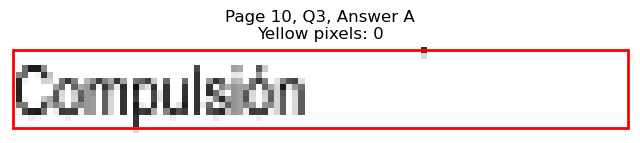

Page 10, Q3 - B: Detected box: x0=82.5, y0=337.5, x1=135.1, y1=350.1
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 277
Page 10, Q3, B: Yellow percentage: 0.0%


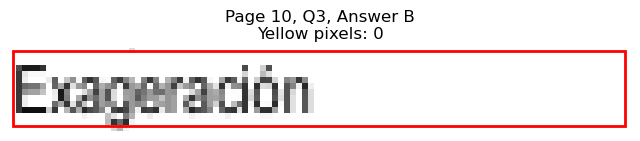

Page 10, Q3 - C: Detected box: x0=82.9, y0=350.2, x1=123.6, y1=362.9
Page 10, Q3, C: Yellow pixels: 1023
Page 10, Q3, C: Total non-white pixels: 1196
Page 10, Q3, C: Yellow percentage: 85.5%


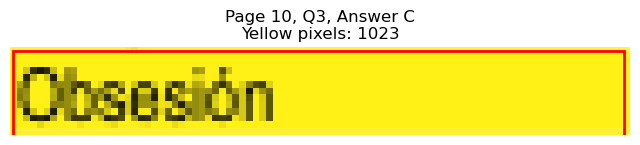

Page 10, Q3 - D: Detected box: x0=334.6, y0=324.9, x1=394.9, y1=337.5
Page 10, Q3, D: Yellow pixels: 0
Page 10, Q3, D: Total non-white pixels: 306
Page 10, Q3, D: Yellow percentage: 0.0%


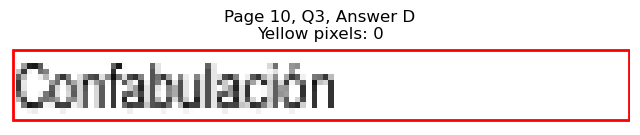

Page 10, Q3 - E: Detected box: x0=334.1, y0=337.5, x1=383.2, y1=350.1
Page 10, Q3, E: Yellow pixels: 0
Page 10, Q3, E: Total non-white pixels: 268
Page 10, Q3, E: Yellow percentage: 0.0%


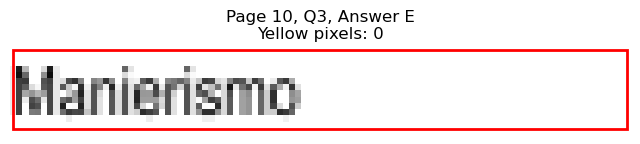


Page 10, Q3 - Selected Answer: C (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.5, y0=400.6, x1=177.3, y1=413.3
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 477
Page 10, Q4, A: Yellow percentage: 0.0%


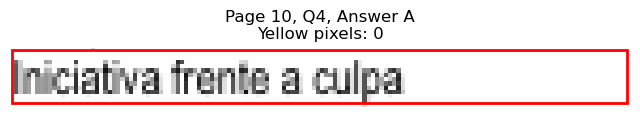

Page 10, Q4 - B: Detected box: x0=82.5, y0=413.3, x1=214.4, y1=426.0
Page 10, Q4, B: Yellow pixels: 1869
Page 10, Q4, B: Total non-white pixels: 2379
Page 10, Q4, B: Yellow percentage: 78.6%


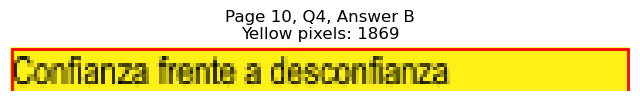

Page 10, Q4 - C: Detected box: x0=82.9, y0=425.9, x1=187.8, y1=438.6
Page 10, Q4, C: Yellow pixels: 156
Page 10, Q4, C: Total non-white pixels: 678
Page 10, Q4, C: Yellow percentage: 23.0%


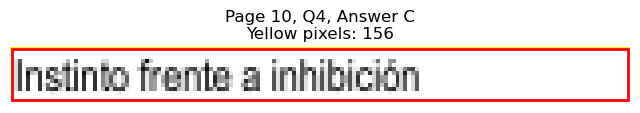

Page 10, Q4 - D: Detected box: x0=334.6, y0=400.6, x1=448.5, y1=413.3
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 579
Page 10, Q4, D: Yellow percentage: 0.0%


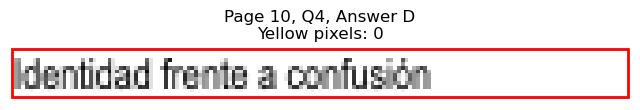

Page 10, Q4 - E: Detected box: x0=334.1, y0=413.3, x1=471.1, y1=426.0
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 699
Page 10, Q4, E: Yellow percentage: 0.0%


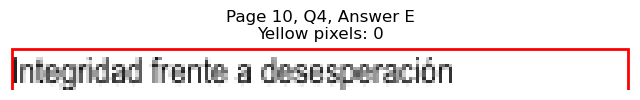


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.5, y0=476.3, x1=105.0, y1=489.0
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 106
Page 10, Q5, A: Yellow percentage: 0.0%


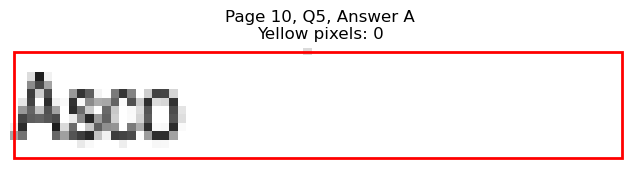

Page 10, Q5 - B: Detected box: x0=82.5, y0=489.1, x1=116.1, y1=501.7
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 152
Page 10, Q5, B: Yellow percentage: 0.0%


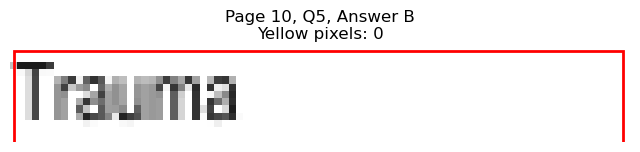

Page 10, Q5 - C: Detected box: x0=82.9, y0=501.7, x1=109.0, y1=514.3
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 119
Page 10, Q5, C: Yellow percentage: 0.0%


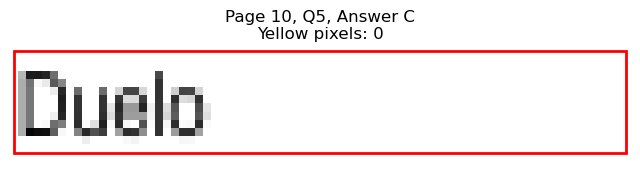

Page 10, Q5 - D: Detected box: x0=334.6, y0=476.3, x1=353.7, y1=489.0
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 107
Page 10, Q5, D: Yellow percentage: 0.0%


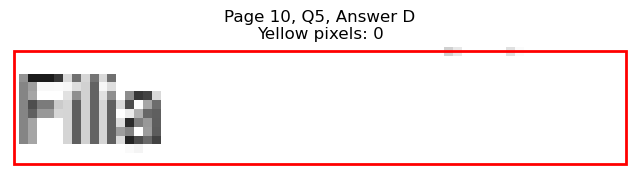

Page 10, Q5 - E: Detected box: x0=334.1, y0=489.1, x1=359.2, y1=501.7
Page 10, Q5, E: Yellow pixels: 902
Page 10, Q5, E: Total non-white pixels: 988
Page 10, Q5, E: Yellow percentage: 91.3%


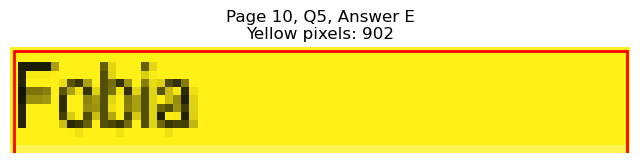


Page 10, Q5 - Selected Answer: E (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.5, y0=552.2, x1=114.0, y1=564.8
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 161
Page 10, Q6, A: Yellow percentage: 0.0%


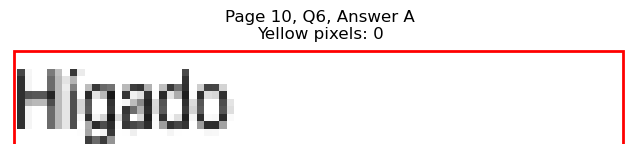

Page 10, Q6 - B: Detected box: x0=82.5, y0=564.8, x1=108.5, y1=577.4
Page 10, Q6, B: Yellow pixels: 77
Page 10, Q6, B: Total non-white pixels: 223
Page 10, Q6, B: Yellow percentage: 34.5%


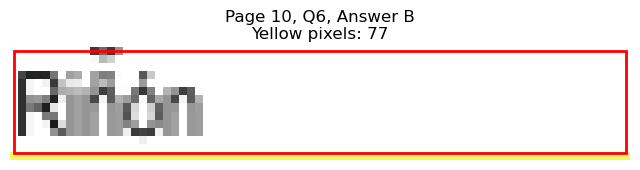

Page 10, Q6 - C: Detected box: x0=82.9, y0=577.4, x1=119.5, y1=590.0
Page 10, Q6, C: Yellow pixels: 1012
Page 10, Q6, C: Total non-white pixels: 1144
Page 10, Q6, C: Yellow percentage: 88.5%


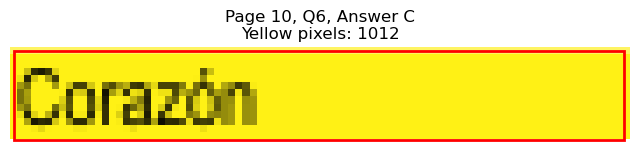

Page 10, Q6 - D: Detected box: x0=334.6, y0=552.2, x1=366.8, y1=564.8
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 160
Page 10, Q6, D: Yellow percentage: 0.0%


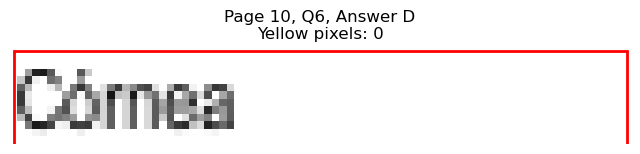

Page 10, Q6 - E: Detected box: x0=334.1, y0=564.8, x1=370.7, y1=577.4
Page 10, Q6, E: Yellow pixels: 0
Page 10, Q6, E: Total non-white pixels: 192
Page 10, Q6, E: Yellow percentage: 0.0%


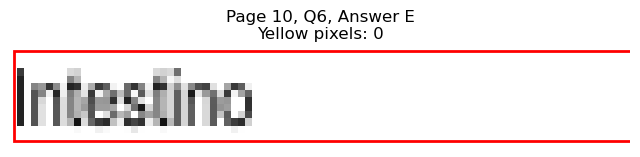


Page 10, Q6 - Selected Answer: C (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.5, y0=678.3, x1=125.5, y1=691.0
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 212
Page 10, Q7, A: Yellow percentage: 0.0%


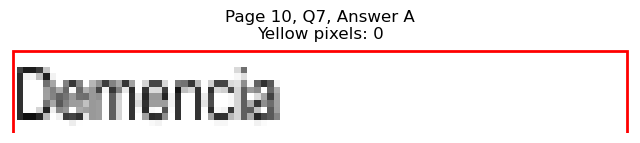

Page 10, Q7 - B: Detected box: x0=82.5, y0=691.1, x1=126.6, y1=703.7
Page 10, Q7, B: Yellow pixels: 1059
Page 10, Q7, B: Total non-white pixels: 1235
Page 10, Q7, B: Yellow percentage: 85.7%


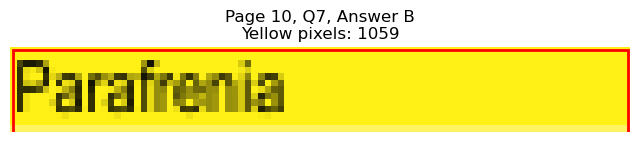

Page 10, Q7 - C: Detected box: x0=82.9, y0=350.2, x1=123.6, y1=362.9
Page 10, Q7, C: Yellow pixels: 1023
Page 10, Q7, C: Total non-white pixels: 1196
Page 10, Q7, C: Yellow percentage: 85.5%


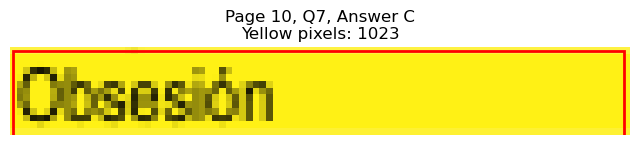

Page 10, Q7 - D: Detected box: x0=334.6, y0=678.3, x1=375.3, y1=691.0
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 217
Page 10, Q7, D: Yellow percentage: 0.0%


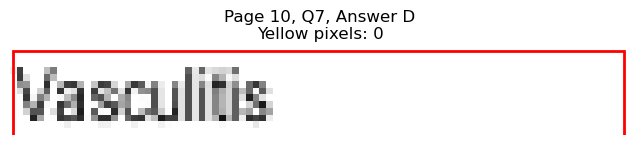

Page 10, Q7 - E: Detected box: x0=334.1, y0=691.1, x1=386.8, y1=703.7
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 272
Page 10, Q7, E: Yellow percentage: 0.0%


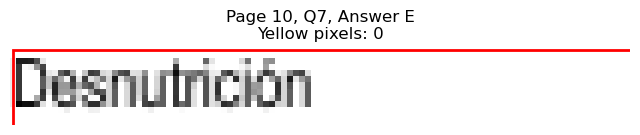


Page 10, Q7 - Selected Answer: B (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.5, y0=741.4, x1=191.8, y1=754.1
Page 10, Q8, A: Yellow pixels: 160
Page 10, Q8, A: Total non-white pixels: 712
Page 10, Q8, A: Yellow percentage: 22.5%


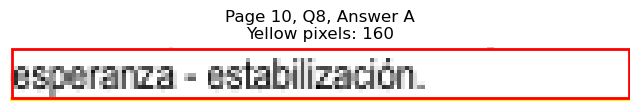

Page 10, Q8 - B: Detected box: x0=82.5, y0=754.0, x1=193.8, y1=766.7
Page 10, Q8, B: Yellow pixels: 1656
Page 10, Q8, B: Total non-white pixels: 2106
Page 10, Q8, B: Yellow percentage: 78.6%


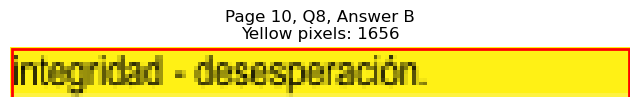

Page 10, Q8 - C: Detected box: x0=82.9, y0=766.8, x1=186.7, y1=779.4
Page 10, Q8, C: Yellow pixels: 154
Page 10, Q8, C: Total non-white pixels: 686
Page 10, Q8, C: Yellow percentage: 22.4%


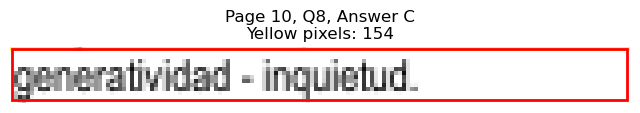

Page 10, Q8 - D: Detected box: x0=334.6, y0=741.4, x1=429.4, y1=754.1
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 449
Page 10, Q8, D: Yellow percentage: 0.0%


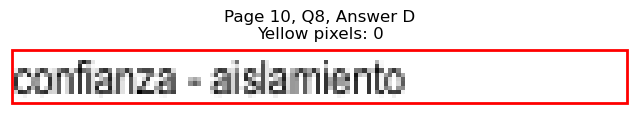

Page 10, Q8 - E: Detected box: x0=334.1, y0=754.0, x1=435.5, y1=766.7
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 518
Page 10, Q8, E: Yellow percentage: 0.0%


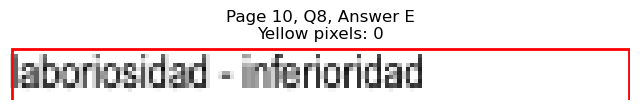


Page 10, Q8 - Selected Answer: B (based on yellow pixel count)





Page 11: Found 8 questions
Page 11, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=95.1, y1=110.4
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 61
Page 11, Q1, A: Yellow percentage: 0.0%


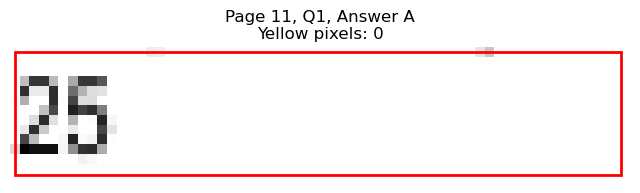

Page 11, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=95.1, y1=123.0
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 44
Page 11, Q1, B: Yellow percentage: 0.0%


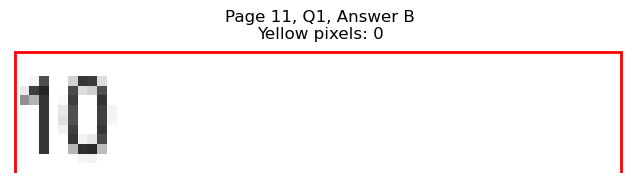

Page 11, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=95.5, y1=135.6
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 68
Page 11, Q1, C: Yellow percentage: 0.0%


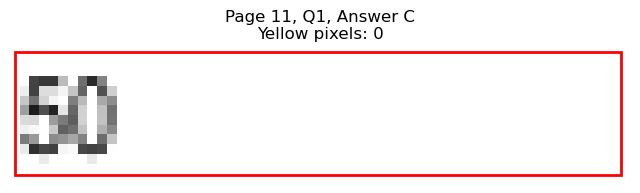

Page 11, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=347.2, y1=110.4
Page 11, Q1, D: Yellow pixels: 64
Page 11, Q1, D: Total non-white pixels: 129
Page 11, Q1, D: Yellow percentage: 49.6%


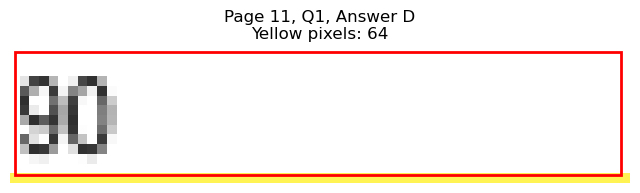

Page 11, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=346.7, y1=123.0
Page 11, Q1, E: Yellow pixels: 783
Page 11, Q1, E: Total non-white pixels: 819
Page 11, Q1, E: Yellow percentage: 95.6%


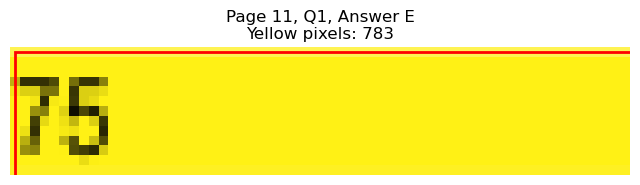


Page 11, Q1 - Selected Answer: E (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=82.5, y0=198.6, x1=176.8, y1=211.3
Page 11, Q2, A: Yellow pixels: 1356
Page 11, Q2, A: Total non-white pixels: 2030
Page 11, Q2, A: Yellow percentage: 66.8%


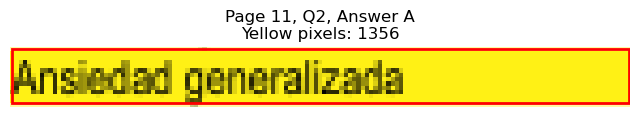

Page 11, Q2 - B: Detected box: x0=82.5, y0=211.3, x1=153.1, y1=224.0
Page 11, Q2, B: Yellow pixels: 0
Page 11, Q2, B: Total non-white pixels: 463
Page 11, Q2, B: Yellow percentage: 0.0%


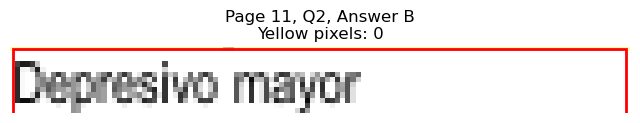

Page 11, Q2 - C: Detected box: x0=82.9, y0=223.9, x1=170.7, y1=236.6
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 460
Page 11, Q2, C: Yellow percentage: 0.0%


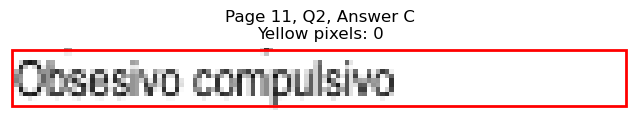

Page 11, Q2 - D: Detected box: x0=334.6, y0=198.6, x1=413.8, y1=211.3
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 432
Page 11, Q2, D: Yellow percentage: 0.0%


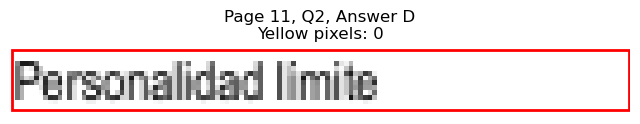

Page 11, Q2 - E: Detected box: x0=334.1, y0=211.3, x1=421.4, y1=224.0
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 455
Page 11, Q2, E: Yellow percentage: 0.0%


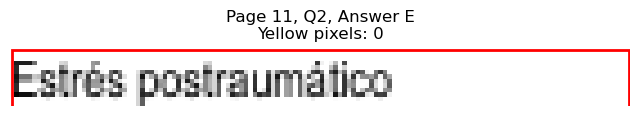


Page 11, Q2 - Selected Answer: A (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.5, y0=274.5, x1=131.7, y1=287.1
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 273
Page 11, Q3, A: Yellow percentage: 0.0%


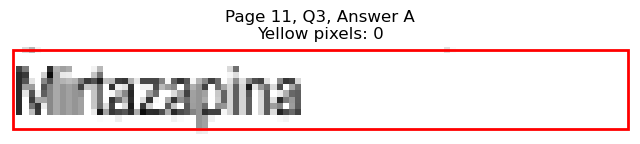

Page 11, Q3 - B: Detected box: x0=82.5, y0=287.1, x1=132.1, y1=299.7
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 229
Page 11, Q3, B: Yellow percentage: 0.0%


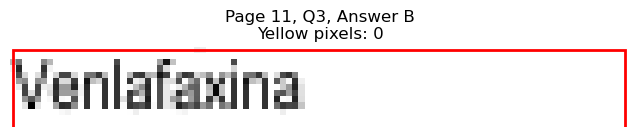

Page 11, Q3 - C: Detected box: x0=82.9, y0=299.7, x1=136.6, y1=312.3
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 251
Page 11, Q3, C: Yellow percentage: 0.0%


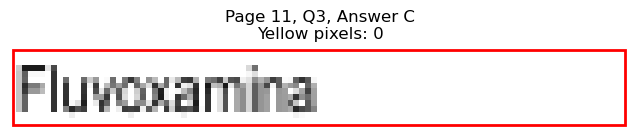

Page 11, Q3 - D: Detected box: x0=334.6, y0=274.5, x1=389.3, y1=287.1
Page 11, Q3, D: Yellow pixels: 1143
Page 11, Q3, D: Total non-white pixels: 1484
Page 11, Q3, D: Yellow percentage: 77.0%


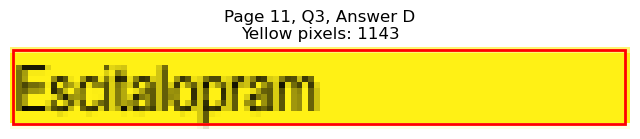

Page 11, Q3 - E: Detected box: x0=334.1, y0=287.1, x1=377.8, y1=299.7
Page 11, Q3, E: Yellow pixels: 0
Page 11, Q3, E: Total non-white pixels: 322
Page 11, Q3, E: Yellow percentage: 0.0%


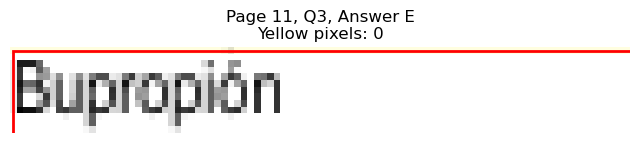


Page 11, Q3 - Selected Answer: D (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=82.5, y0=362.8, x1=136.6, y1=375.5
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 289
Page 11, Q4, A: Yellow percentage: 0.0%


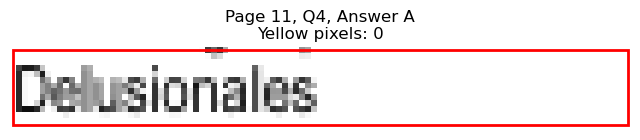

Page 11, Q4 - B: Detected box: x0=82.5, y0=375.4, x1=136.6, y1=388.1
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 269
Page 11, Q4, B: Yellow percentage: 0.0%


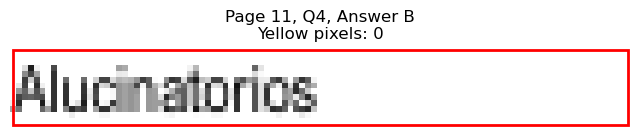

Page 11, Q4 - C: Detected box: x0=82.9, y0=388.0, x1=145.1, y1=400.7
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 295
Page 11, Q4, C: Yellow percentage: 0.0%


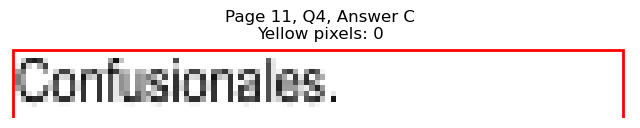

Page 11, Q4 - D: Detected box: x0=334.6, y0=362.8, x1=384.3, y1=375.5
Page 11, Q4, D: Yellow pixels: 101
Page 11, Q4, D: Total non-white pixels: 359
Page 11, Q4, D: Yellow percentage: 28.1%


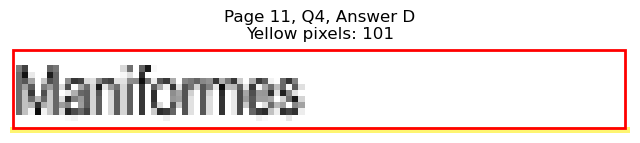

Page 11, Q4 - E: Detected box: x0=334.1, y0=375.4, x1=403.9, y1=388.1
Page 11, Q4, E: Yellow pixels: 1264
Page 11, Q4, E: Total non-white pixels: 1680
Page 11, Q4, E: Yellow percentage: 75.2%


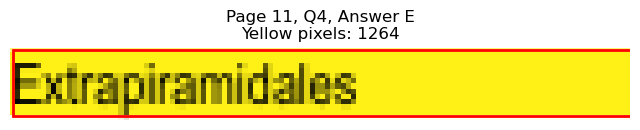


Page 11, Q4 - Selected Answer: E (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.5, y0=451.1, x1=117.6, y1=463.8
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 243
Page 11, Q5, A: Yellow percentage: 0.0%


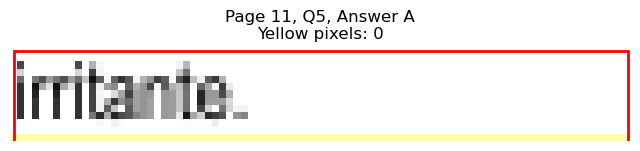

Page 11, Q5 - B: Detected box: x0=82.5, y0=463.7, x1=120.6, y1=476.4
Page 11, Q5, B: Yellow pixels: 918
Page 11, Q5, B: Total non-white pixels: 1246
Page 11, Q5, B: Yellow percentage: 73.7%


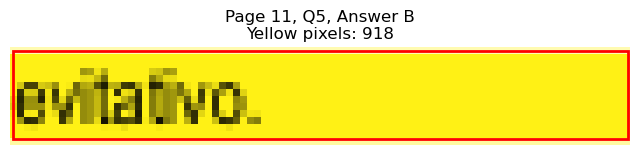

Page 11, Q5 - C: Detected box: x0=82.9, y0=476.3, x1=140.7, y1=489.0
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 391
Page 11, Q5, C: Yellow percentage: 0.0%


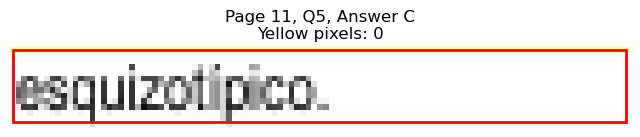

Page 11, Q5 - D: Detected box: x0=334.6, y0=451.1, x1=377.7, y1=463.8
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 213
Page 11, Q5, D: Yellow percentage: 0.0%


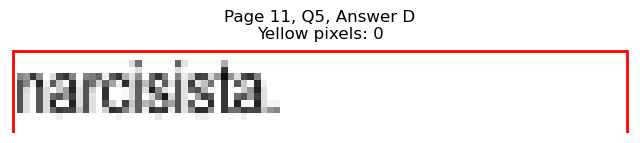

Page 11, Q5 - E: Detected box: x0=334.1, y0=463.7, x1=373.7, y1=476.4
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 199
Page 11, Q5, E: Yellow percentage: 0.0%


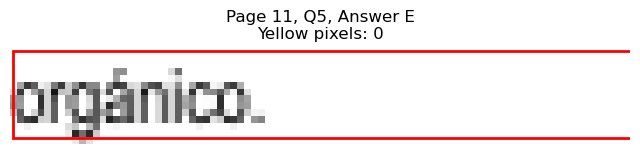


Page 11, Q5 - Selected Answer: B (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.5, y0=564.8, x1=176.8, y1=577.4
Page 11, Q6, A: Yellow pixels: 1361
Page 11, Q6, A: Total non-white pixels: 2030
Page 11, Q6, A: Yellow percentage: 67.0%


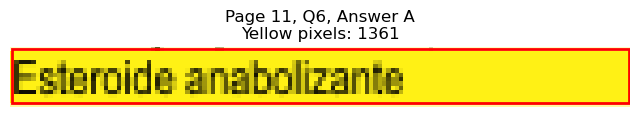

Page 11, Q6 - B: Detected box: x0=82.5, y0=577.4, x1=149.2, y1=590.0
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 472
Page 11, Q6, B: Yellow percentage: 0.0%


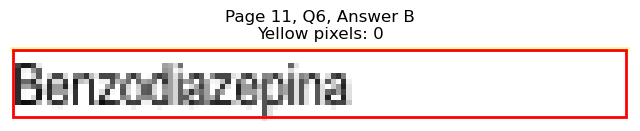

Page 11, Q6 - C: Detected box: x0=82.9, y0=590.0, x1=156.6, y1=602.6
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 378
Page 11, Q6, C: Yellow percentage: 0.0%


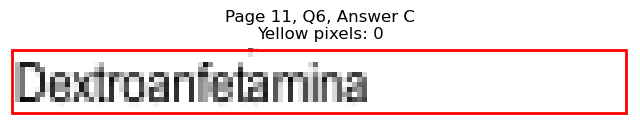

Page 11, Q6 - D: Detected box: x0=334.6, y0=564.8, x1=398.3, y1=577.4
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 325
Page 11, Q6, D: Yellow percentage: 0.0%


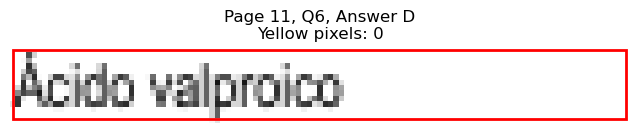

Page 11, Q6 - E: Detected box: x0=334.1, y0=577.4, x1=421.4, y1=590.0
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 470
Page 11, Q6, E: Yellow percentage: 0.0%


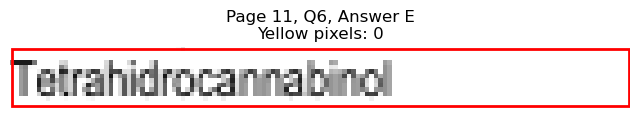


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=82.5, y0=627.9, x1=142.1, y1=640.6
Page 11, Q7, A: Yellow pixels: 1199
Page 11, Q7, A: Total non-white pixels: 1554
Page 11, Q7, A: Yellow percentage: 77.2%


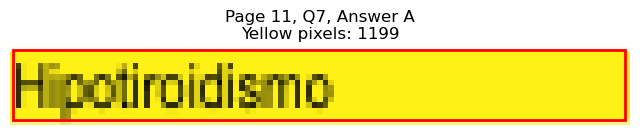

Page 11, Q7 - B: Detected box: x0=82.5, y0=640.5, x1=153.6, y1=653.2
Page 11, Q7, B: Yellow pixels: 122
Page 11, Q7, B: Total non-white pixels: 506
Page 11, Q7, B: Yellow percentage: 24.1%


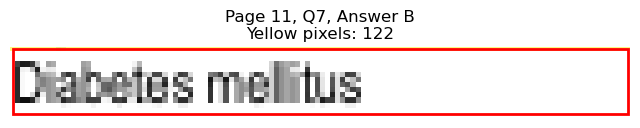

Page 11, Q7 - C: Detected box: x0=82.9, y0=653.1, x1=148.1, y1=665.8
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 325
Page 11, Q7, C: Yellow percentage: 0.0%


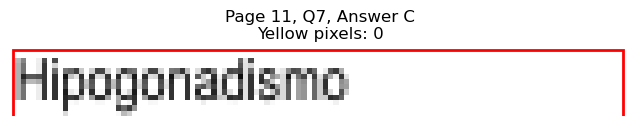

Page 11, Q7 - D: Detected box: x0=334.6, y0=627.9, x1=416.8, y1=640.6
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 448
Page 11, Q7, D: Yellow percentage: 0.0%


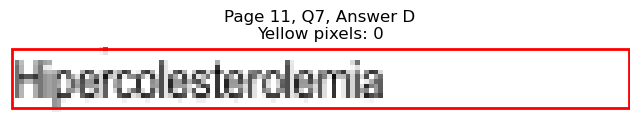

Page 11, Q7 - E: Detected box: x0=334.1, y0=640.5, x1=390.8, y1=653.2
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 303
Page 11, Q7, E: Yellow percentage: 0.0%


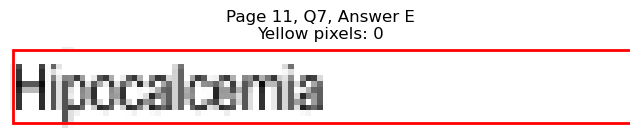


Page 11, Q7 - Selected Answer: A (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=82.5, y0=691.1, x1=217.8, y1=703.7
Page 11, Q8, A: Yellow pixels: 6
Page 11, Q8, A: Total non-white pixels: 853
Page 11, Q8, A: Yellow percentage: 0.7%


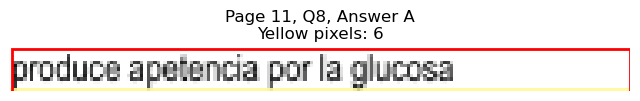

Page 11, Q8 - B: Detected box: x0=82.5, y0=703.7, x1=218.3, y1=716.3
Page 11, Q8, B: Yellow pixels: 1743
Page 11, Q8, B: Total non-white pixels: 2618
Page 11, Q8, B: Yellow percentage: 66.6%


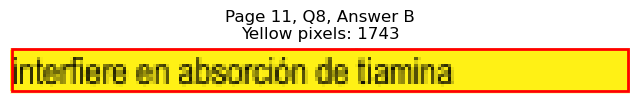

Page 11, Q8 - C: Detected box: x0=82.9, y0=716.3, x1=228.3, y1=728.9
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 910
Page 11, Q8, C: Yellow percentage: 0.0%


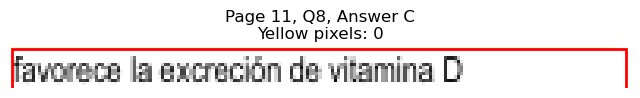

Page 11, Q8 - D: Detected box: x0=334.6, y0=691.1, x1=473.1, y1=703.7
Page 11, Q8, D: Yellow pixels: 0
Page 11, Q8, D: Total non-white pixels: 693
Page 11, Q8, D: Yellow percentage: 0.0%


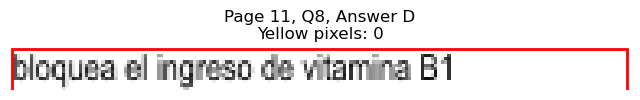

Page 11, Q8 - E: Detected box: x0=334.1, y0=703.7, x1=472.7, y1=716.3
Page 11, Q8, E: Yellow pixels: 0
Page 11, Q8, E: Total non-white pixels: 669
Page 11, Q8, E: Yellow percentage: 0.0%


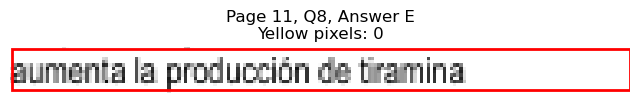


Page 11, Q8 - Selected Answer: B (based on yellow pixel count)





Page 12: Found 8 questions
Page 12, Q1 - A: Detected box: x0=82.5, y0=97.7, x1=115.6, y1=110.4
Page 12, Q1, A: Yellow pixels: 0
Page 12, Q1, A: Total non-white pixels: 170
Page 12, Q1, A: Yellow percentage: 0.0%


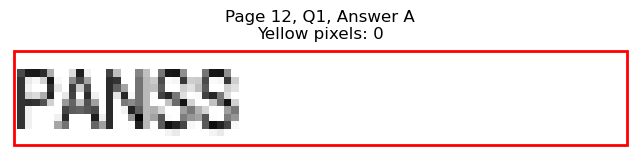

Page 12, Q1 - B: Detected box: x0=82.5, y0=110.3, x1=116.5, y1=123.0
Page 12, Q1, B: Yellow pixels: 0
Page 12, Q1, B: Total non-white pixels: 244
Page 12, Q1, B: Yellow percentage: 0.0%


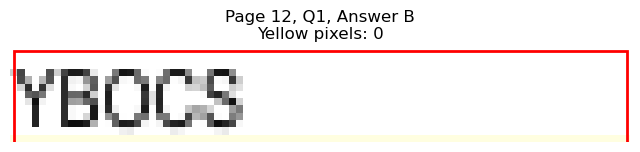

Page 12, Q1 - C: Detected box: x0=82.9, y0=122.9, x1=111.0, y1=135.6
Page 12, Q1, C: Yellow pixels: 940
Page 12, Q1, C: Total non-white pixels: 1120
Page 12, Q1, C: Yellow percentage: 83.9%


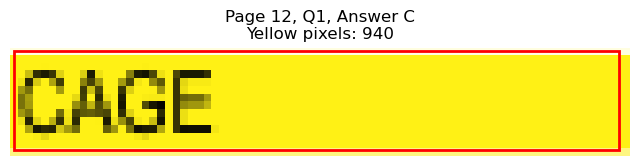

Page 12, Q1 - D: Detected box: x0=334.6, y0=97.7, x1=366.7, y1=110.4
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 155
Page 12, Q1, D: Yellow percentage: 0.0%


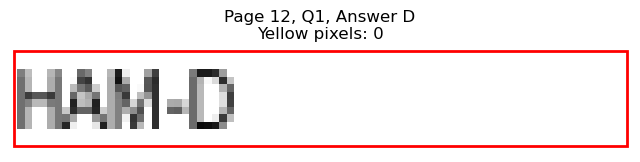

Page 12, Q1 - E: Detected box: x0=334.1, y0=110.3, x1=361.3, y1=123.0
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 139
Page 12, Q1, E: Yellow percentage: 0.0%


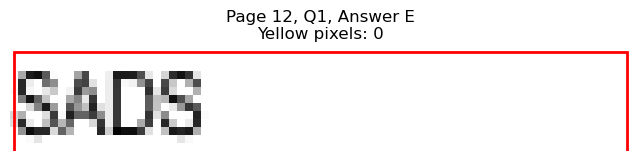


Page 12, Q1 - Selected Answer: C (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=82.5, y0=160.8, x1=174.7, y1=173.5
Page 12, Q2, A: Yellow pixels: 0
Page 12, Q2, A: Total non-white pixels: 482
Page 12, Q2, A: Yellow percentage: 0.0%


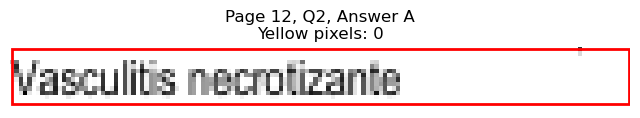

Page 12, Q2 - B: Detected box: x0=82.5, y0=173.4, x1=175.2, y1=186.1
Page 12, Q2, B: Yellow pixels: 144
Page 12, Q2, B: Total non-white pixels: 594
Page 12, Q2, B: Yellow percentage: 24.2%


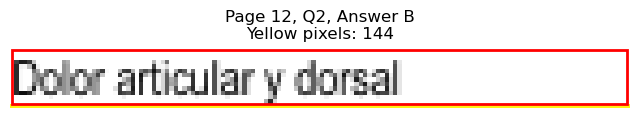

Page 12, Q2 - C: Detected box: x0=82.9, y0=186.0, x1=197.3, y1=198.7
Page 12, Q2, C: Yellow pixels: 1708
Page 12, Q2, C: Total non-white pixels: 2158
Page 12, Q2, C: Yellow percentage: 79.1%


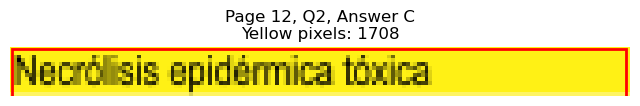

Page 12, Q2 - D: Detected box: x0=334.6, y0=160.8, x1=437.0, y1=173.5
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 519
Page 12, Q2, D: Yellow percentage: 0.0%


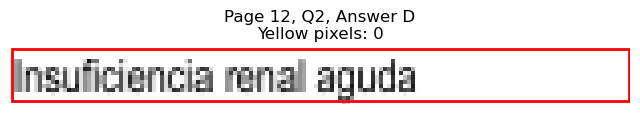

Page 12, Q2 - E: Detected box: x0=334.1, y0=173.4, x1=431.5, y1=186.1
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 522
Page 12, Q2, E: Yellow percentage: 0.0%


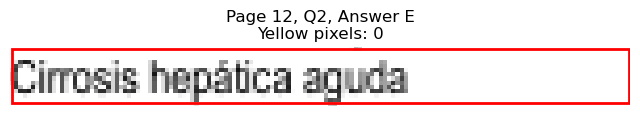


Page 12, Q2 - Selected Answer: C (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=82.5, y0=236.5, x1=175.2, y1=249.2
Page 12, Q3, A: Yellow pixels: 1524
Page 12, Q3, A: Total non-white pixels: 2016
Page 12, Q3, A: Yellow percentage: 75.6%


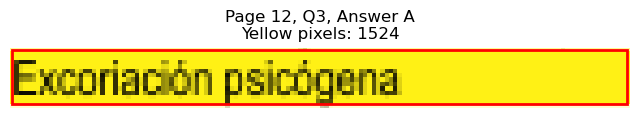

Page 12, Q3 - B: Detected box: x0=82.5, y0=249.1, x1=156.1, y1=261.8
Page 12, Q3, B: Yellow pixels: 0
Page 12, Q3, B: Total non-white pixels: 503
Page 12, Q3, B: Yellow percentage: 0.0%


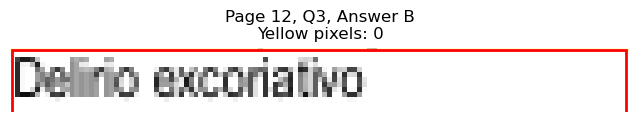

Page 12, Q3 - C: Detected box: x0=82.9, y0=261.7, x1=153.1, y1=274.4
Page 12, Q3, C: Yellow pixels: 0
Page 12, Q3, C: Total non-white pixels: 353
Page 12, Q3, C: Yellow percentage: 0.0%


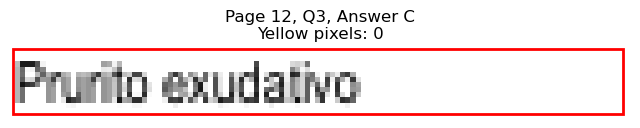

Page 12, Q3 - D: Detected box: x0=334.6, y0=236.5, x1=409.4, y1=249.2
Page 12, Q3, D: Yellow pixels: 0
Page 12, Q3, D: Total non-white pixels: 397
Page 12, Q3, D: Yellow percentage: 0.0%


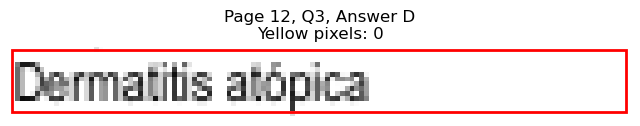

Page 12, Q3 - E: Detected box: x0=334.1, y0=249.1, x1=404.8, y1=261.8
Page 12, Q3, E: Yellow pixels: 0
Page 12, Q3, E: Total non-white pixels: 362
Page 12, Q3, E: Yellow percentage: 0.0%


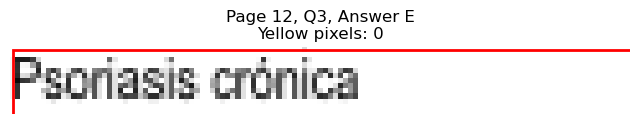


Page 12, Q3 - Selected Answer: A (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=82.5, y0=299.7, x1=130.6, y1=312.3
Page 12, Q4, A: Yellow pixels: 0
Page 12, Q4, A: Total non-white pixels: 251
Page 12, Q4, A: Yellow percentage: 0.0%


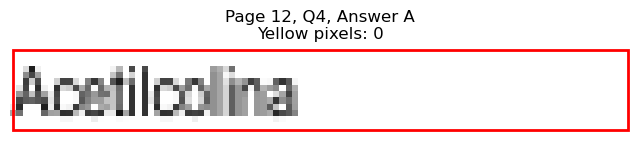

Page 12, Q4 - B: Detected box: x0=82.5, y0=312.3, x1=110.1, y1=324.9
Page 12, Q4, B: Yellow pixels: 0
Page 12, Q4, B: Total non-white pixels: 134
Page 12, Q4, B: Yellow percentage: 0.0%


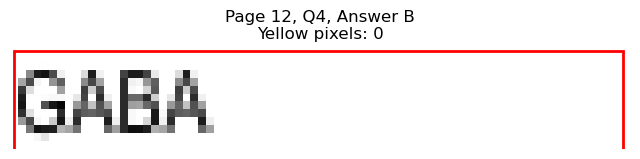

Page 12, Q4 - C: Detected box: x0=82.9, y0=324.9, x1=129.1, y1=337.5
Page 12, Q4, C: Yellow pixels: 0
Page 12, Q4, C: Total non-white pixels: 227
Page 12, Q4, C: Yellow percentage: 0.0%


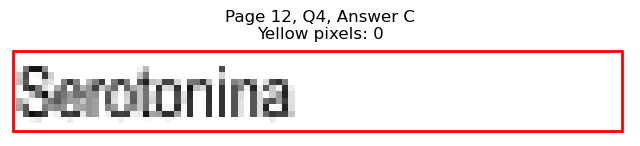

Page 12, Q4 - D: Detected box: x0=334.6, y0=299.7, x1=377.2, y1=312.3
Page 12, Q4, D: Yellow pixels: 94
Page 12, Q4, D: Total non-white pixels: 327
Page 12, Q4, D: Yellow percentage: 28.7%


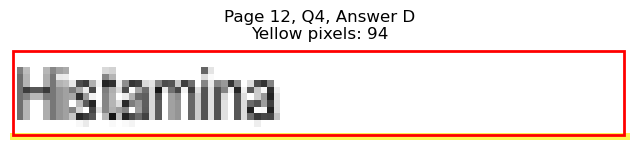

Page 12, Q4 - E: Detected box: x0=334.1, y0=312.3, x1=377.8, y1=324.9
Page 12, Q4, E: Yellow pixels: 1058
Page 12, Q4, E: Total non-white pixels: 1222
Page 12, Q4, E: Yellow percentage: 86.6%


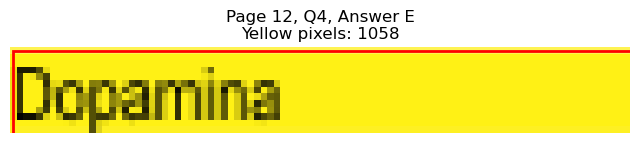


Page 12, Q4 - Selected Answer: E (based on yellow pixel count)




Page 12, Q5 - A: Detected box: x0=82.5, y0=375.4, x1=126.1, y1=388.1
Page 12, Q5, A: Yellow pixels: 1084
Page 12, Q5, A: Total non-white pixels: 1330
Page 12, Q5, A: Yellow percentage: 81.5%


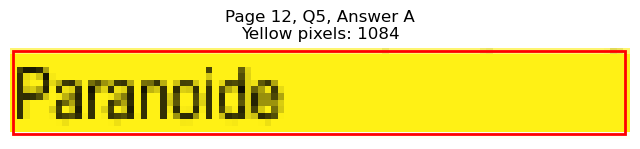

Page 12, Q5 - B: Detected box: x0=82.5, y0=388.0, x1=124.6, y1=400.7
Page 12, Q5, B: Yellow pixels: 0
Page 12, Q5, B: Total non-white pixels: 316
Page 12, Q5, B: Yellow percentage: 0.0%


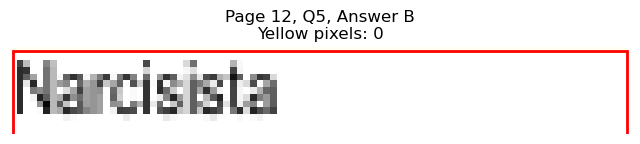

Page 12, Q5 - C: Detected box: x0=82.9, y0=400.6, x1=119.5, y1=413.3
Page 12, Q5, C: Yellow pixels: 0
Page 12, Q5, C: Total non-white pixels: 181
Page 12, Q5, C: Yellow percentage: 0.0%


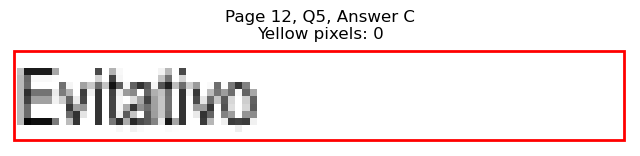

Page 12, Q5 - D: Detected box: x0=334.6, y0=375.4, x1=379.3, y1=388.1
Page 12, Q5, D: Yellow pixels: 0
Page 12, Q5, D: Total non-white pixels: 245
Page 12, Q5, D: Yellow percentage: 0.0%


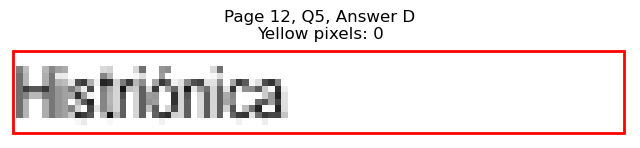

Page 12, Q5 - E: Detected box: x0=334.1, y0=388.0, x1=380.8, y1=400.7
Page 12, Q5, E: Yellow pixels: 0
Page 12, Q5, E: Total non-white pixels: 253
Page 12, Q5, E: Yellow percentage: 0.0%


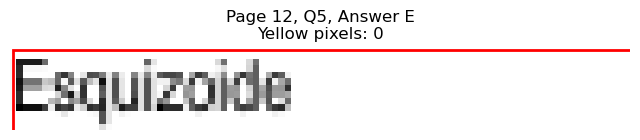


Page 12, Q5 - Selected Answer: A (based on yellow pixel count)




Page 12, Q6 - A: Detected box: x0=82.5, y0=438.5, x1=132.1, y1=451.2
Page 12, Q6, A: Yellow pixels: 0
Page 12, Q6, A: Total non-white pixels: 262
Page 12, Q6, A: Yellow percentage: 0.0%


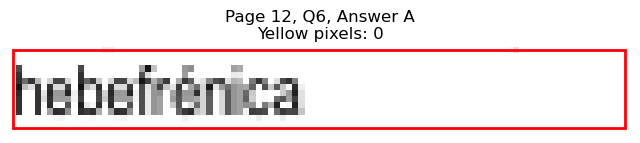

Page 12, Q6 - B: Detected box: x0=82.5, y0=451.1, x1=125.1, y1=463.8
Page 12, Q6, B: Yellow pixels: 0
Page 12, Q6, B: Total non-white pixels: 205
Page 12, Q6, B: Yellow percentage: 0.0%


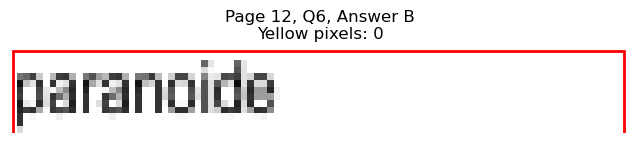

Page 12, Q6 - C: Detected box: x0=82.9, y0=463.7, x1=111.5, y1=476.4
Page 12, Q6, C: Yellow pixels: 0
Page 12, Q6, C: Total non-white pixels: 144
Page 12, Q6, C: Yellow percentage: 0.0%


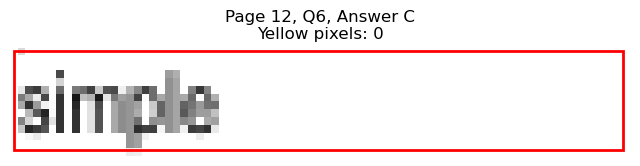

Page 12, Q6 - D: Detected box: x0=334.6, y0=438.5, x1=378.3, y1=451.2
Page 12, Q6, D: Yellow pixels: 1061
Page 12, Q6, D: Total non-white pixels: 1330
Page 12, Q6, D: Yellow percentage: 79.8%


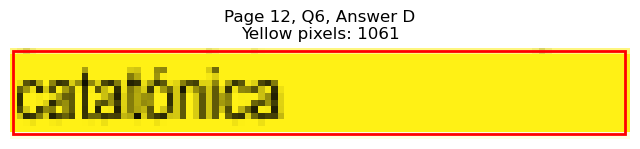

Page 12, Q6 - E: Detected box: x0=334.1, y0=451.1, x1=375.8, y1=463.8
Page 12, Q6, E: Yellow pixels: 0
Page 12, Q6, E: Total non-white pixels: 316
Page 12, Q6, E: Yellow percentage: 0.0%


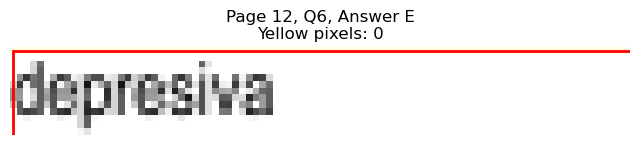


Page 12, Q6 - Selected Answer: D (based on yellow pixel count)




Page 12, Q7 - A: Detected box: x0=82.5, y0=564.8, x1=120.6, y1=577.4
Page 12, Q7, A: Yellow pixels: 0
Page 12, Q7, A: Total non-white pixels: 191
Page 12, Q7, A: Yellow percentage: 0.0%


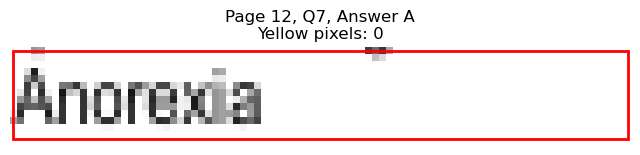

Page 12, Q7 - B: Detected box: x0=82.5, y0=577.4, x1=126.1, y1=590.0
Page 12, Q7, B: Yellow pixels: 0
Page 12, Q7, B: Total non-white pixels: 229
Page 12, Q7, B: Yellow percentage: 0.0%


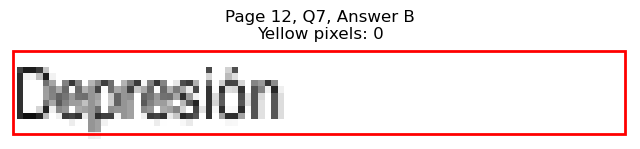

Page 12, Q7 - C: Detected box: x0=82.9, y0=590.0, x1=121.6, y1=602.6
Page 12, Q7, C: Yellow pixels: 0
Page 12, Q7, C: Total non-white pixels: 208
Page 12, Q7, C: Yellow percentage: 0.0%


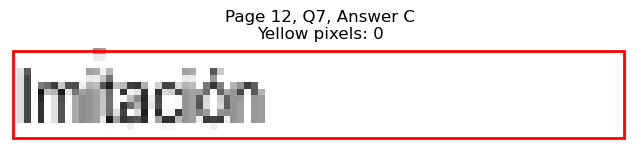

Page 12, Q7 - D: Detected box: x0=334.6, y0=564.8, x1=392.8, y1=577.4
Page 12, Q7, D: Yellow pixels: 109
Page 12, Q7, D: Total non-white pixels: 415
Page 12, Q7, D: Yellow percentage: 26.3%


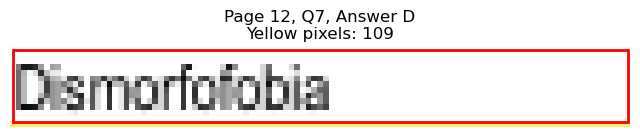

Page 12, Q7 - E: Detected box: x0=334.1, y0=577.4, x1=366.2, y1=590.0
Page 12, Q7, E: Yellow pixels: 946
Page 12, Q7, E: Total non-white pixels: 1079
Page 12, Q7, E: Yellow percentage: 87.7%


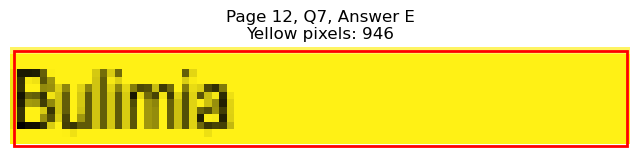


Page 12, Q7 - Selected Answer: E (based on yellow pixel count)




Page 12, Q8 - A: Detected box: x0=82.5, y0=627.9, x1=169.7, y1=640.6
Page 12, Q8, A: Yellow pixels: 0
Page 12, Q8, A: Total non-white pixels: 445
Page 12, Q8, A: Yellow percentage: 0.0%


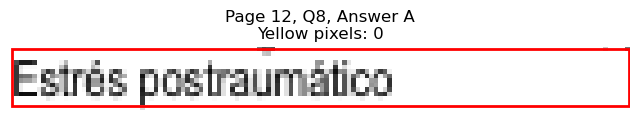

Page 12, Q8 - B: Detected box: x0=82.5, y0=640.5, x1=150.6, y1=653.2
Page 12, Q8, B: Yellow pixels: 0
Page 12, Q8, B: Total non-white pixels: 356
Page 12, Q8, B: Yellow percentage: 0.0%


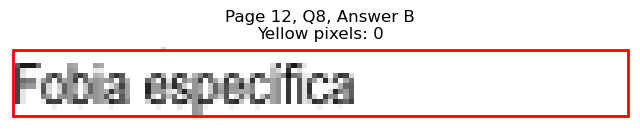

Page 12, Q8 - C: Detected box: x0=82.9, y0=653.1, x1=140.2, y1=665.8
Page 12, Q8, C: Yellow pixels: 0
Page 12, Q8, C: Total non-white pixels: 287
Page 12, Q8, C: Yellow percentage: 0.0%


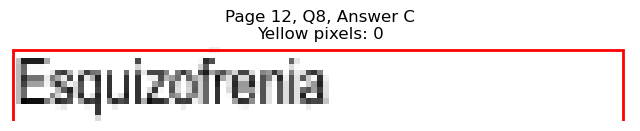

Page 12, Q8 - D: Detected box: x0=334.6, y0=627.9, x1=405.3, y1=640.6
Page 12, Q8, D: Yellow pixels: 122
Page 12, Q8, D: Total non-white pixels: 480
Page 12, Q8, D: Yellow percentage: 25.4%


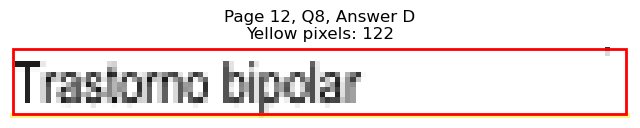

Page 12, Q8 - E: Detected box: x0=334.1, y0=640.5, x1=405.3, y1=653.2
Page 12, Q8, E: Yellow pixels: 1314
Page 12, Q8, E: Total non-white pixels: 1708
Page 12, Q8, E: Yellow percentage: 76.9%


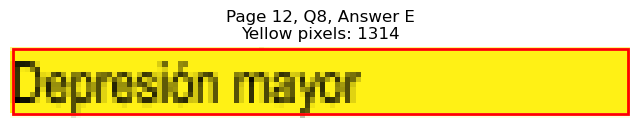


Page 12, Q8 - Selected Answer: E (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Varón de 45 años, contador, soltero, caracteri...
1   ¿A qué trastorno son más propensos los niños n...
2   De los siguientes fármacos, ¿cuál tiene mayor ...
3   Mujer de 24 años, recepcionista. Unos 4 días a...
4   Según el modelo ..., los trastornos mentales s...
..                                                ...
95  ¿Qué neurotransmisor está más involucrado en e...
96  ¿Cuál es el trastorno de personalidad que se c...
97  En un paciente con esquizofrenia … hay trastor...
98  Mujer, escolar de 15 años, apreciada por sus f...
99  Entre los siguientes trastornos, ¿cuál es la c...

[100 rows x 1 columns]

In [8]:
answers_df

option_A          option_B          option_C  \
0            Histriónica       Anancástica         Limítrofe   
1     Alto peso al nacer    Hiperactividad       Somnolencia   
2            Ziprasidona       Amisulprida       Aripiprazol   
3       depresivo mayor.  de somatización.  de personalidad.   
4             conductual       sinestésico     psicodinámico   
..                   ...               ...               ...   
95          Acetilcolina              GABA        Serotonina   
96             Paranoide        Narcisista         Evitativo   
97           hebefrénica         paranoide            simple   
98              Anorexia         Depresión         Imitación   
99  Estrés postraumático  Fobia específica     Esquizofrenia   

                option_D                 option_E  
0          Esquizotípica                Evitativa  
1            Hipotensión    Inteligencia superior  
2             Quetiapina              Risperidona  
3   disociativo crónico.  disfórico premenstrual.  
4              cognitivo               ontogénico  
..                   ...                      ...  
95             Histamina                 Dopamina  
96           Histriónica               Esquizoide  
97            catatónica                depresiva  
98         Dismorfofobia                  Bulimia  
99     Trastorno bipolar          Depresión mayor  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               D
1               B
2               A
3               E
4               C
..            ...
95              E
96              A
97              D
98              E
99              E

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions              option_A  \
0   Varón de 45 años, contador, soltero, caracteri...           Histriónica   
1   ¿A qué trastorno son más propensos los niños n...    Alto peso al nacer   
2   De los siguientes fármacos, ¿cuál tiene mayor ...           Ziprasidona   
3   Mujer de 24 años, recepcionista. Unos 4 días a...      depresivo mayor.   
4   Según el modelo ..., los trastornos mentales s...            conductual   
..                                                ...                   ...   
95  ¿Qué neurotransmisor está más involucrado en e...          Acetilcolina   
96  ¿Cuál es el trastorno de personalidad que se c...             Paranoide   
97  En un paciente con esquizofrenia … hay trastor...           hebefrénica   
98  Mujer, escolar de 15 años, apreciada por sus f...              Anorexia   
99  Entre los siguientes trastornos, ¿cuál es la c...  Estrés postraumático   

            option_B          option_C              option_D  \
0        Anancástica         Limítrofe         Esquizotípica   
1     Hiperactividad       Somnolencia           Hipotensión   
2        Amisulprida       Aripiprazol            Quetiapina   
3   de somatización.  de personalidad.  disociativo crónico.   
4        sinestésico     psicodinámico             cognitivo   
..               ...               ...                   ...   
95              GABA        Serotonina             Histamina   
96        Narcisista         Evitativo           Histriónica   
97         paranoide            simple            catatónica   
98         Depresión         Imitación         Dismorfofobia   
99  Fobia específica     Esquizofrenia     Trastorno bipolar   

                   option_E correct_answer  
0                 Evitativa              D  
1     Inteligencia superior              B  
2               Risperidona              A  
3   disfórico premenstrual.              E  
4                ontogénico              C  
..                      ...            ...  
95                 Dopamina              E  
96               Esquizoide              A  
97                depresiva              D  
98                  Bulimia              E  
99          Depresión mayor              E  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2020/PSIQUIATRIA.csv
